**Pokemon GO case**

**Team 6**

- CEDRIC RANDRIAMAMPIONONA
- GIACOMO NUBE
- CHRISTOS GKORITSAS
- VARUN SAI BERA
- MOHAMMED BEYAI
- DHRUVIN ACHARYA

**You can use the "Table of Contents" feature to better navigate through the code file**

# StepWise

In [1]:
#Copyright 2019 Sinan Talha Hascelik
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

# Repo: https://github.com/talhahascelik/python_stepwiseSelection

import numpy as np
import pandas as pd
import statsmodels.api as sm

def forwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
  X = __varcharProcessing__(X,varchar_process = varchar_process)
  return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def backwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
  X = __varcharProcessing__(X,varchar_process = varchar_process)
  return __backwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
  dtypes = X.dtypes
  if varchar_process == "drop":
    X = X.drop(columns = dtypes[dtypes == object].index.tolist())
    print("Character Variables (Dropped):", dtypes[dtypes == object].index.tolist())
  elif varchar_process == "dummy":
    X = pd.get_dummies(X,drop_first=False,dtype=int)
    print("Character Variables (Dummies Generated):", dtypes[dtypes == object].index.tolist())
  elif varchar_process == "dummy_dropfirst":
    X = pd.get_dummies(X,drop_first=True,dtype=int)
    print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())
  else:
    X = pd.get_dummies(X,drop_first=True,dtype=int)
    print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())

  X["intercept"] = 1
  cols = X.columns.tolist()
  cols = cols[-1:] + cols[:-1]
  X = X[cols]

  return X

def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor

    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")

    model = regressor(y, X[selected_cols])

    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj


    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals=pd.concat([pvals,pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"])],ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:

            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])

        else:
            print("Break : Significance Level")
            break

    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj

    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log,model

def __backwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    last_eleminated = ""
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type =="linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    for i in range(X.shape[1]):
        if i != 0 :
            if elimination_criteria == "aic":
                criteria = model.aic
                new_model = regressor(y,X)
                new_criteria = new_model.aic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            elif elimination_criteria == "bic":
                criteria = model.bic
                new_model = regressor(y,X)
                new_criteria = new_model.bic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            elif elimination_criteria == "adjr2" and model_type =="linear":
                criteria = model.rsquared_adj
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared_adj
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            elif elimination_criteria == "r2" and model_type =="linear":
                criteria = model.rsquared
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            else:
                new_model = regressor(y,X)
            model = new_model
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        else:
            model = regressor(y,X)
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        maxPval = max(model.pvalues)
        cols = X.columns.tolist()
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")

                    del X[j]
                    last_eleminated = j
        else:
            break
    print("Final Variables:", cols)
    iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
    return cols, iterations_log,model

#Copyright 2019 Emirhan Kartal
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

def BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "aic", varchar_process = "dummy_dropfirst", senter=0.05, sstay=0.05):
  X = __varcharProcessing__(X,varchar_process = varchar_process)
  return __stepwiseSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , senter = senter, sstay = sstay)

def __stepwiseSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", senter=0.05, sstay=0.05):

    iterations_log = ""
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor

    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")

    model = regressor(y, X[selected_cols])

    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj


    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals=pd.concat([pvals,pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"])],ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<= senter]
        if pvals.shape[0] > 0:

            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += "\n" + str(i+1) + ". iteration"
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


            for k in range(X[selected_cols+[pvals["Cols"][0]]].shape[1]):

                cols_backward = X[selected_cols+[pvals["Cols"][0]]].columns.tolist()
                pvals_backward = pd.DataFrame(columns = ["bw_Cols","bw_Pval"])


                for l in cols_backward:
                    pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)

                pvals_backward = pvals_backward.sort_values(by = ["bw_Pval"]).reset_index(drop=True)
                pvals_backward_drop = pvals_backward[pvals_backward.bw_Pval > sstay].reset_index(drop=True)

                if pvals_backward_drop.shape[0] > 0:


                    iterations_log += str("\nBackward Step Dropped : "+pvals_backward_drop["bw_Cols"][0] + "\n")

                    if pvals_backward_drop["bw_Cols"][0] in other_cols:
                        other_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass

                    if pvals_backward_drop["bw_Cols"][0] in selected_cols:
                        selected_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass

                    model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
                    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


                else:
                    print("break : No need to Backward Elimination")
                    break


            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])

        else:
            print("Break : Significance Level")
            break

    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj

    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)


    iterations_log += "\nFinal Selection and Model Statistics\n"

    for m in range(len(selected_cols)):
        iterations_log += "\n" + str(m+1) + str(". Final Variable :  "+ selected_cols[m])

    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


    return selected_cols, iterations_log,model


def prediction_stepwise(X,model,varchar_process = "dummy_dropfirst"):
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    Xpred=X[np.intersect1d(X.columns,model[0])]#only select var retained from model
    Xpred=Xpred.reindex(columns=model[0])#sort them according to the sequence used in the model
    p=model[2].predict(Xpred)
    return p

# Model Performance Measure (Professor's Function)

In [2]:
import pandas

#confusion matrix related performance measures
def evaluate_model(actual, pred,cutoff=0.5):
    #confusion matrix
    cm_df = pandas.DataFrame(confusion_matrix(actual,pred>cutoff))
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    print("Cutoff used: ",cutoff)
    print(cm_df)
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred>cutoff)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred>cutoff)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    sens_score = round(recall_score(actual, pred>cutoff)*100,2)#recall=sensitivity
    print('sensitivity score : ', sens_score)
    tn, fp, fn, tp = confusion_matrix(actual,pred>cutoff).ravel()
    spec_score = round((tn / (tn + fp))*100,2)
    print('specificity score : ', spec_score)
    fpr, tpr, _ = roc_curve(actual,pred)
    auc = roc_auc_score(actual,pred)
    roccurve=(pn.ggplot(pn.aes(x=fpr,y=tpr))+
                 pn.geom_line(color='red')+
                 pn.scale_y_continuous(name='sensitivity,true positive rate' ) +
                 pn.scale_x_continuous(name='1-specificity, false positive rate' ) +
                 pn.ggtitle('Roc curve: '+str(np.round(auc,2))))
    print(roccurve)
    return acc_score, roc_score, prec_score, sens_score, spec_score


#how does the accuracy change for different cutoff values
def AccuracyCutoffInfo(training,validation,depvar='churn',pred='predict'):
    # change the cutoff value's range as you please
    cutoff=np.arange(0.1, 0.85, 0.05)
    cm_train=[0]*len(cutoff)
    cm_validation=[0]*len(cutoff)
    for i in range(0,len(cutoff)):
        cm_train[i]=accuracy_score(training[depvar], training[pred]>cutoff[i])
        cm_validation[i]=accuracy_score(validation[depvar], validation[pred]>cutoff[i])
    accuracytable=pandas.concat([pandas.Series(cutoff).rename('cutoff'),pandas.Series(cm_train).rename('train'),pandas.Series(cm_validation).rename('validation')],axis=1)
    accplot=(pn.ggplot(accuracytable, pn.aes(x='cutoff')) +
    pn.geom_line( pn.aes(y = 'train'), color = "darkred")+
    pn.geom_line( pn.aes(y = 'validation'), color = "steelblue")+
    pn.geom_point(pn.aes(y = 'train'))+
    pn.geom_point(pn.aes(y = 'validation'))+
    pn.scale_y_continuous( labels=percent_format() ) +
    pn.ggtitle( "Train/validation accuracy for different cutoff values" ))
    accplot.show()


#confusionmatrixscatterplot
#create classification table first
def confusionmatrixplot(depvar,pred,cutoff=0.5):
    df=pandas.concat([pandas.Series(depvar).rename('depvar'),pandas.Series(pred).rename('pred')],axis=1)
    def categorize(depvar,pred,cutoff):
        if (pred>=cutoff and depvar==1):
            return 'TP'
        elif (pred>=cutoff and depvar==0):
            return 'FP'
        elif(pred<cutoff and depvar==1):
            return 'FN'
        else:
            return 'TN'
    df['type']=df.apply(lambda X: categorize(X.depvar,X.pred,cutoff), axis=1)
    #plot table
    confusionplot= (pn.ggplot(df, pn.aes(x='depvar',y='pred', color = 'type' ) ) +
        pn.geom_jitter() +
        pn.geom_hline( yintercept = cutoff, color = "blue", alpha = 0.6 ) +
        pn.scale_y_continuous( limits = (0.0,1.0) ) +
        pn.scale_color_discrete( breaks = [ "TP", "FN", "FP", "TN" ] ) + # ordering of the legend
        pn.ggtitle("Confusion Matrix with cutoff: "+str(cutoff)))
    confusionplot.show()


#find the cutoff that leads to the lowest costs
def findoptcutoff(depvar,pred):
    cutoff=np.arange(0.01, 0.99, 0.01)
    cost_fp=1 #providing a discount to a non churner
    cost_fn=4 #not identifying a churner and missing out on his clv
    costs=[0]*len(cutoff)
    bestcost=sys.maxsize
    bestindex=0
    for i in range(0,len(cutoff)):
        cm_df = pandas.DataFrame(confusion_matrix(depvar,pred>cutoff[i]))
        am_fp=cm_df[1][0]
        am_fn=cm_df[0][1]
        costs[i]=am_fp*cost_fp+am_fn*cost_fn
        if(costs[i]<bestcost):
            bestcost=costs[i]
            bestindex=i
    cutofftable=pandas.concat([pandas.Series(cutoff).rename('cutoff'),pandas.Series(costs).rename('costs')],axis=1)
    cutoffchart=(pn.ggplot(cutofftable, pn.aes(x = 'cutoff', y = 'costs',color='costs'))+
       pn.theme_bw() +
       pn.theme(panel_grid = pn.element_blank())+
       pn.geom_point()+
       pn.scale_colour_gradient2(low = "green", high = "red", mid = "yellow",midpoint=8000)+
      pn. ggtitle("Total cost for different cutoff values"))
    cutoffchart.show()
    print('best cutoff: ', cutoff[bestindex])
    return cutoff[bestindex]


#decile/lift table and chart
def calc_lift(depvar,pred,groups=10):
        helper=pandas.concat([pandas.Series(depvar).rename('depvar'),pandas.Series(pred).rename('pred')],axis=1)
        #reverse sort dataset based on pred
        helper=helper.sort_values(by=['pred'],ascending=False)
        helper['id']=range(0,len(helper['depvar']))
        #create new bucket variable highest pred in bucket 1
        helper['bucket']=pandas.qcut(helper['id'],q=10,labels=range(1, 10+1))
        #convert categorical bucket variable into a numeric one
        helper['bucket']=pandas.to_numeric(helper['bucket'])
        #create gaintable: count number of churners per bucket and total customers in a bucket
        lifttable=helper.groupby("bucket", as_index=False).agg(total=('depvar','count'),totalresp=('depvar','sum'))
        #calculate cumulative number of churners
        lifttable['cumresp']=lifttable['totalresp'].cumsum()
        #calculate lift: how many churners did you catch out of the total number of customers in a bucket
        lifttable['lift']=lifttable['cumresp']/sum(lifttable['totalresp'])*100
        #calculate cumulative lift
        lifttable['cumlift']=lifttable['lift']/(lifttable['bucket']*(100/groups))
        return lifttable

def plot_liftchart(depvar,pred):
    lifttable=calc_lift(depvar,pred)
    liftchart=(pn.ggplot(lifttable, pn.aes(x = 'bucket', y = 'cumlift'))+
      pn.theme_bw() +
      pn.theme(panel_grid = pn.element_blank())+#removes colored box behind bar chart
      pn.scale_x_continuous(breaks=range(1,11)) +
      pn.geom_point()+
      pn.geom_smooth()+
      pn.geom_text(pn.aes(x='bucket+0.5',y='cumlift', label='np.round(cumlift,2)')) +
      pn.ggtitle("Lift curve"))
    liftchart.show()
    return lifttable

# Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.cm as cm
import missingno #package to find and display na
from plotnine import *
import pandas# working with datraframes
import datetime# working with dates
import missingno #package to find and display na
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from mizani.formatters import percent_format
import sys
import plotnine as pn

# Data importing

In [4]:
customerdata = pd.read_csv('customerdata.csv',parse_dates=['Registrationdate'])
summerfintrx = pd.read_csv('summerfintrx.csv',parse_dates=['Date'])
summersesstrx = pd.read_csv('summersesstrx.csv',parse_dates=['Date'])
fallfintrx = pd.read_csv('fallfintrx.csv',parse_dates=['Date'])
fallsesstrx = pd.read_csv('fallsesstrx.csv',parse_dates=['Date'])

In [5]:
print(customerdata.head())
customerdata.describe()

   CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  Income
0           1             2       2021-01-01       0    8          0       0
1           2             3       2022-01-21       0   45          0       2
2           3             1       2021-05-27       0   29          1       2
3           4             3       2022-04-10       1   18          0       2
4           5             1       2021-05-16       1   48          1       0


CustomerID  CustomerType               Registrationdate  \
count  50000.000000  50000.000000                          50000   
mean   25000.500000      1.562240  2020-12-30 04:16:45.119999744   
min        1.000000      0.000000            2016-07-01 00:00:00   
25%    12500.750000      1.000000            2020-03-15 00:00:00   
50%    25000.500000      2.000000            2021-12-26 00:00:00   
75%    37500.250000      3.000000            2022-03-02 00:00:00   
max    50000.000000      3.000000            2022-04-30 00:00:00   
std    14433.901067      1.107281                            NaN   

             Gender          Age     fallbonus        Income  
count  50000.000000  50000.00000  50000.000000  50000.000000  
mean       0.399240     27.81278      0.202080      0.875540  
min        0.000000      6.00000      0.000000      0.000000  
25%        0.000000     18.00000      0.000000      0.000000  
50%        0.000000     28.00000      0.000000      1.000000  
75%        1.000000     34.00000      0.000000      2.000000  
max        1.000000     80.00000      1.000000      2.000000  
std        0.489747     13.63387      0.401556      0.810791

In [6]:
print(summerfintrx.head())
summerfintrx.describe()

   TransactionID       Date  CustomerID  ProductID  SessionID  Value
0              1 2022-08-06           4          1         21   4.99
1              2 2022-06-23           8          0         45   2.99
2              3 2022-06-12           9          1         54   4.99
3              4 2022-07-23          24          3        170  25.00
4              5 2022-06-22          24          2        177   9.99


TransactionID                           Date    CustomerID  \
count   21902.000000                          21902  21902.000000   
mean    10951.500000  2022-06-30 12:46:17.171034624  25065.498493   
min         1.000000            2022-05-01 00:00:00      4.000000   
25%      5476.250000            2022-05-31 00:00:00  12595.000000   
50%     10951.500000            2022-07-01 00:00:00  25029.000000   
75%     16426.750000            2022-07-31 00:00:00  37631.750000   
max     21902.000000            2022-08-30 00:00:00  49998.000000   
std      6322.707134                            NaN  14442.218469   

          ProductID      SessionID         Value  
count  21902.000000   21902.000000  21902.000000  
mean       1.114967  190040.307324      9.059984  
min        0.000000      21.000000      2.990000  
25%        0.000000   95486.500000      2.990000  
50%        1.000000  189921.000000      4.990000  
75%        2.000000  285170.750000      9.990000  
max        4.000000  379249.000000     99.000000  
std        1.079391  109498.764465     12.863693

In [7]:
print(summersesstrx.head())
summersesstrx.describe()

   SessionID       Date  CustomerID  Pokestops  Gyms  Raids  Social  Pokemons  \
0          1 2022-06-21           1          8    10      1       1        10   
1          2 2022-07-24           1         11     6      1       0        15   
2          3 2022-08-19           1         10     6      1       0        10   
3          4 2022-07-25           1         11     6      0       1        12   
4          5 2022-08-22           1         11    13      1       3        15   

   Distance   Duration  Experience  
0  1.233315  68.136824        4223  
1  1.886196  93.646617        3688  
2  1.010268  74.959642        3301  
3  3.735159  81.048298        2923  
4  1.895665  69.677535        5689  


SessionID                           Date     CustomerID  \
count  379271.00000                         379271  379271.000000   
mean   189636.00000  2022-06-30 12:24:43.355173888   25012.237160   
min         1.00000            2022-05-01 00:00:00       1.000000   
25%     94818.50000            2022-05-31 00:00:00   12508.000000   
50%    189636.00000            2022-07-01 00:00:00   24992.000000   
75%    284453.50000            2022-07-31 00:00:00   37537.000000   
max    379271.00000            2022-08-30 00:00:00   50000.000000   
std    109486.25131                            NaN   14440.564038   

           Pokestops           Gyms          Raids         Social  \
count  379271.000000  379271.000000  379271.000000  379271.000000   
mean       15.025217       6.707555       0.477015       0.783416   
min         6.000000       0.000000       0.000000       0.000000   
25%        12.000000       4.000000       0.000000       0.000000   
50%        15.000000       6.000000       0.000000       0.000000   
75%        17.000000       9.000000       0.000000       1.000000   
max        31.000000      35.000000      18.000000      34.000000   
std         3.343776       3.659085       1.091309       1.602935   

            Pokemons       Distance       Duration     Experience  
count  379271.000000  379271.000000  379271.000000  379271.000000  
mean       18.074390       3.573510      66.837787    3987.040794  
min         1.000000       0.032782       5.828665    1071.000000  
25%        11.000000       1.340758      31.773864    3122.000000  
50%        16.000000       2.258937      53.738999    3729.000000  
75%        22.000000       4.665085      94.756357    4504.000000  
max        94.000000      36.144597     303.425316   22300.000000  
std         9.638298       3.381471      42.785957    1353.653642

In [8]:
print(fallfintrx.head())
fallfintrx.describe()

   TransactionID       Date  CustomerID  ProductID  SessionID  Value
0              1 2022-11-12           4          3         15  25.00
1              2 2022-09-29           4          1         18   4.99
2              3 2022-10-09           8          2         35   9.99
3              4 2022-11-09           9          1         42   4.99
4              5 2022-12-08          24          2        142   9.99


TransactionID                           Date    CustomerID  \
count   16251.000000                          16251  16251.000000   
mean     8126.000000  2022-10-31 00:28:15.994092800  24905.111685   
min         1.000000            2022-09-01 00:00:00      4.000000   
25%      4063.500000            2022-10-01 00:00:00  12401.000000   
50%      8126.000000            2022-10-31 00:00:00  24797.000000   
75%     12188.500000            2022-12-01 00:00:00  37432.500000   
max     16251.000000            2022-12-30 00:00:00  49998.000000   
std      4691.403948                            NaN  14434.771328   

          ProductID      SessionID         Value  
count  16251.000000   16251.000000  16251.000000  
mean       1.059073  148583.882776      8.639898  
min        0.000000      15.000000      2.990000  
25%        0.000000   74054.500000      2.990000  
50%        1.000000  147778.000000      4.990000  
75%        2.000000  223097.000000      9.990000  
max        4.000000  299171.000000     99.000000  
std        1.063616   86201.183939     12.418591

In [9]:
print(fallsesstrx.head())
fallsesstrx.describe()

   SessionID       Date  CustomerID  Pokestops  Gyms  Raids  Social  Pokemons  \
0          1 2022-10-04           1         12    15      1       3        14   
1          2 2022-10-24           1         10    16      2       2        13   
2          3 2022-11-03           2         17    10      0       1        28   
3          4 2022-10-27           2         16     6      0       0        23   
4          5 2022-10-18           2         18     7      0       0        26   

   Distance   Duration  Experience  
0  0.816944  83.787773        5981  
1  1.963824  48.337727        6946  
2  1.742596  15.227669        4624  
3  1.248686  41.884230        3274  
4  0.385583  30.112946        3638  


SessionID                           Date     CustomerID  \
count  299185.000000                         299185  299185.000000   
mean   149593.000000  2022-10-30 23:21:43.007838208   25073.796955   
min         1.000000            2022-09-01 00:00:00       1.000000   
25%     74797.000000            2022-10-01 00:00:00   12522.000000   
50%    149593.000000            2022-10-31 00:00:00   25112.000000   
75%    224389.000000            2022-11-30 00:00:00   37640.000000   
max    299185.000000            2022-12-30 00:00:00   50000.000000   
std     86367.414481                            NaN   14462.238686   

           Pokestops           Gyms          Raids         Social  \
count  299185.000000  299185.000000  299185.000000  299185.000000   
mean       15.058923       6.711038       0.470064       0.780748   
min         5.000000       0.000000       0.000000       0.000000   
25%        12.000000       4.000000       0.000000       0.000000   
50%        15.000000       6.000000       0.000000       0.000000   
75%        17.000000       9.000000       0.000000       1.000000   
max        31.000000      42.000000      18.000000      24.000000   
std         3.341680       3.661717       1.085929       1.606619   

            Pokemons       Distance       Duration     Experience  
count  299185.000000  299185.000000  299185.000000  299185.000000  
mean       18.133543       3.584800      67.024124    3986.024416  
min         1.000000       0.029427       6.389194    1048.000000  
25%        11.000000       1.342986      32.007112    3122.000000  
50%        16.000000       2.271868      53.886735    3728.000000  
75%        23.000000       4.694643      94.874952    4499.000000  
max        97.000000      39.210113     291.566855   22166.000000  
std         9.631052       3.388672      42.805896    1350.797397

In [10]:
#convert datetime to date (we don't need the hour)
summerfintrx['Date'] = pd.to_datetime(summerfintrx['Date'])
summersesstrx['Date'] = pd.to_datetime(summersesstrx['Date'])
fallfintrx['Date'] = pd.to_datetime(fallfintrx['Date'])
fallsesstrx['Date'] = pd.to_datetime(fallsesstrx['Date'])
customerdata['Registrationdate'] = pd.to_datetime(customerdata['Registrationdate'])

# Question 1 - Creation of a basetable + profiling

## 1.1) Create a basetable containing the active customers (at least 1 play session during the summer period). Indicating whether they received the fall boost promo code or not.

In [11]:
summerstart = pd.to_datetime('2022-05-01')
summerend = pd.to_datetime('2022-08-31')
fallstart = pd.to_datetime('2022-09-01')
fallend = pd.to_datetime('2022-12-31')

In [12]:
# Check the length of the session and customer dataframes
print(len(pd.unique(summersesstrx['CustomerID'])))
print(len(pd.unique(fallsesstrx['CustomerID'])))
print(len(pd.unique(customerdata['CustomerID'])))

49763
45074
50000


**For the summer period**

In [13]:
# Groupby CustomerID to find the frequency and recency of all players in summer
active_summer=summersesstrx.groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                     recency = ('Date', lambda date: (summerend - date.max()).days))
active_summer['recency'] = active_summer['recency'].astype(int)
print(len(active_summer))
active_summer.describe()

49763


CustomerID     frequency       recency
count  49763.000000  49763.000000  49763.000000
mean   25009.612604      7.621546     16.599924
std    14435.222917      2.527075     16.500205
min        1.000000      1.000000      1.000000
25%    12506.500000      6.000000      5.000000
50%    25008.000000      8.000000     11.000000
75%    37520.500000     10.000000     23.000000
max    50000.000000     14.000000    122.000000

In [14]:
customerdata

CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  \
0               1             2       2021-01-01       0    8          0   
1               2             3       2022-01-21       0   45          0   
2               3             1       2021-05-27       0   29          1   
3               4             3       2022-04-10       1   18          0   
4               5             1       2021-05-16       1   48          1   
...           ...           ...              ...     ...  ...        ...   
49995       49996             0       2022-03-27       1    9          1   
49996       49997             3       2022-03-04       0   37          0   
49997       49998             2       2018-07-26       0   27          1   
49998       49999             3       2020-12-30       0   28          0   
49999       50000             3       2022-04-06       0   26          0   

       Income  
0           0  
1           2  
2           2  
3           2  
4           0  
...       ...  
49995       0  
49996       0  
49997       1  
49998       2  
49999       0  

[50000 rows x 7 columns]

In [15]:
# Create the basetable for the sumemr session by merging active_summer with customerdata
basetable_summer = active_summer.merge(customerdata, how='inner', left_on = 'CustomerID', right_on = 'CustomerID')
basetable_summer

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  
0        8          0       0  
1       45          0       2  
2       29          1       2  
3       18          0       2  
4       48          1       0  
...    ...        ...     ...  
49758    9          1       0  
49759   37          0       0  
49760   27          1       1  
49761   28          0       2  
49762   26          0       0  

[49763 rows x 9 columns]

In [16]:
# Calculate the monetary value for basetable summer
summerfin = summerfintrx.groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))
basetable_summer = basetable_summer.merge(summerfin, how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable_summer.fillna(0, inplace=True)
basetable_summer

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue  
0        8          0       0           0.00  
1       45          0       2           0.00  
2       29          1       2           0.00  
3       18          0       2           4.99  
4       48          1       0           0.00  
...    ...        ...     ...            ...  
49758    9          1       0           0.00  
49759   37          0       0           0.00  
49760   27          1       1           9.98  
49761   28          0       2           0.00  
49762   26          0       0           0.00  

[49763 rows x 10 columns]

In [17]:
basetable_summer.describe()

CustomerID     frequency       recency  CustomerType  \
count  49763.000000  49763.000000  49763.000000  49763.000000   
mean   25009.612604      7.621546     16.599924      1.562768   
min        1.000000      1.000000      1.000000      0.000000   
25%    12506.500000      6.000000      5.000000      1.000000   
50%    25008.000000      8.000000     11.000000      2.000000   
75%    37520.500000     10.000000     23.000000      3.000000   
max    50000.000000     14.000000    122.000000      3.000000   
std    14435.222917      2.527075     16.500205      1.107671   

                    Registrationdate        Gender           Age  \
count                          49763  49763.000000  49763.000000   
mean   2020-12-29 18:16:58.732793600      0.399333     27.813416   
min              2016-07-01 00:00:00      0.000000      6.000000   
25%              2020-03-11 00:00:00      0.000000     18.000000   
50%              2021-12-30 00:00:00      0.000000     28.000000   
75%              2022-03-02 00:00:00      1.000000     34.000000   
max              2022-04-30 00:00:00      1.000000     80.000000   
std                              NaN      0.489766     13.636048   

          fallbonus        Income  MonetaryValue  
count  49763.000000  49763.000000   49763.000000  
mean       0.202219      0.873460       3.987536  
min        0.000000      0.000000       0.000000  
25%        0.000000      0.000000       0.000000  
50%        0.000000      1.000000       0.000000  
75%        0.000000      2.000000       2.990000  
max        1.000000      2.000000     212.980000  
std        0.401658      0.810463      10.688428

In [18]:
# Count the number of players that received the fallbonus in the end of summer
basetable_summer.fallbonus.sum()

10063

**For the fall period**

In [19]:
active_fall=fallsesstrx.groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                     recency = ('Date', lambda date: (fallend - date.max()).days))
active_fall['recency'] = active_fall['recency'].astype(int)
print(len(active_fall))
active_fall.describe()

45074


CustomerID     frequency       recency
count  45074.000000  45074.000000  45074.000000
mean   25039.123730      6.637640     19.468452
std    14430.832629      2.515502     19.691915
min        1.000000      1.000000      1.000000
25%    12552.250000      5.000000      6.000000
50%    25079.500000      7.000000     13.000000
75%    37540.750000      9.000000     26.000000
max    50000.000000     14.000000    121.000000

In [20]:
basetable_fall = active_fall.merge(customerdata, how='inner', left_on = 'CustomerID', right_on = 'CustomerID')
basetable_fall

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          2       68             2       2021-01-01       0   
1               2          9       37             3       2022-01-21       0   
2               3          2       38             1       2021-05-27       0   
3               4          8        3             3       2022-04-10       1   
4               5          3       13             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
45069       49996          9        4             0       2022-03-27       1   
45070       49997         10       16             3       2022-03-04       0   
45071       49998          7       63             2       2018-07-26       0   
45072       49999          1      118             3       2020-12-30       0   
45073       50000          8       62             3       2022-04-06       0   

       Age  fallbonus  Income  
0        8          0       0  
1       45          0       2  
2       29          1       2  
3       18          0       2  
4       48          1       0  
...    ...        ...     ...  
45069    9          1       0  
45070   37          0       0  
45071   27          1       1  
45072   28          0       2  
45073   26          0       0  

[45074 rows x 9 columns]

In [21]:
fallfin = fallfintrx.groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))
basetable_fall = basetable_fall.merge(fallfin, how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable_fall.fillna(0, inplace=True)
basetable_fall

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          2       68             2       2021-01-01       0   
1               2          9       37             3       2022-01-21       0   
2               3          2       38             1       2021-05-27       0   
3               4          8        3             3       2022-04-10       1   
4               5          3       13             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
45069       49996          9        4             0       2022-03-27       1   
45070       49997         10       16             3       2022-03-04       0   
45071       49998          7       63             2       2018-07-26       0   
45072       49999          1      118             3       2020-12-30       0   
45073       50000          8       62             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue  
0        8          0       0           0.00  
1       45          0       2           0.00  
2       29          1       2           0.00  
3       18          0       2          29.99  
4       48          1       0           0.00  
...    ...        ...     ...            ...  
45069    9          1       0           0.00  
45070   37          0       0           0.00  
45071   27          1       1          25.00  
45072   28          0       2           0.00  
45073   26          0       0           0.00  

[45074 rows x 10 columns]

In [22]:
basetable_fall.describe()

CustomerID     frequency       recency  CustomerType  \
count  45074.000000  45074.000000  45074.000000  45074.000000   
mean   25039.123730      6.637640     19.468452      1.558393   
min        1.000000      1.000000      1.000000      0.000000   
25%    12552.250000      5.000000      6.000000      1.000000   
50%    25079.500000      7.000000     13.000000      2.000000   
75%    37540.750000      9.000000     26.000000      3.000000   
max    50000.000000     14.000000    121.000000      3.000000   
std    14430.832629      2.515502     19.691915      1.113914   

                    Registrationdate        Gender           Age  \
count                          45074  45074.000000  45074.000000   
mean   2020-12-28 16:05:07.973554432      0.398545     27.796224   
min              2016-07-01 00:00:00      0.000000      6.000000   
25%              2020-03-04 06:00:00      0.000000     18.000000   
50%              2022-01-01 00:00:00      0.000000     28.000000   
75%              2022-03-02 00:00:00      1.000000     34.000000   
max              2022-04-30 00:00:00      1.000000     80.000000   
std                              NaN      0.489604     13.606502   

          fallbonus        Income  MonetaryValue  
count  45074.000000  45074.000000   45074.000000  
mean       0.202711      0.876758       3.115033  
min        0.000000      0.000000       0.000000  
25%        0.000000      0.000000       0.000000  
50%        0.000000      1.000000       0.000000  
75%        0.000000      2.000000       2.990000  
max        1.000000      2.000000     136.980000  
std        0.402023      0.810630       9.012144

In [23]:
customerdata

CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  \
0               1             2       2021-01-01       0    8          0   
1               2             3       2022-01-21       0   45          0   
2               3             1       2021-05-27       0   29          1   
3               4             3       2022-04-10       1   18          0   
4               5             1       2021-05-16       1   48          1   
...           ...           ...              ...     ...  ...        ...   
49995       49996             0       2022-03-27       1    9          1   
49996       49997             3       2022-03-04       0   37          0   
49997       49998             2       2018-07-26       0   27          1   
49998       49999             3       2020-12-30       0   28          0   
49999       50000             3       2022-04-06       0   26          0   

       Income  
0           0  
1           2  
2           2  
3           2  
4           0  
...       ...  
49995       0  
49996       0  
49997       1  
49998       2  
49999       0  

[50000 rows x 7 columns]

In [24]:
# Calculating the total basetable
basetable = customerdata
basetable['MonetaryValueS'] = basetable_summer['MonetaryValue']
basetable['MonetaryValueF'] = basetable_fall['MonetaryValue']
basetable.fillna(0, inplace=True)
basetable['MonetaryValue'] = basetable['MonetaryValueS'] + basetable['MonetaryValueF']

## 1.2) Calculate the demographics and RFM metrics for the relevant play and financial transactions database. Based on these metrics, sketch a general profile (use the correct descriptive metric for each variable) of the customer base according to demographics, spending and usage transactions.

In [25]:
summersesstrx.describe()

SessionID                           Date     CustomerID  \
count  379271.00000                         379271  379271.000000   
mean   189636.00000  2022-06-30 12:24:43.355173888   25012.237160   
min         1.00000            2022-05-01 00:00:00       1.000000   
25%     94818.50000            2022-05-31 00:00:00   12508.000000   
50%    189636.00000            2022-07-01 00:00:00   24992.000000   
75%    284453.50000            2022-07-31 00:00:00   37537.000000   
max    379271.00000            2022-08-30 00:00:00   50000.000000   
std    109486.25131                            NaN   14440.564038   

           Pokestops           Gyms          Raids         Social  \
count  379271.000000  379271.000000  379271.000000  379271.000000   
mean       15.025217       6.707555       0.477015       0.783416   
min         6.000000       0.000000       0.000000       0.000000   
25%        12.000000       4.000000       0.000000       0.000000   
50%        15.000000       6.000000       0.000000       0.000000   
75%        17.000000       9.000000       0.000000       1.000000   
max        31.000000      35.000000      18.000000      34.000000   
std         3.343776       3.659085       1.091309       1.602935   

            Pokemons       Distance       Duration     Experience  
count  379271.000000  379271.000000  379271.000000  379271.000000  
mean       18.074390       3.573510      66.837787    3987.040794  
min         1.000000       0.032782       5.828665    1071.000000  
25%        11.000000       1.340758      31.773864    3122.000000  
50%        16.000000       2.258937      53.738999    3729.000000  
75%        22.000000       4.665085      94.756357    4504.000000  
max        94.000000      36.144597     303.425316   22300.000000  
std         9.638298       3.381471      42.785957    1353.653642

In [26]:
# We will use the basetable for the summer period to calculate the demographics and RFM, as everyone who is in this table has played at least once during summer
basetable_summer

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue  
0        8          0       0           0.00  
1       45          0       2           0.00  
2       29          1       2           0.00  
3       18          0       2           4.99  
4       48          1       0           0.00  
...    ...        ...     ...            ...  
49758    9          1       0           0.00  
49759   37          0       0           0.00  
49760   27          1       1           9.98  
49761   28          0       2           0.00  
49762   26          0       0           0.00  

[49763 rows x 10 columns]

In [27]:
# Ideas for demographics 

#Summer

#age distribution
#gender distribution
#spending distribution
  #by customer type
#income distribution
#play frequency
  #by age, by gender, by income
#customer type


#Fall

#age distribution
#gender distribution
#spending distribution
  #by customer type
#income distribution
#play frequency
  #by age, by gender, by income

#Total

#age distribution
#gender distribution
#spending distribution
  #by customer type
#income distribution
#play frequency
  #by age, by gender, by income

In [28]:
# Check for the correlation between Income and Monetary value for both session periods and the total one
summer_correlation = basetable_summer['Income'].corr(basetable_summer['MonetaryValue'])
fall_correlation = basetable_fall['Income'].corr(basetable_fall['MonetaryValue'])
total_correlation = basetable['Income'].corr(basetable['MonetaryValue'])

print(f"Summer Correlation: {summer_correlation}")
print(f"Fall Correlation: {fall_correlation}")
print(f"Total Correlation: {total_correlation}")

Summer Correlation: -0.09958113239505598
Fall Correlation: -0.049948941742999096
Total Correlation: -0.0026623696600460043


In [29]:
# Set the prerequisite for the chart
basetable_summer['Gender'] = basetable_summer['Gender'].replace({0: 'Male', 1: 'Female'})
basetable_summer['Income'] = basetable_summer['Income'].replace({0: 'Low', 1: 'Medium', 2: 'High'})
basetable_summer['CustomerType'] = basetable_summer['CustomerType'].replace({0: 'Walker', 1: 'Miscellaneous', 2: 'Social Raider', 3: 'Catcher'})

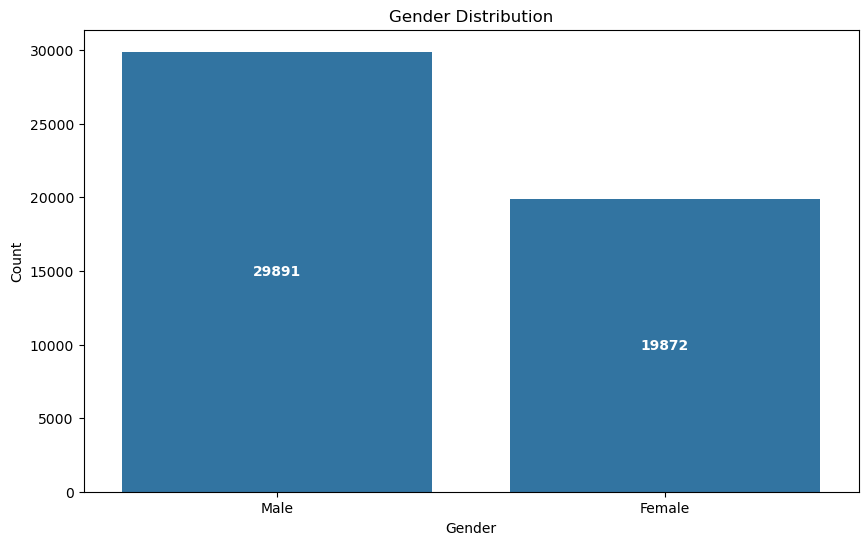

In [30]:
# Bar chart of Gender Distribution by summer Customer Data
plt.figure(figsize=(10, 6))
barplot = sns.countplot(x='Gender', data=basetable_summer)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center', color='white', fontsize=10, weight='bold')

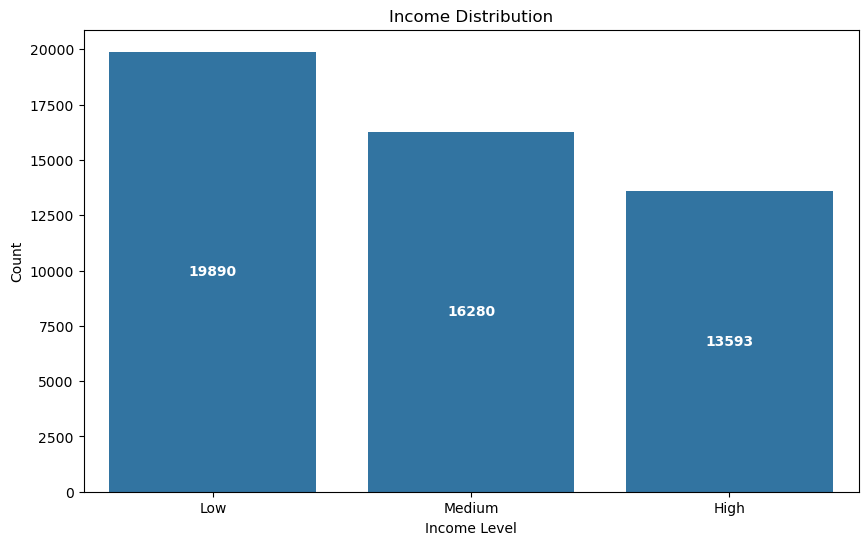

In [31]:
# Bar chart of Income Distribution by summer Customer Data
plt.figure(figsize=(10, 6))
income_order = ['Low', 'Medium', 'High']
barplot = sns.countplot(x='Income', data=basetable_summer, order = income_order)
plt.title('Income Distribution')
plt.xlabel('Income Level')
plt.ylabel('Count')
for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center', color='white', fontsize=10, weight='bold')
plt.show()

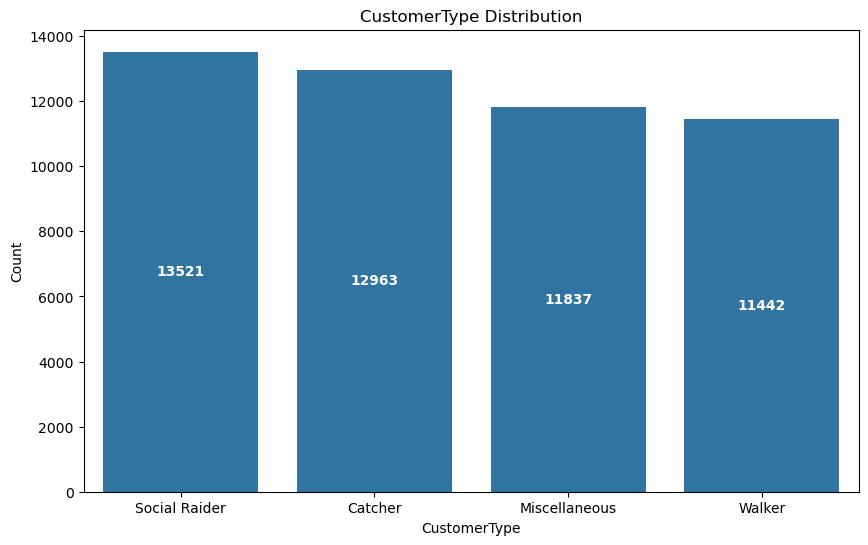

In [32]:
# bar chart of CustomerType Distribution by summer Customer Data
plt.figure(figsize=(10, 6))
barplot = sns.countplot(x='CustomerType', data=basetable_summer)
plt.title('CustomerType Distribution')
plt.xlabel('CustomerType')
plt.ylabel('Count')
for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center', color='white', fontsize=10, weight='bold')
plt.show()

In [33]:
basetable_summer['CustomerType'] = basetable_summer['CustomerType'].replace({'Walker': 0, 'Miscellaneous': 1, 'Social Raider': 2, 'Catcher': 3})
basetable_summer['Gender'] = basetable_summer['Gender'].replace({'Male': 0, 'Female': 1})
gender_counts = basetable_summer.groupby(['CustomerType', 'Gender']).size().unstack()
gender_counts

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\3587473309.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\3587473309.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Gender           0     1
CustomerType            
0             6860  4582
1             7102  4735
2             8117  5404
3             7812  5151

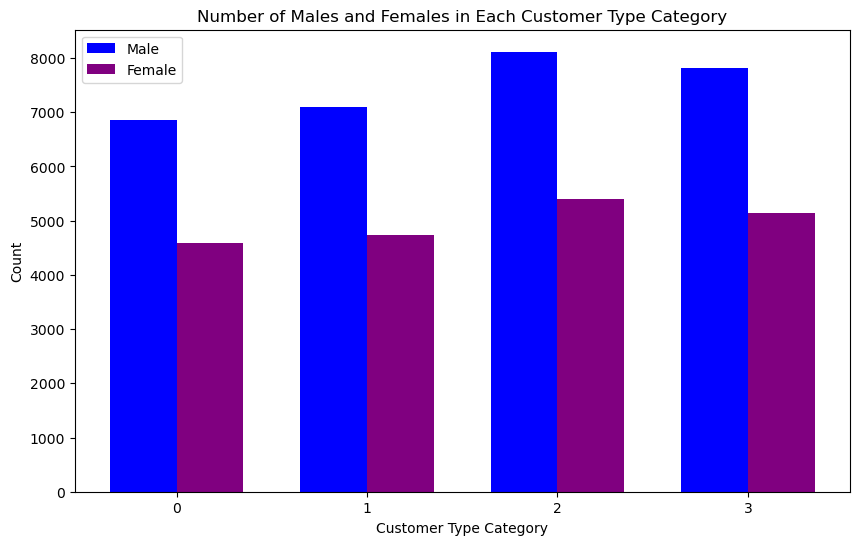

In [34]:
# Customer Type by Gender

bar_width = 0.35  
categories = gender_counts.index
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, gender_counts[0], bar_width, label='Male', color='blue')
bar2 = ax.bar(index + bar_width, gender_counts[1], bar_width, label='Female', color='purple')

ax.set_xlabel("Customer Type Category")
ax.set_ylabel("Count")
ax.set_title("Number of Males and Females in Each Customer Type Category")
ax.set_xticks(index + bar_width / 2) # ensures that the category labels appear between the two bars, rather than under just one
ax.set_xticklabels(categories)
ax.legend()

plt.show()

In [35]:
# Customer Type by Age

bins= [6, 18, 28, 38, 50, 81] 
labels= ['6-17', '18-27', '28-37', '38-49', '50-80']
basetable_summer['age_group'] = pd.cut(basetable_summer['Age'], bins=bins, labels=labels)

In [36]:
age_counts= basetable_summer.groupby(['CustomerType', 'age_group']).size().unstack()
age_counts

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\1140471080.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


age_group     6-17  18-27  28-37  38-49  50-80
CustomerType                                  
0             2897   3134   3370   1342    568
1             3079   3272   3438   1335    591
2             3376   3730   4039   1566    669
3             3235   3551   3873   1530    631

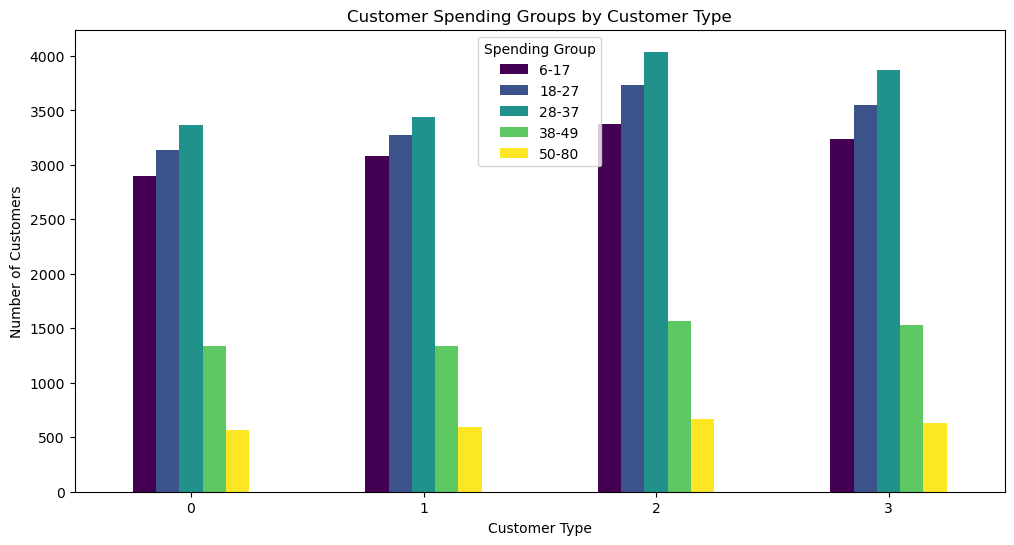

In [37]:
age_counts.plot(kind='bar', figsize=(12, 6), colormap='viridis')

plt.xlabel("Customer Type")
plt.ylabel("Number of Customers")
plt.title("Customer Spending Groups by Customer Type")
plt.legend(title="Spending Group")
plt.xticks(rotation=0)  # Keeps labels readable
plt.show()

## 1.3) Calculate the customer lifetime value for these customers. You can make assumptions for unknown variables (e.g., discount rate, # periods in the future)

In [38]:
# Initial CLV calculation for basetable summer
CLV_summer = basetable_summer[['CustomerID', 'MonetaryValue']]
AC = 1
Discount_rate = 0.085
periods = 3
retention_rate_fall= len(pd.unique(fallsesstrx['CustomerID']))/ len(pd.unique(summersesstrx['CustomerID']))

def calc_clv(margin, r, d, acquisition,t):
    clv=-acquisition
    for i in range(0,t+1):
         clv=clv+(pow(r,i)*margin)/(pow((1+d),i))
    return(clv)

clv_values = []

for index, row in CLV_summer.iterrows():
  row['CLV'] = calc_clv(margin=row['MonetaryValue'], r=retention_rate_fall, d=Discount_rate, acquisition=AC, t=periods)
  clv_values.append(row['CLV'])

CLV_summer['CLV'] = clv_values

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\1555933776.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
CLV_summer

CustomerID  MonetaryValue       CLV
0               1           0.00  -1.00000
1               2           0.00  -1.00000
2               3           0.00  -1.00000
3               4           4.99  14.53648
4               5           0.00  -1.00000
...           ...            ...       ...
49758       49996           0.00  -1.00000
49759       49997           0.00  -1.00000
49760       49998           9.98  30.07296
49761       49999           0.00  -1.00000
49762       50000           0.00  -1.00000

[49763 rows x 3 columns]

In [40]:
CLV_summer['CLV'].describe()

count    49763.000000
mean        11.415286
std         33.278668
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          8.309434
max        662.118149
Name: CLV, dtype: float64

In [41]:
round(CLV_summer['CLV'].sum(),2)

568058.87

# LifeCycle Grids

## Customer Type, Spending Category, Registration Cohorts, Spending vs no spending

In [42]:
# We start by creating dictionaries for organization and readability 

dates = {
    'summerstart' : pd.to_datetime('2022-05-01'),
    'summerend' : pd.to_datetime('2022-08-31'),
    'fallstart' : pd.to_datetime('2022-09-01'),
    'fallend' : pd.to_datetime('2022-12-31')
    }

data = {
        'customerdata' : pd.read_csv('customerdata.csv',parse_dates=['Registrationdate']),
        'summerfintrx' : pd.read_csv('summerfintrx.csv',parse_dates=['Date']),
        'summersesstrx' : pd.read_csv('summersesstrx.csv',parse_dates=['Date']),
        'fallfintrx' : pd.read_csv('fallfintrx.csv',parse_dates=['Date']),
        'fallsesstrx' : pd.read_csv('fallsesstrx.csv',parse_dates=['Date'])
        }



#convert datetime to date (we don't need the hour)
data['summerfintrx']['Date'] = pd.to_datetime(data['summerfintrx']['Date'])
data['summersesstrx']['Date'] = pd.to_datetime(data['summersesstrx']['Date'])
data['fallfintrx']['Date'] = pd.to_datetime(data['fallfintrx']['Date'])
data['fallsesstrx']['Date'] = pd.to_datetime(data['fallsesstrx']['Date'])
data['customerdata']['Registrationdate'] = pd.to_datetime(data['customerdata']['Registrationdate'])

In [43]:
analysis = {
    'active_summer' : data['summersesstrx'].groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                         recency = ('Date', lambda date: (dates['summerend'] - date.max()).days))
    }

analysis['active_summer']['recency'] = analysis['active_summer']['recency'].astype(int)

basetable = {
    'summer' : analysis['active_summer'].merge(data['customerdata'], how='inner', left_on = 'CustomerID', right_on = 'CustomerID')
    }

analysis['summerfin'] = data['summerfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))

basetable['summer'] = basetable['summer'].merge(analysis['summerfin'], how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable['summer'].fillna(0, inplace=True)

fallbonus = {
    'num' : basetable['summer']['fallbonus'].sum()}

analysis['active_fall']=data['fallsesstrx'].groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                     recency = ('Date', lambda date: (dates['fallend'] - date.max()).days))
analysis['active_fall']['recency'] = analysis['active_fall']['recency'].astype(int)

basetable['fall'] = analysis['active_fall'].merge(data['customerdata'], how='inner', left_on = 'CustomerID', right_on = 'CustomerID')

analysis['fallfin'] = data['fallfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))
basetable['fall'] = basetable['fall'].merge(analysis['fallfin'], how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable['fall'].fillna(0, inplace=True)

CLV = {
       'summer' : basetable['summer'][['CustomerID', 'MonetaryValue']],
       'AC' : 1,
       'Discount_rate' : 0.085,
       'periods' : 3
       }


analysis['retention for fall']= len(pd.unique(data['fallsesstrx']['CustomerID']))/ len(pd.unique(data['summersesstrx']['CustomerID']))

In [44]:
analysis

{'active_summer':        CustomerID  frequency  recency
 0               1          6        9
 1               2         10        8
 2               3          4       50
 3               4          9       11
 4               5          6       52
 ...           ...        ...      ...
 49758       49996         10        3
 49759       49997         10       16
 49760       49998          6       22
 49761       49999          9        1
 49762       50000         10        9
 
 [49763 rows x 3 columns],
 'summerfin':        CustomerID  MonetaryValue
 0               4           4.99
 1               8           2.99
 2               9           4.99
 3              24          34.99
 4              30           9.99
 ...           ...            ...
 17165       49983           4.99
 17166       49992           9.99
 17167       49993           8.97
 17168       49995           2.99
 17169       49998           9.98
 
 [17170 rows x 2 columns],
 'active_fall':        CustomerID  f

In [45]:
# Define again the function for clv calculation
def calc_clv(margin, r, d, acquisition,t):
    clv=-acquisition
    for i in range(0,t+1):
         clv=clv+(pow(r,i)*margin)/(pow((1+d),i))
    return(clv)

In [46]:
# We parse the clv value for each player in a new column in the "analysis" dictionary
analysis['CLV_values'] = []

for index, row in CLV['summer'].iterrows():
  row['CLV'] = calc_clv(margin=row['MonetaryValue'], r=analysis['retention for fall'], d=CLV['Discount_rate'], acquisition=CLV['AC'], t=CLV['periods'])
  analysis['CLV_values'].append(row['CLV'])

# Delete the index and row variables
del index, row

CLV['summer']['Values'] = analysis['CLV_values']

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\1675168161.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


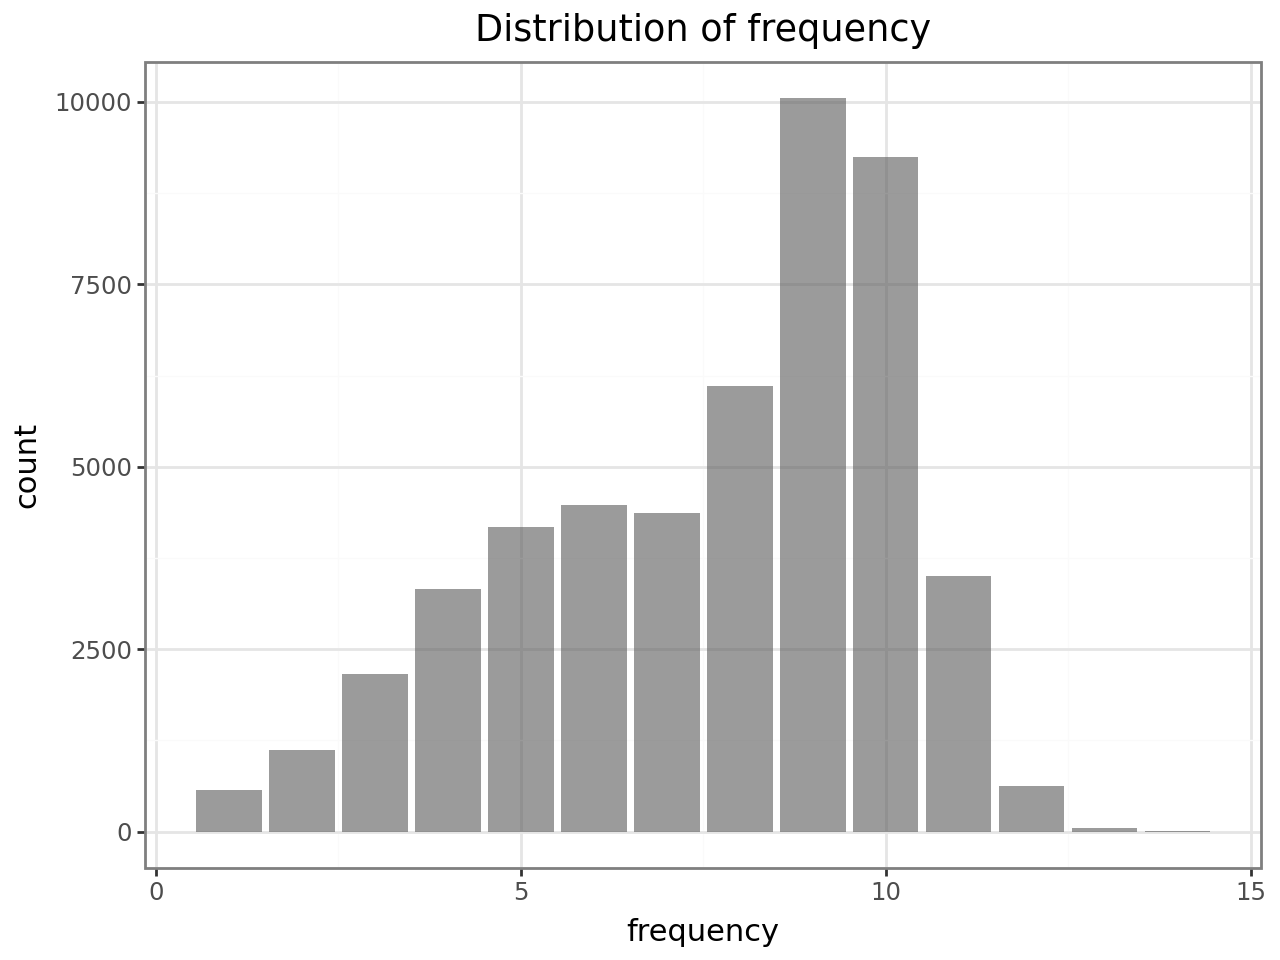

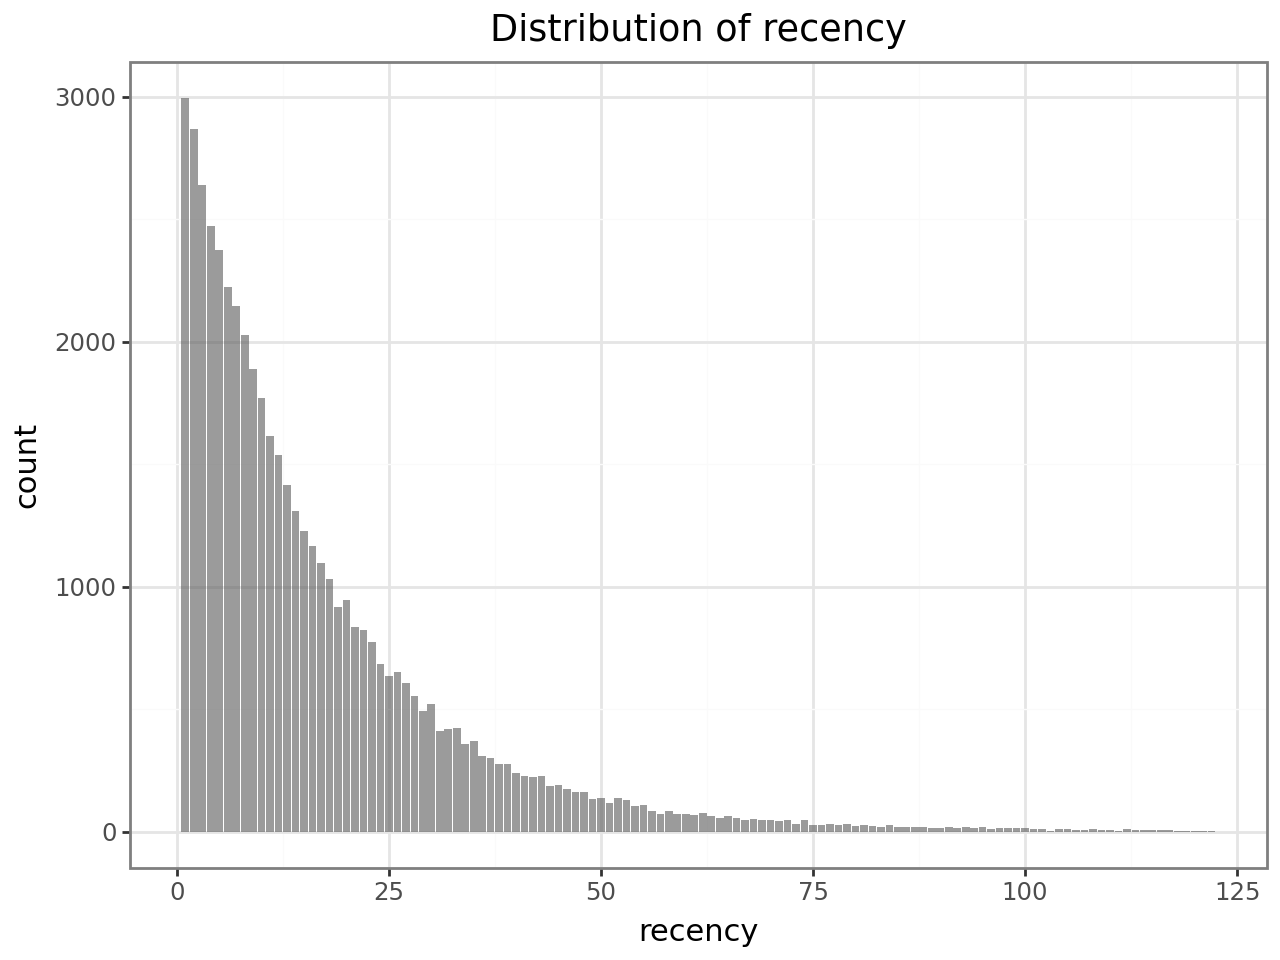

In [47]:
# Some plots to visualize frequency and recency
histograms = {
    'histfreq' : (ggplot(basetable['summer'], aes(x='frequency')) +
      theme_bw() +
      scale_x_continuous() +
      geom_bar(alpha=0.6) +
      ggtitle("Distribution of frequency")),

    'histrec' : (ggplot(basetable['summer'], aes(x='recency')) +
      theme_bw() +
      geom_bar(alpha=0.6) +
      ggtitle("Distribution of recency"))
    }

histograms['histfreq'].show()
histograms['histrec'].show()

In [48]:
# Create a new dictionary to store the basetable summer along with new segmented columns that we will use for the grids
segmented = {
    'summer_custsegm' : basetable['summer'].assign(
        segmfreq=lambda x: pd.cut(x['frequency'],
                                                  bins=[0,3,5,7,9,10,99],
                                                  labels=["1", "3", "5","7",'9','>10']),
        segmrec=lambda x: pd.cut(x['recency'],
                                                  bins=[0,4,9,15,30,50,150],
                                                  labels=["0-4 days", "5-9 days", "10-15 days","16-30 days","31-50 days",">50 days"]),
        segmage=lambda x: pd.cut(x['Age'],
                                  bins= [6, 18, 28, 38, 50, 81],
                                  labels= ['6-17', '18-27', '28-37', '38-49', '50-80']),
        spending_cat= lambda x: pd.cut(x['MonetaryValue'],
                                  bins= [-1, 10, 50, 100, 200, float('inf')],
                                  labels= ['VL', 'L','M', 'H', 'VH']),
        cohort=lambda x: x['Registrationdate'].dt.year,
        spending=lambda x: np.where(x['MonetaryValue'] == 0, 0, 1))
    }

#convert to factor and reverse the order
segmented['summer_custsegm']['segmfreq']=pd.Categorical(segmented['summer_custsegm']['segmfreq'], categories=['>10','9','7','5','3',"1"])
segmented['summer_custsegm']['segmrec']=pd.Categorical(segmented['summer_custsegm']['segmrec'], categories=[">50 days","31-50 days","16-30 days", "10-15 days", "5-9 days","0-4 days"])

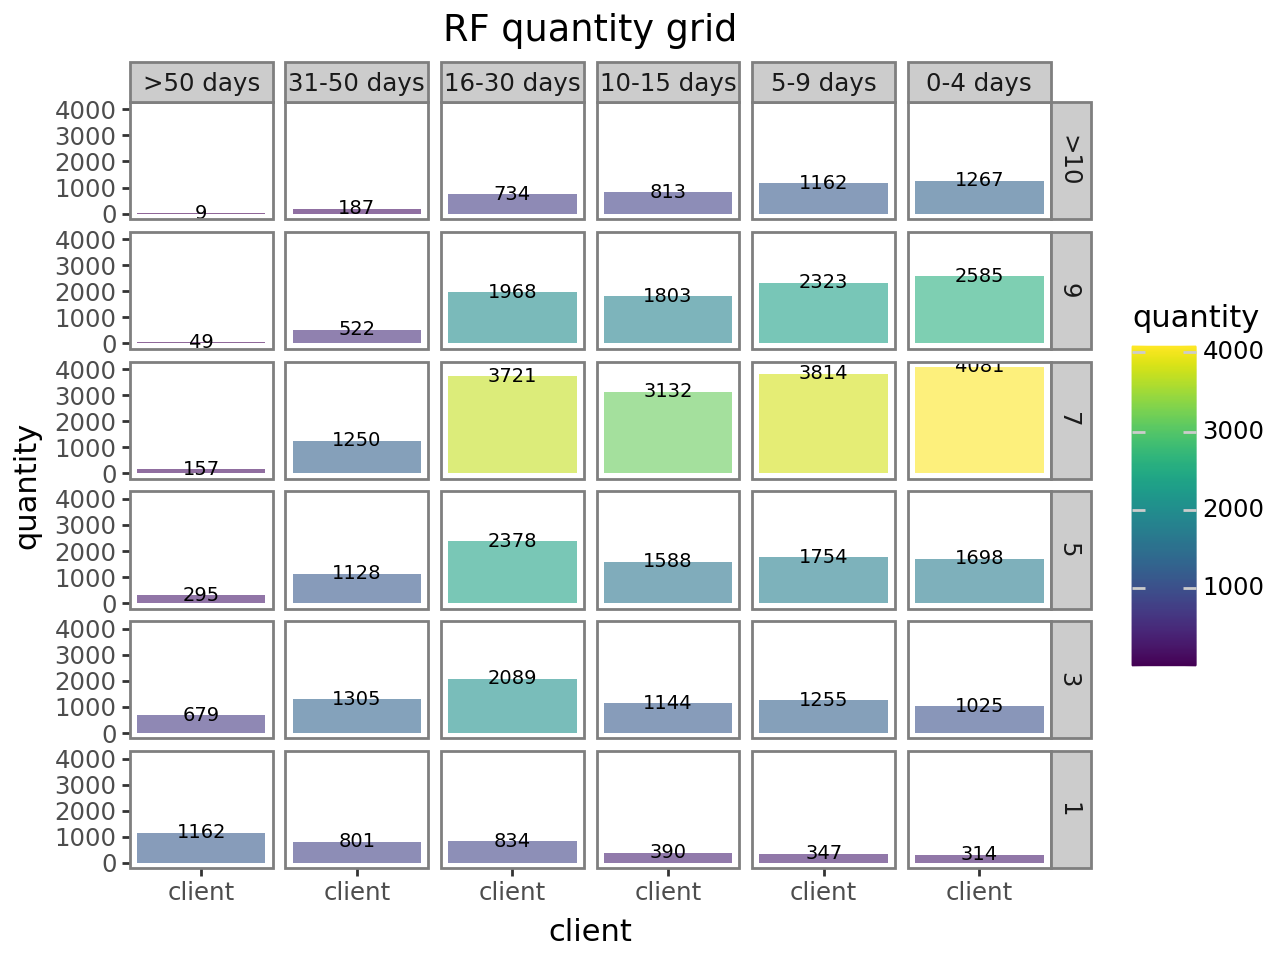

In [49]:
#RF quantity grid
Grids_data = {
    'lcg' : segmented['summer_custsegm'].groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(
        quantity=('CustomerID','count'),
        monetaryvalue=('MonetaryValue','sum'))
    }

Grids_data['lcg']['client']='client'

Grids= {"RF quantity grid" : (ggplot(Grids_data['lcg'], aes(x='client', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='quantity', label='quantity'), size=7) +#display the quantity label at the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RF quantity grid"))
        }
Grids['RF quantity grid'].show()

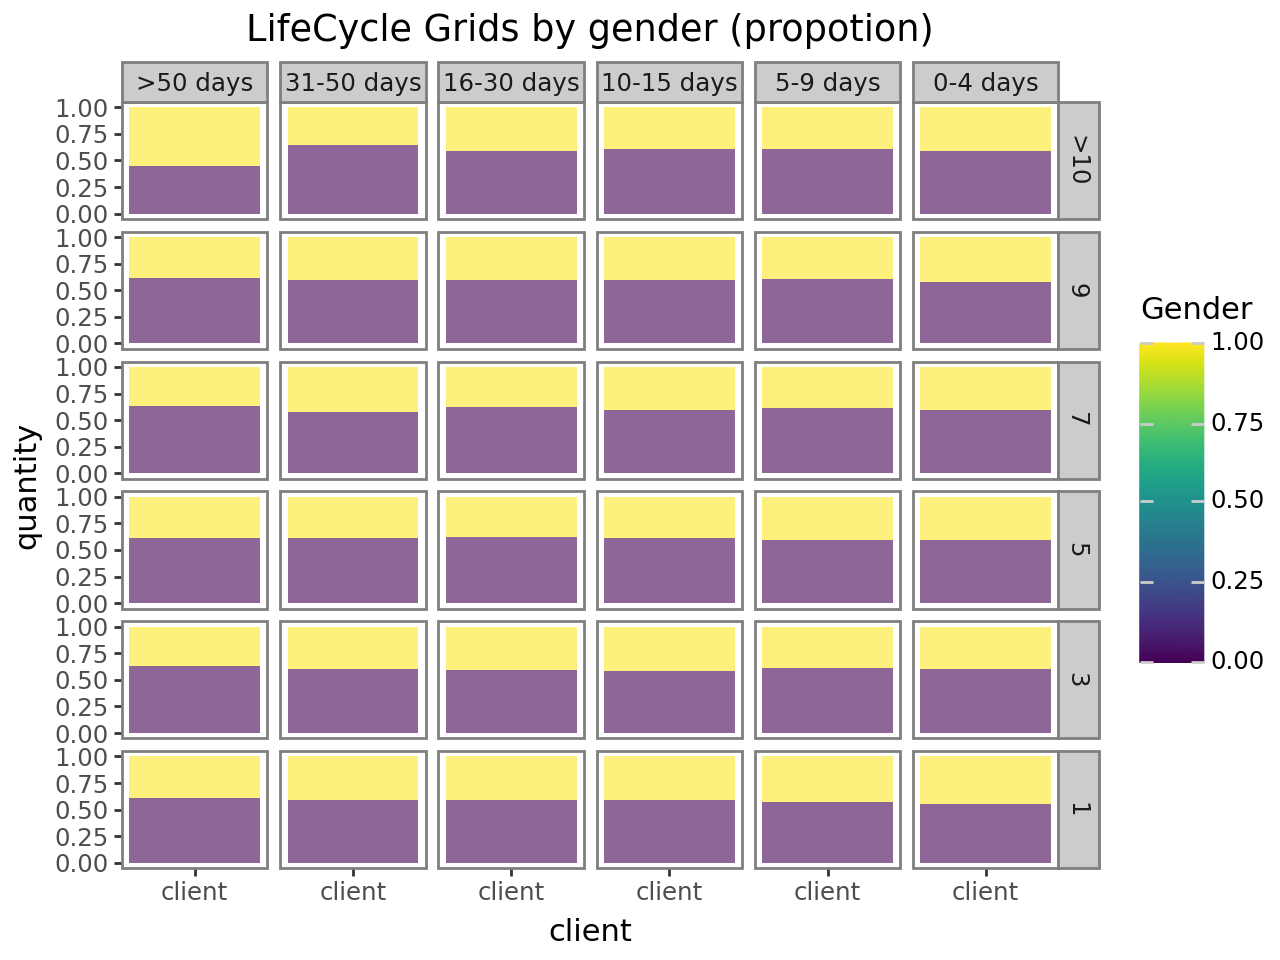

In [50]:
# RF by Gender
Grids_data['lcgsub']=segmented['summer_custsegm'].groupby(
    ['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(
        quantity=('CustomerID','count'),
        monetaryvalue=('MonetaryValue','sum'))
Grids_data['lcgsub']['client']='client'

Grids["LifeCycle Grids by gender (propotion)"]=(
    ggplot(Grids_data['lcgsub'], aes(x='client', y='quantity',fill='Gender'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity',position='fill', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by gender (propotion)"))

Grids["LifeCycle Grids by gender (propotion)"].show()

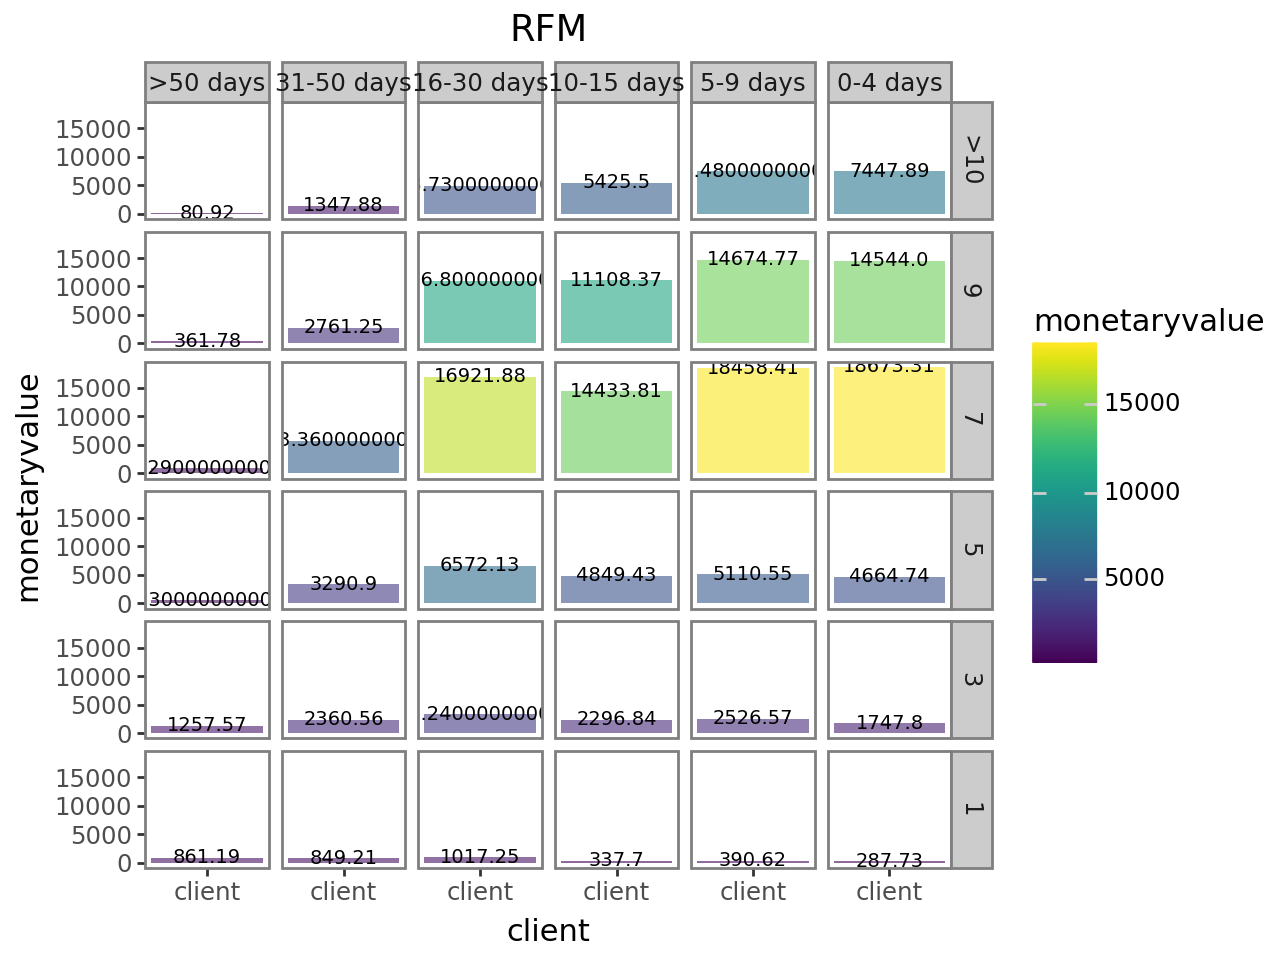

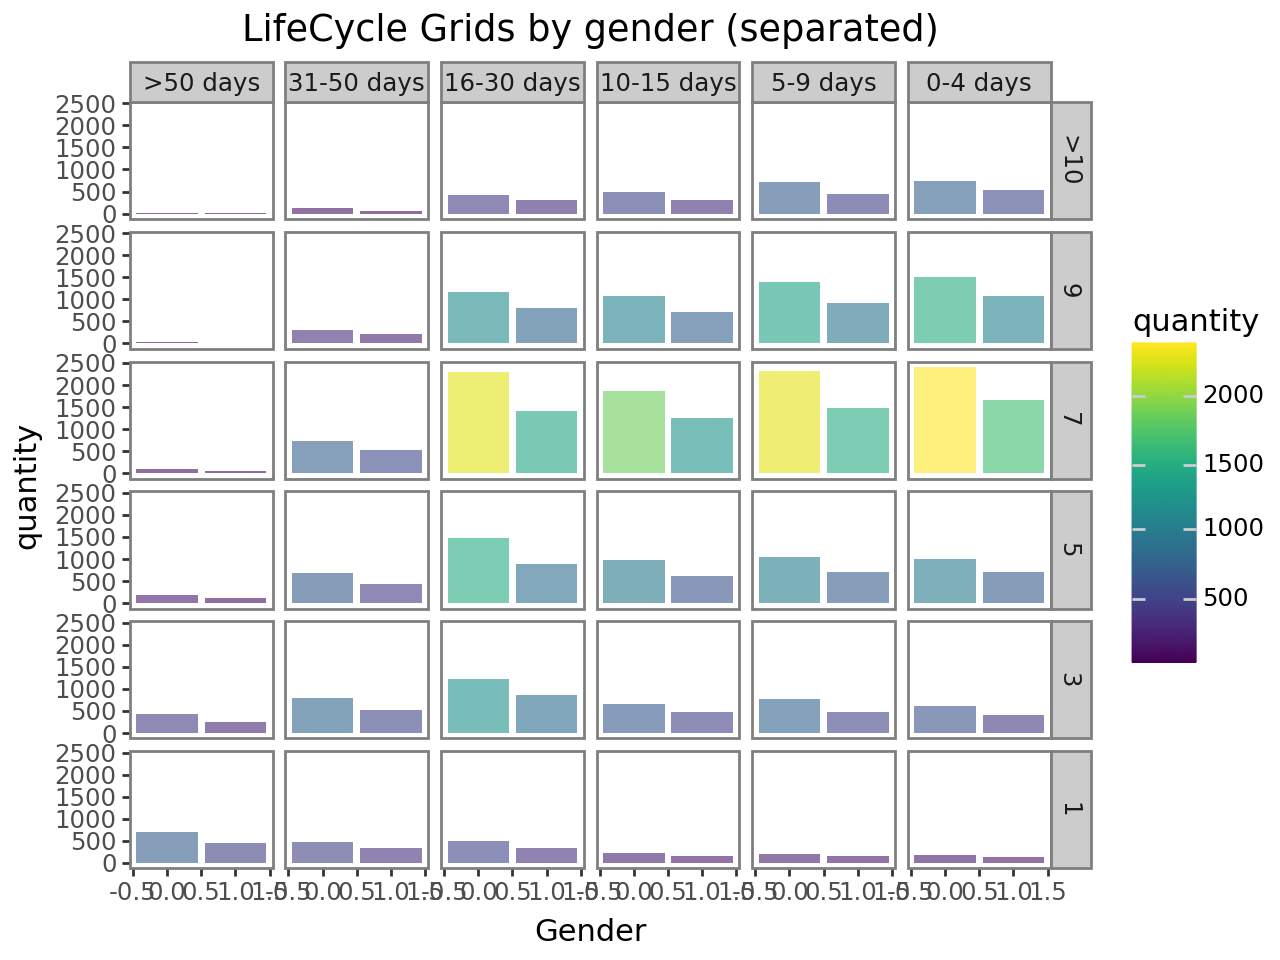

In [51]:
# RFM
Grids_data['lcgmv']=segmented['summer_custsegm'].groupby(
    ['segmfreq','segmrec'],observed=True, as_index=False).agg(
        monetaryvalue=('MonetaryValue','sum'))
Grids_data['lcgmv']['client'] = 'client'

Grids["RFM grid"] = (
    ggplot(Grids_data['lcgmv'], aes(x='client', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='monetaryvalue', label='monetaryvalue'), size=7) +#display the quantity label at the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RFM"))

Grids['RFM grid'].show()

Grids["LifeCycle Grids by gender (separated)"]=(
    ggplot(Grids_data['lcgsub'], aes(x='Gender', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by gender (separated)"))

Grids["LifeCycle Grids by gender (separated)"].show()

In [52]:
# to save grids return these lines to code instead of comment
#for grid in Grids:
    #Grids[grid].save(filename=grid, height=15, width=15, units = 'in', dpi= 1000)

In [53]:
segmented['summer_custsegm']['frequency'].describe()

segmented['summer_custsegm'].to_csv('basetable_summer.csv')

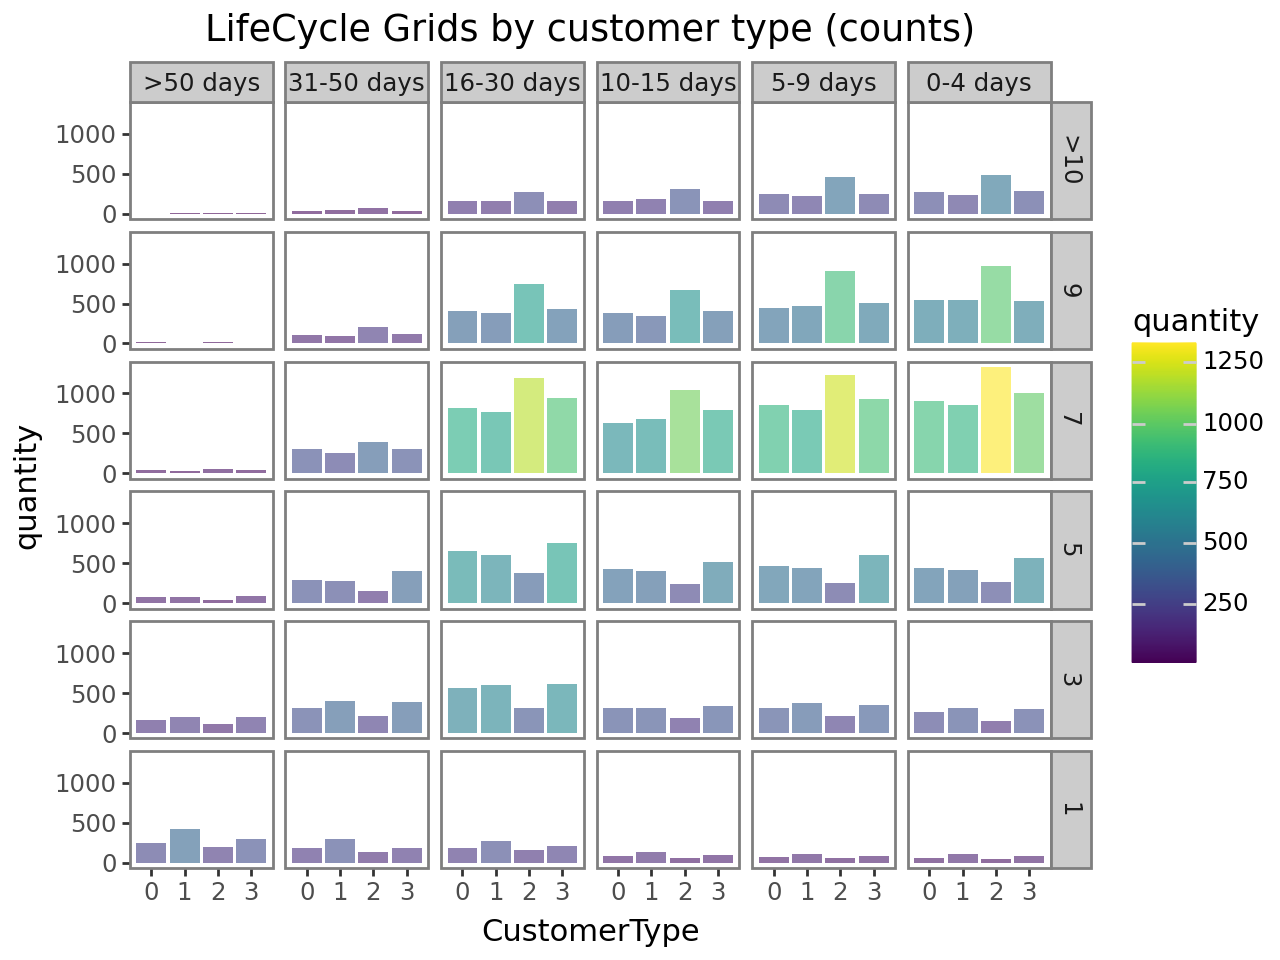

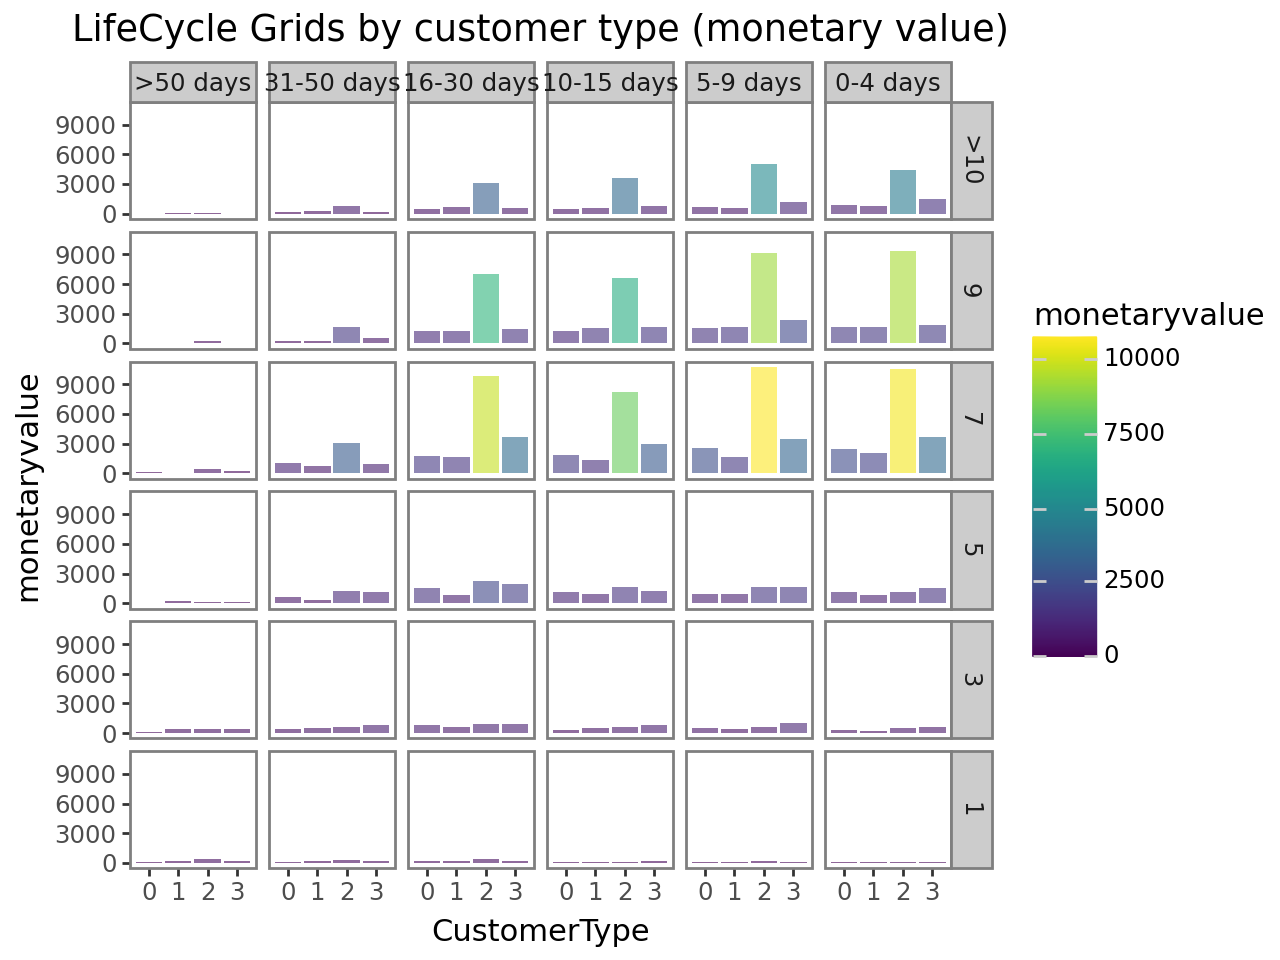

In [54]:
#RF customer type grid
Grids_data ['lcg_age'] = segmented['summer_custsegm'].groupby(['segmfreq','segmrec','segmage'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))

Grids_data['lcg_custtype'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'CustomerType'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'),
    monetaryvalue=('MonetaryValue','sum'))

Grids["LifeCycle Grids by customer type (counts)"]=(
    ggplot(Grids_data['lcg_custtype'], aes(x='CustomerType', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by customer type (counts)"))

Grids["LifeCycle Grids by customer type (counts)"].show()

Grids["LifeCycle Grids by customer type (monetary value)"]=(
    ggplot(Grids_data['lcg_custtype'], aes(x='CustomerType', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by customer type (monetary value)"))

Grids["LifeCycle Grids by customer type (monetary value)"].show()

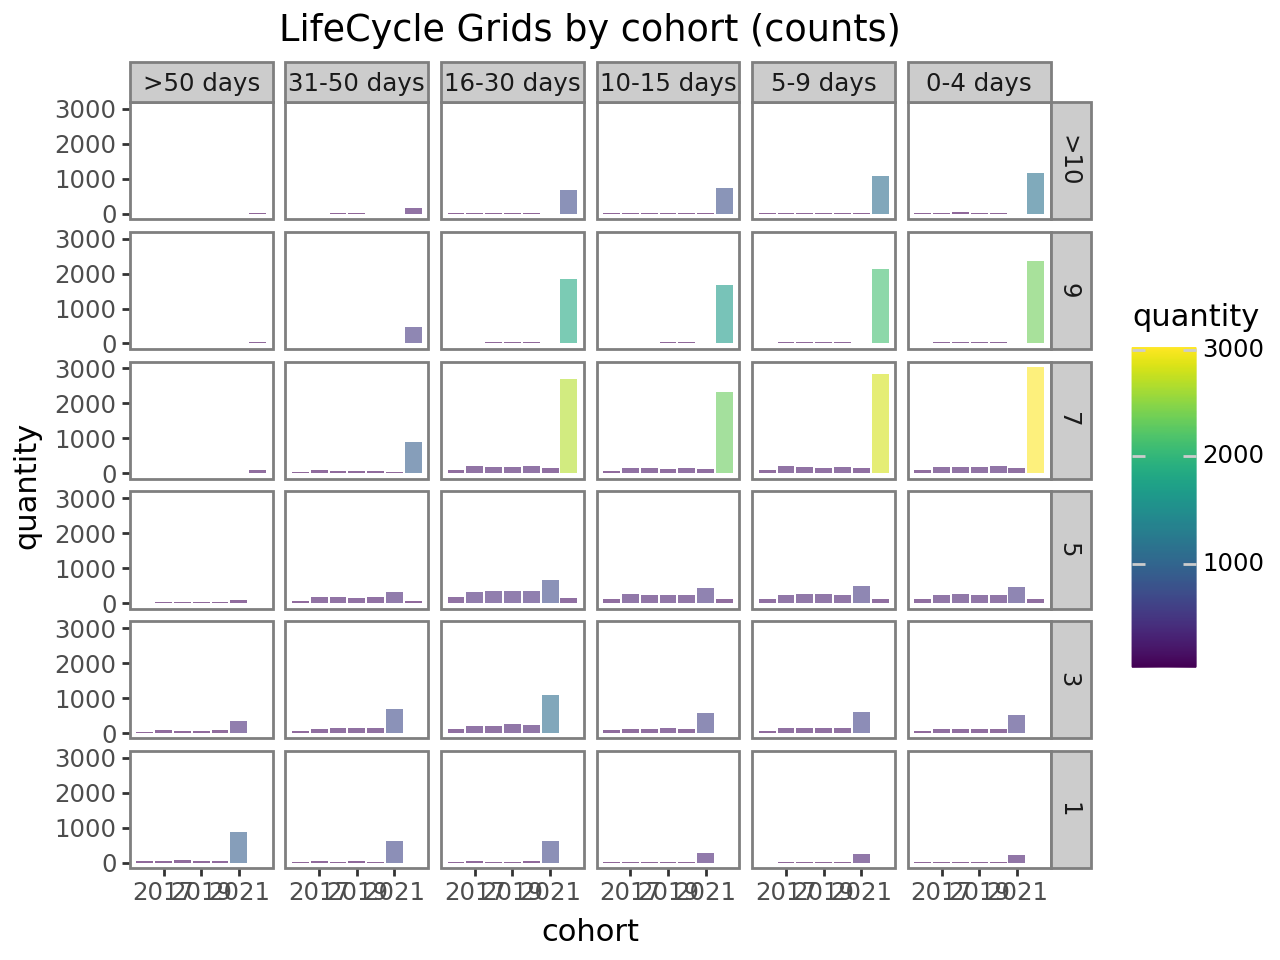

In [55]:
# RF by cohorts
Grids_data['lcg_cohorts'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'cohort'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'),
    monetaryvalue=('MonetaryValue','sum'))

Grids["LifeCycle Grids by cohort (counts)"]=(
    ggplot(Grids_data['lcg_cohorts'], aes(x='cohort', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by cohort (counts)"))

Grids["LifeCycle Grids by cohort (counts)"].show()

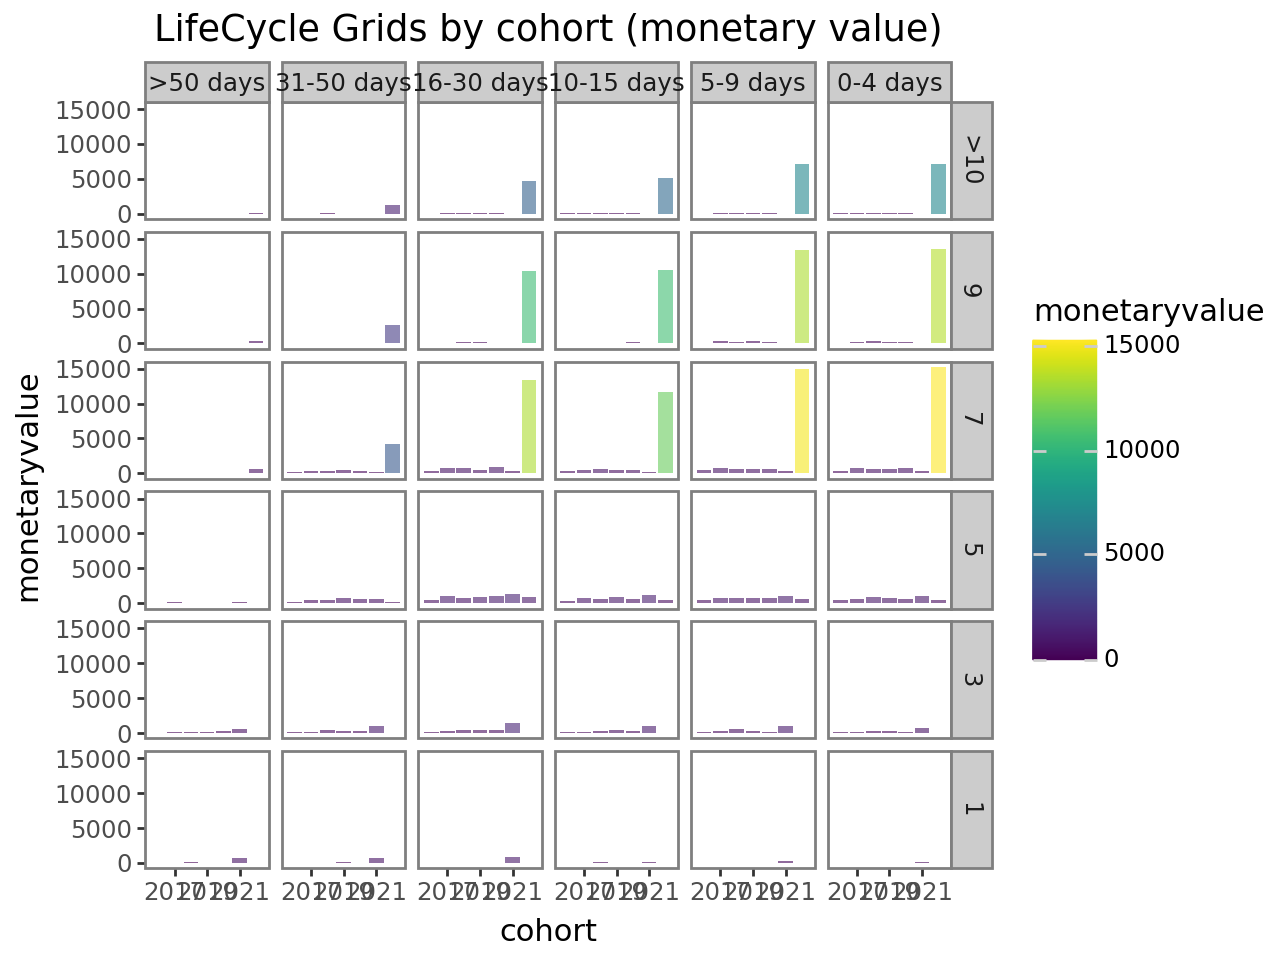

In [56]:
Grids["LifeCycle Grids by cohort (monetary value)"]=(
    ggplot(Grids_data['lcg_cohorts'], aes(x='cohort', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by cohort (monetary value)"))

Grids["LifeCycle Grids by cohort (monetary value)"].show()

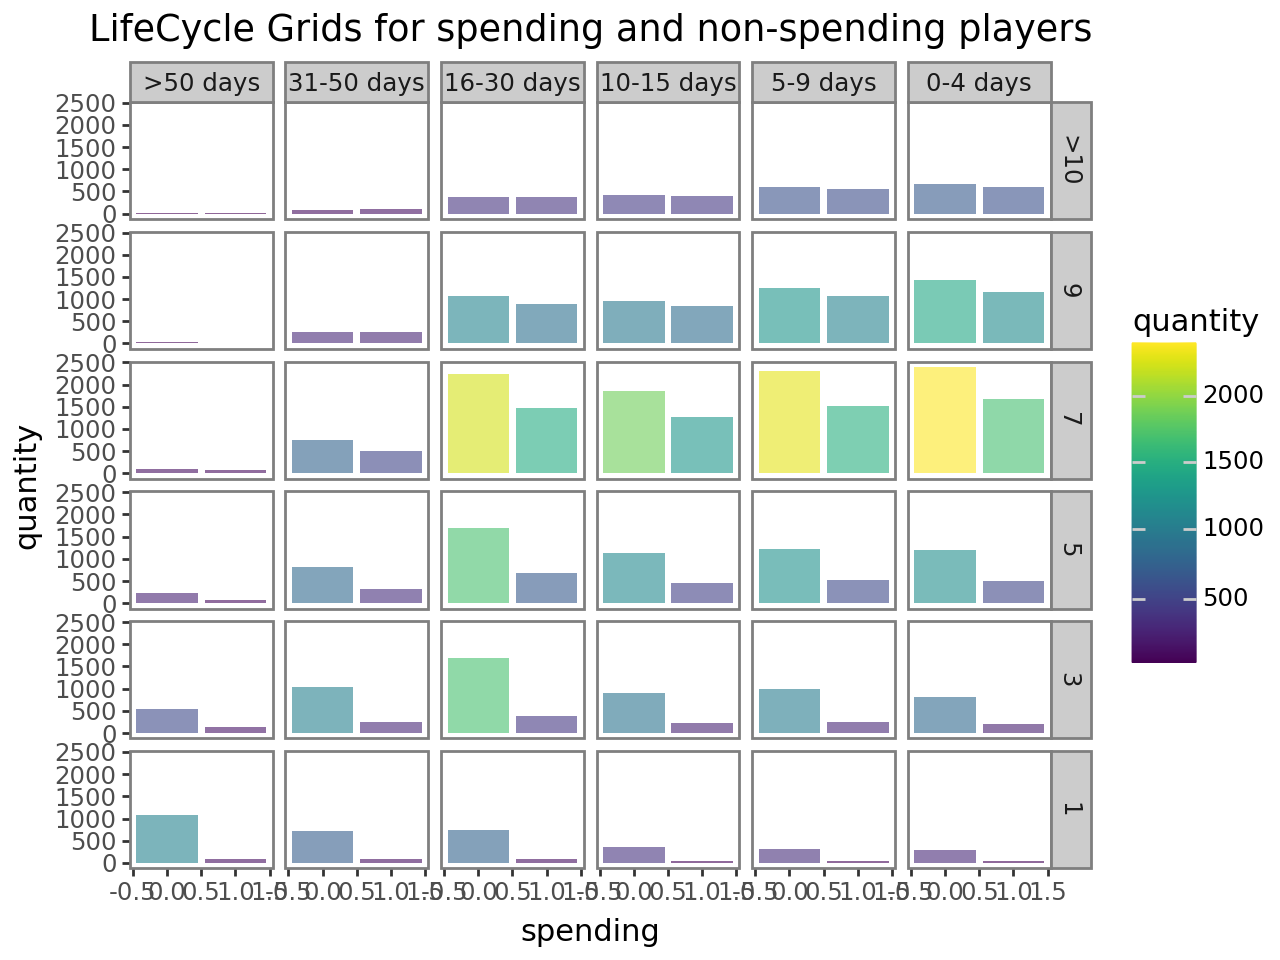

In [57]:
# RF by spending/no spending
Grids_data['lcg_spending'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'spending'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'))

Grids["LifeCycle Grids for spending and non-spending players"]=(
    ggplot(Grids_data['lcg_spending'], aes(x='spending', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids for spending and non-spending players"))

Grids["LifeCycle Grids for spending and non-spending players"].show()

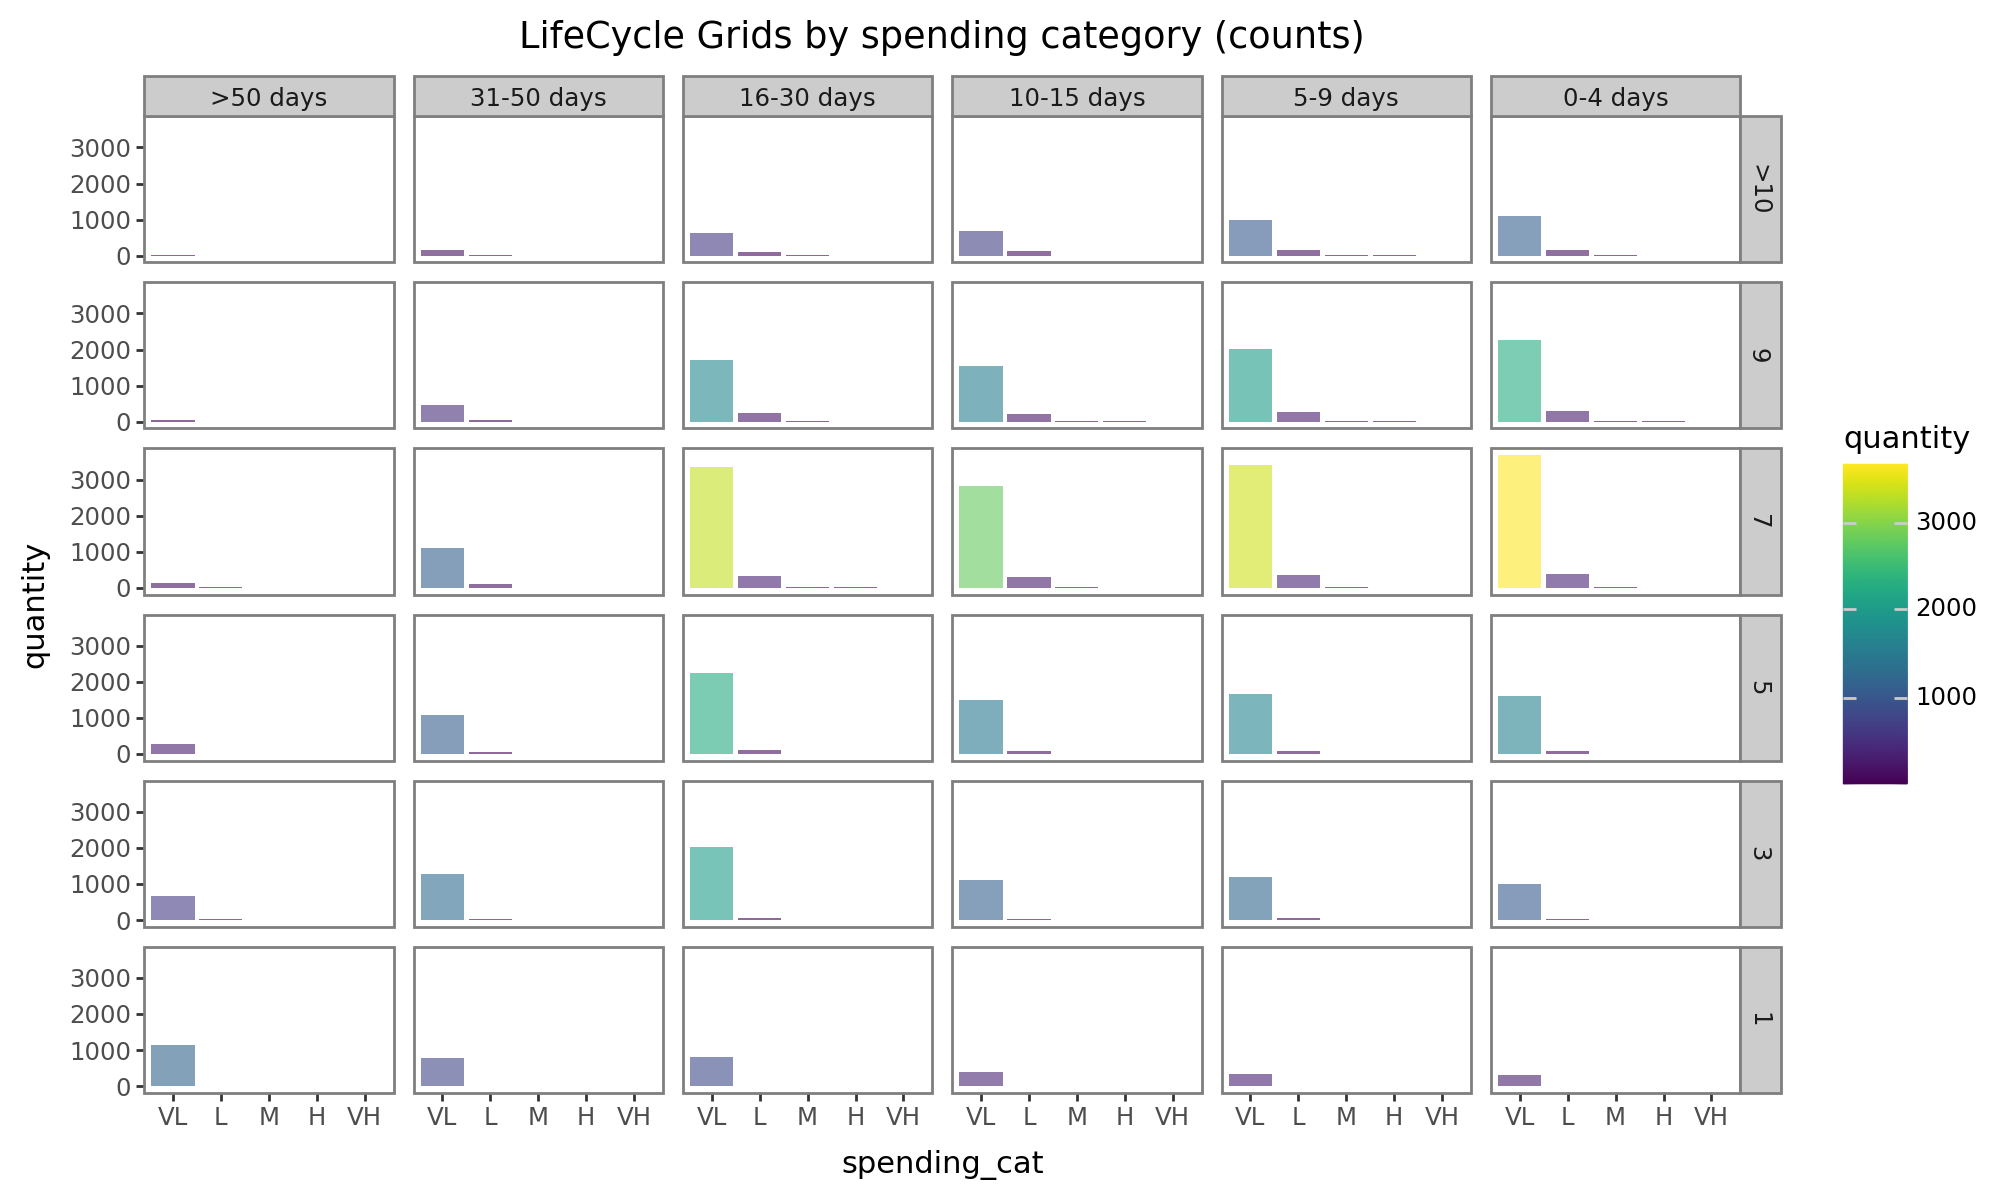

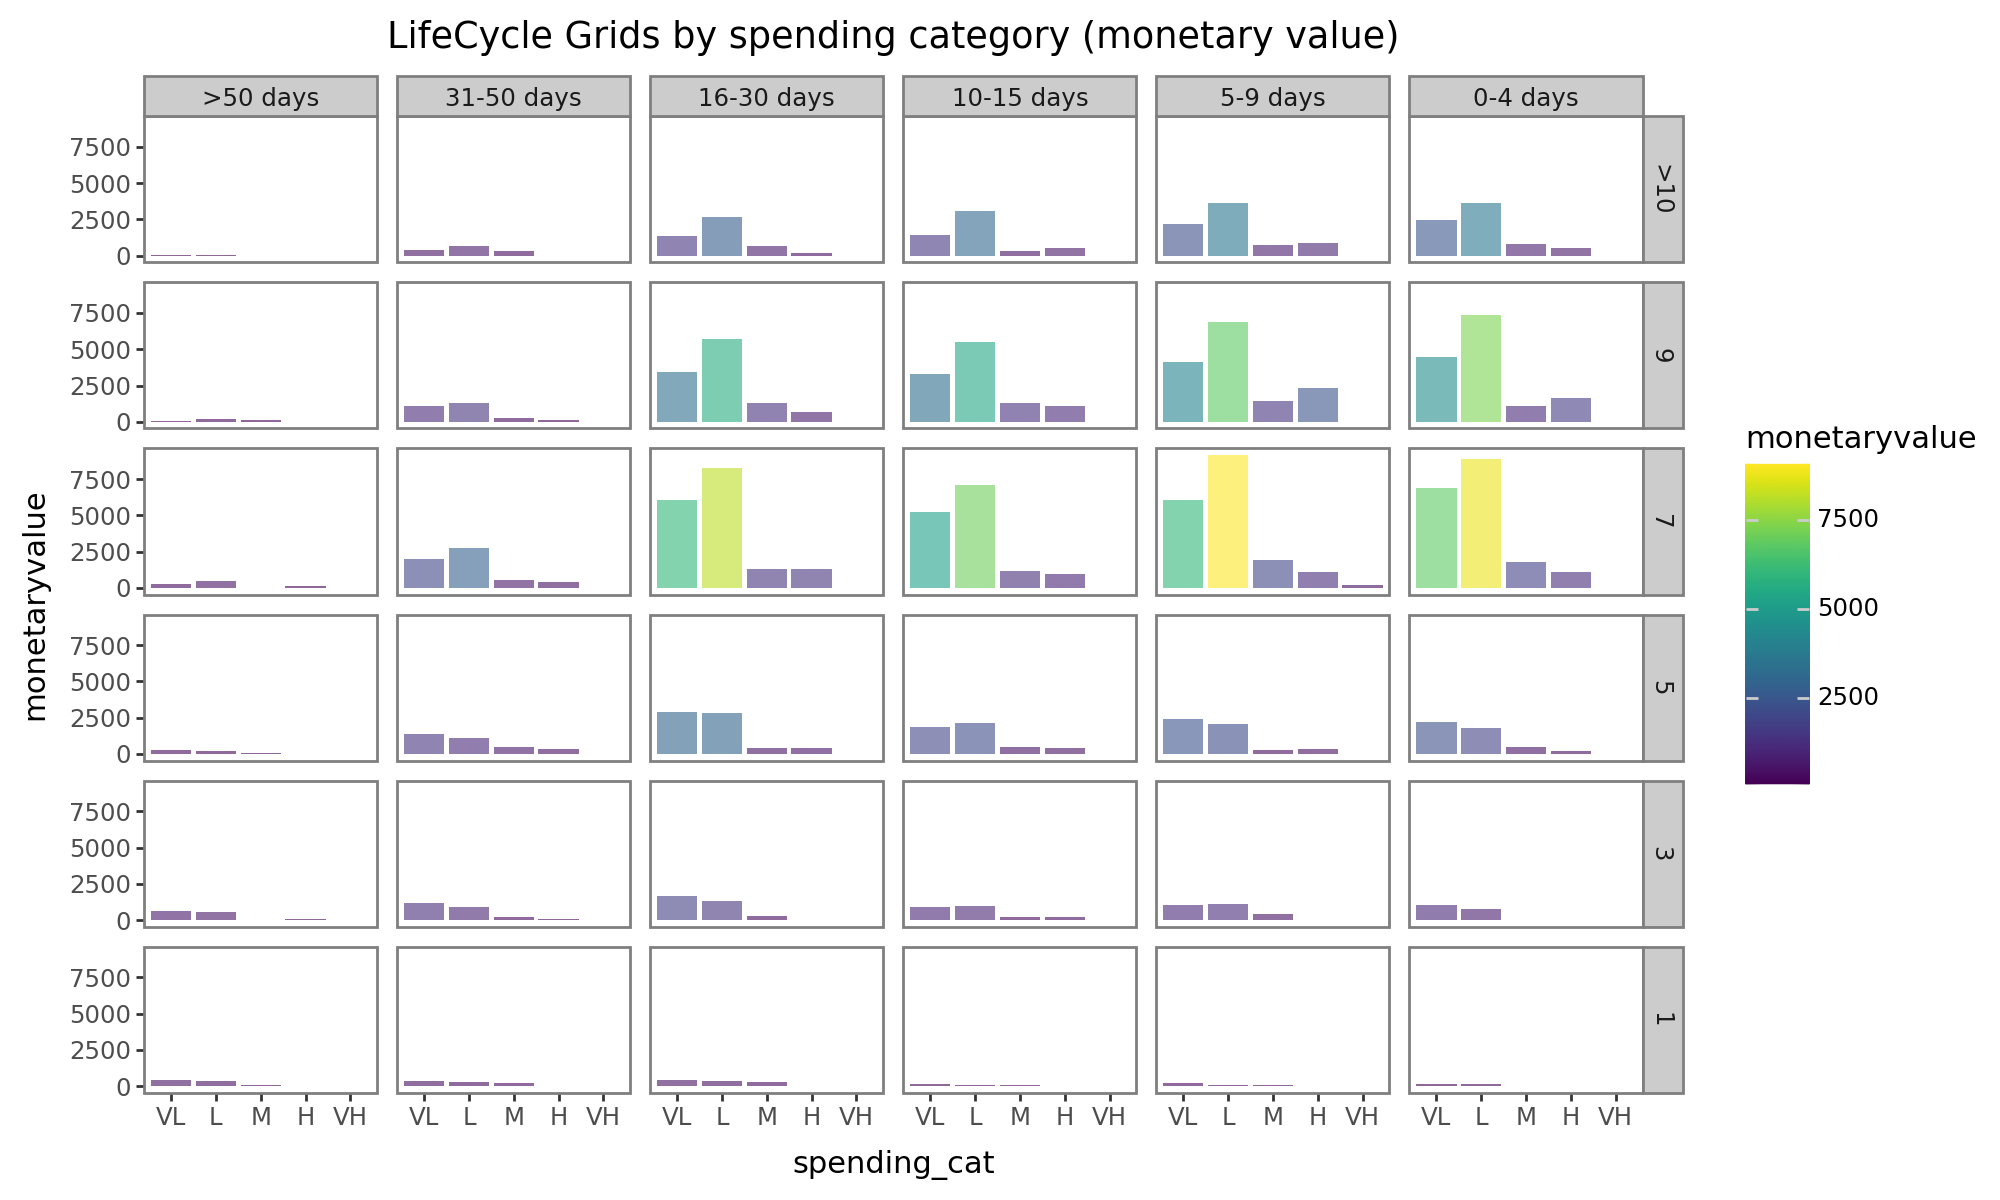

In [58]:
# RF by spending category
Grids_data['lcg_spendingcat'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'spending_cat'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'),
    monetaryvalue=('MonetaryValue','sum'))

Grids["LifeCycle Grids by spending category (counts)"]=(
    ggplot(Grids_data['lcg_spendingcat'], aes(x='spending_cat', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank(),
        figure_size=(10, 6))+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by spending category (counts)"))

Grids["LifeCycle Grids by spending category (counts)"].show()

Grids["LifeCycle Grids by spending category (monetary value)"]=(
    ggplot(Grids_data['lcg_spendingcat'], aes(x='spending_cat', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank(),
        figure_size=(10, 6))+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by spending category (monetary value)"))

Grids["LifeCycle Grids by spending category (monetary value)"].show()

# how was the fall bonus assigned? Not RFM
# basic RFM, monetary value for customer type, monetary value by spending category, fall bonus by customer type, age group by monetary value (and mean), income group by CLV, look at fall bonus by customer type,

## Gender, Age Group, Income, Fall bonus, Total Monetary Value

In [59]:
# For the rest of the grids we will create a new dataframe based on the dictionary we created before
basetable_summerC = segmented['summer_custsegm']
basetable_summerC

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue segmfreq     segmrec segmage  \
0        8          0       0           0.00        5    5-9 days    6-17   
1       45          0       2           0.00        9    5-9 days   38-49   
2       29          1       2           0.00        3  31-50 days   28-37   
3       18          0       2           4.99        7  10-15 days    6-17   
4       48          1       0           0.00        5    >50 days   38-49   
...    ...        ...     ...            ...      ...         ...     ...   
49758    9          1       0           0.00        9    0-4 days    6-17   
49759   37          0       0           0.00        9  16-30 days   28-37   
49760   27          1       1           9.98        5  16-30 days   18-27   
49761   28          0       2           0.00        7    0-4 days   18-27   
49762   26          0       0           0.00        9    5-9 days   18-27   

      spending_cat  cohort  spending  
0               VL    2021         0  
1               VL    2022         0  
2               VL    2021         0  
3               VL    2022         1  
4               VL    2021         0  
...            ...     ...       ...  
49758           VL    2022         0  
49759           VL    2022         0  
49760           VL    2018         1  
49761           VL    2020         0  
49762           VL    2022         0  

[49763 rows x 16 columns]

In [60]:
# Correctly transforming recency and frequency columns to categorical and reversing the order of the bins for better visualization
basetable_summerC['segmfreq'] = pd.Categorical(basetable_summerC['segmfreq'],
                                               categories=["1", "3", "5", "7", "9", ">10"][::-1], # reversing the order to have >10 on the top of the axis
                                               ordered=True)

basetable_summerC['segmrec'] = pd.Categorical(basetable_summerC['segmrec'],
                                              categories=["0-4 days", "5-9 days", "10-15 days", "16-30 days", "31-50 days", ">50 days"][::-1],
                                              ordered=True)

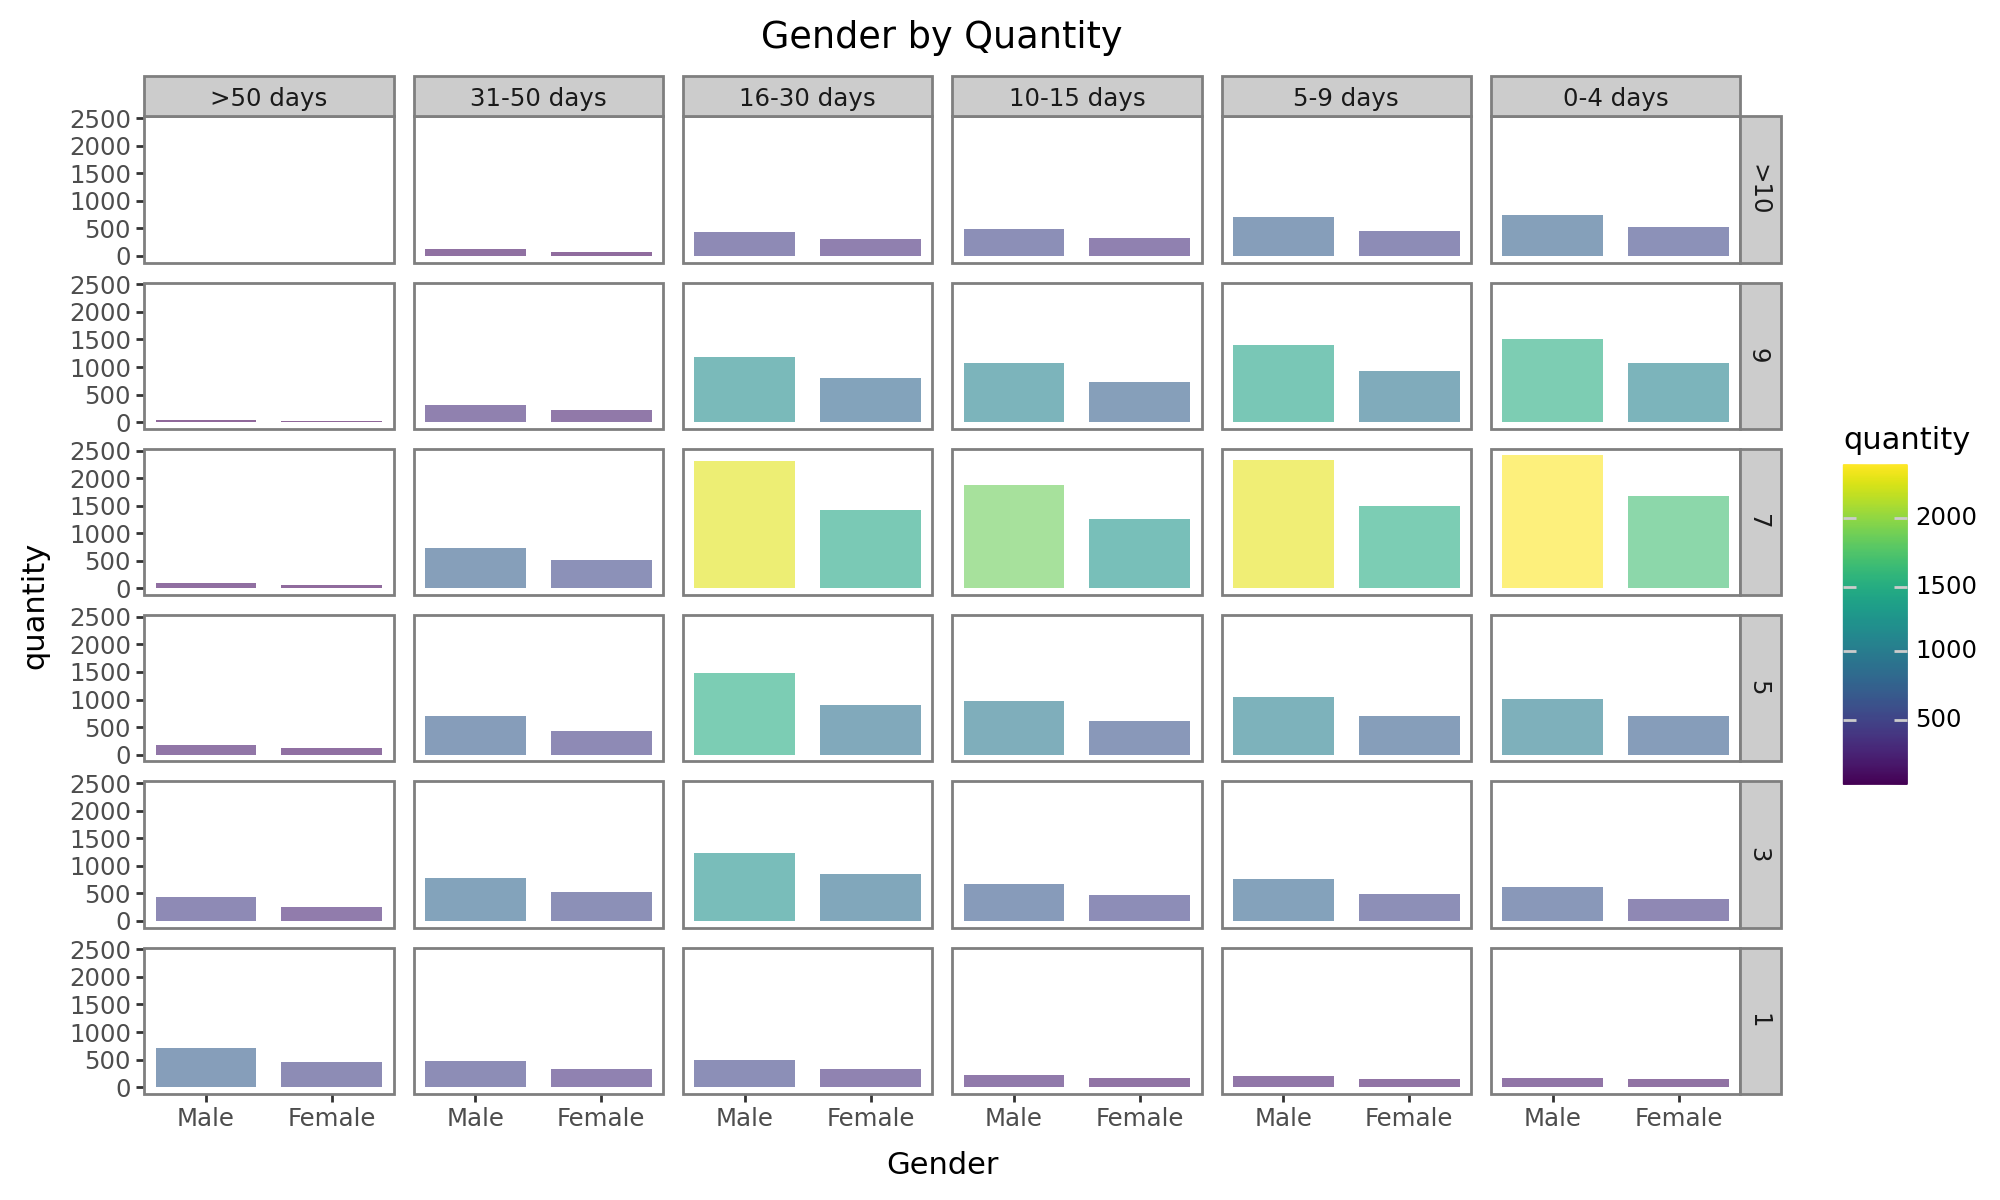

In [61]:
# Gender with Quantity

lcg1= basetable_summerC.groupby(['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg1['player']='player'

plot1 = (ggplot(lcg1, aes(x='Gender', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec', space="free_x") +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by Quantity"))

plot1.show()

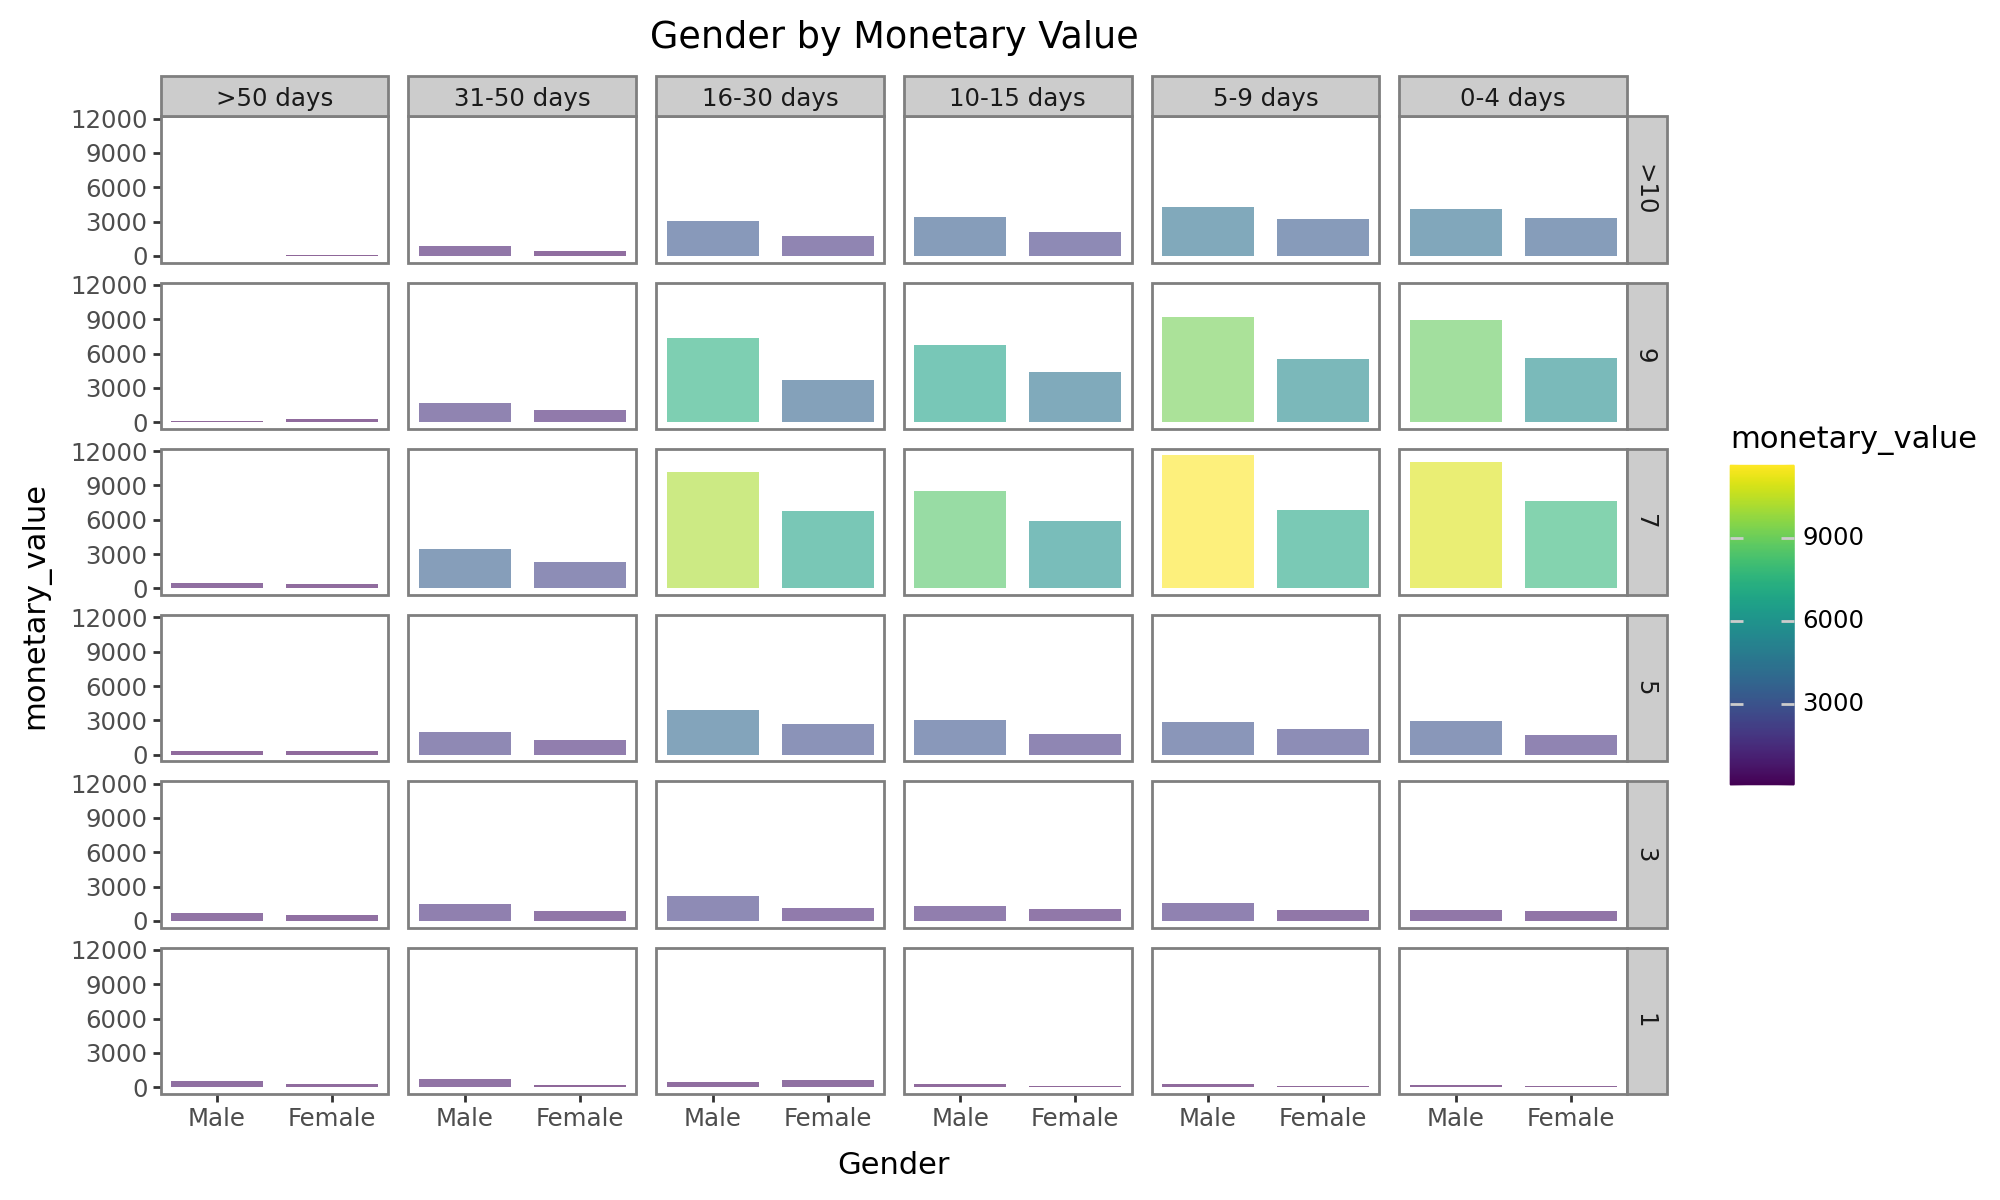

In [62]:
# Gender with Monetary Value

lcg2= basetable_summerC.groupby(['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(monetary_value=('MonetaryValue', 'sum'))
lcg2['player']='player'

plot1 = (ggplot(lcg2, aes(x='Gender', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by Monetary Value"))

plot1.show()

For each grid that contains the monetary value we will plot both the sum and the mean to obtain more information regarding spending habbits

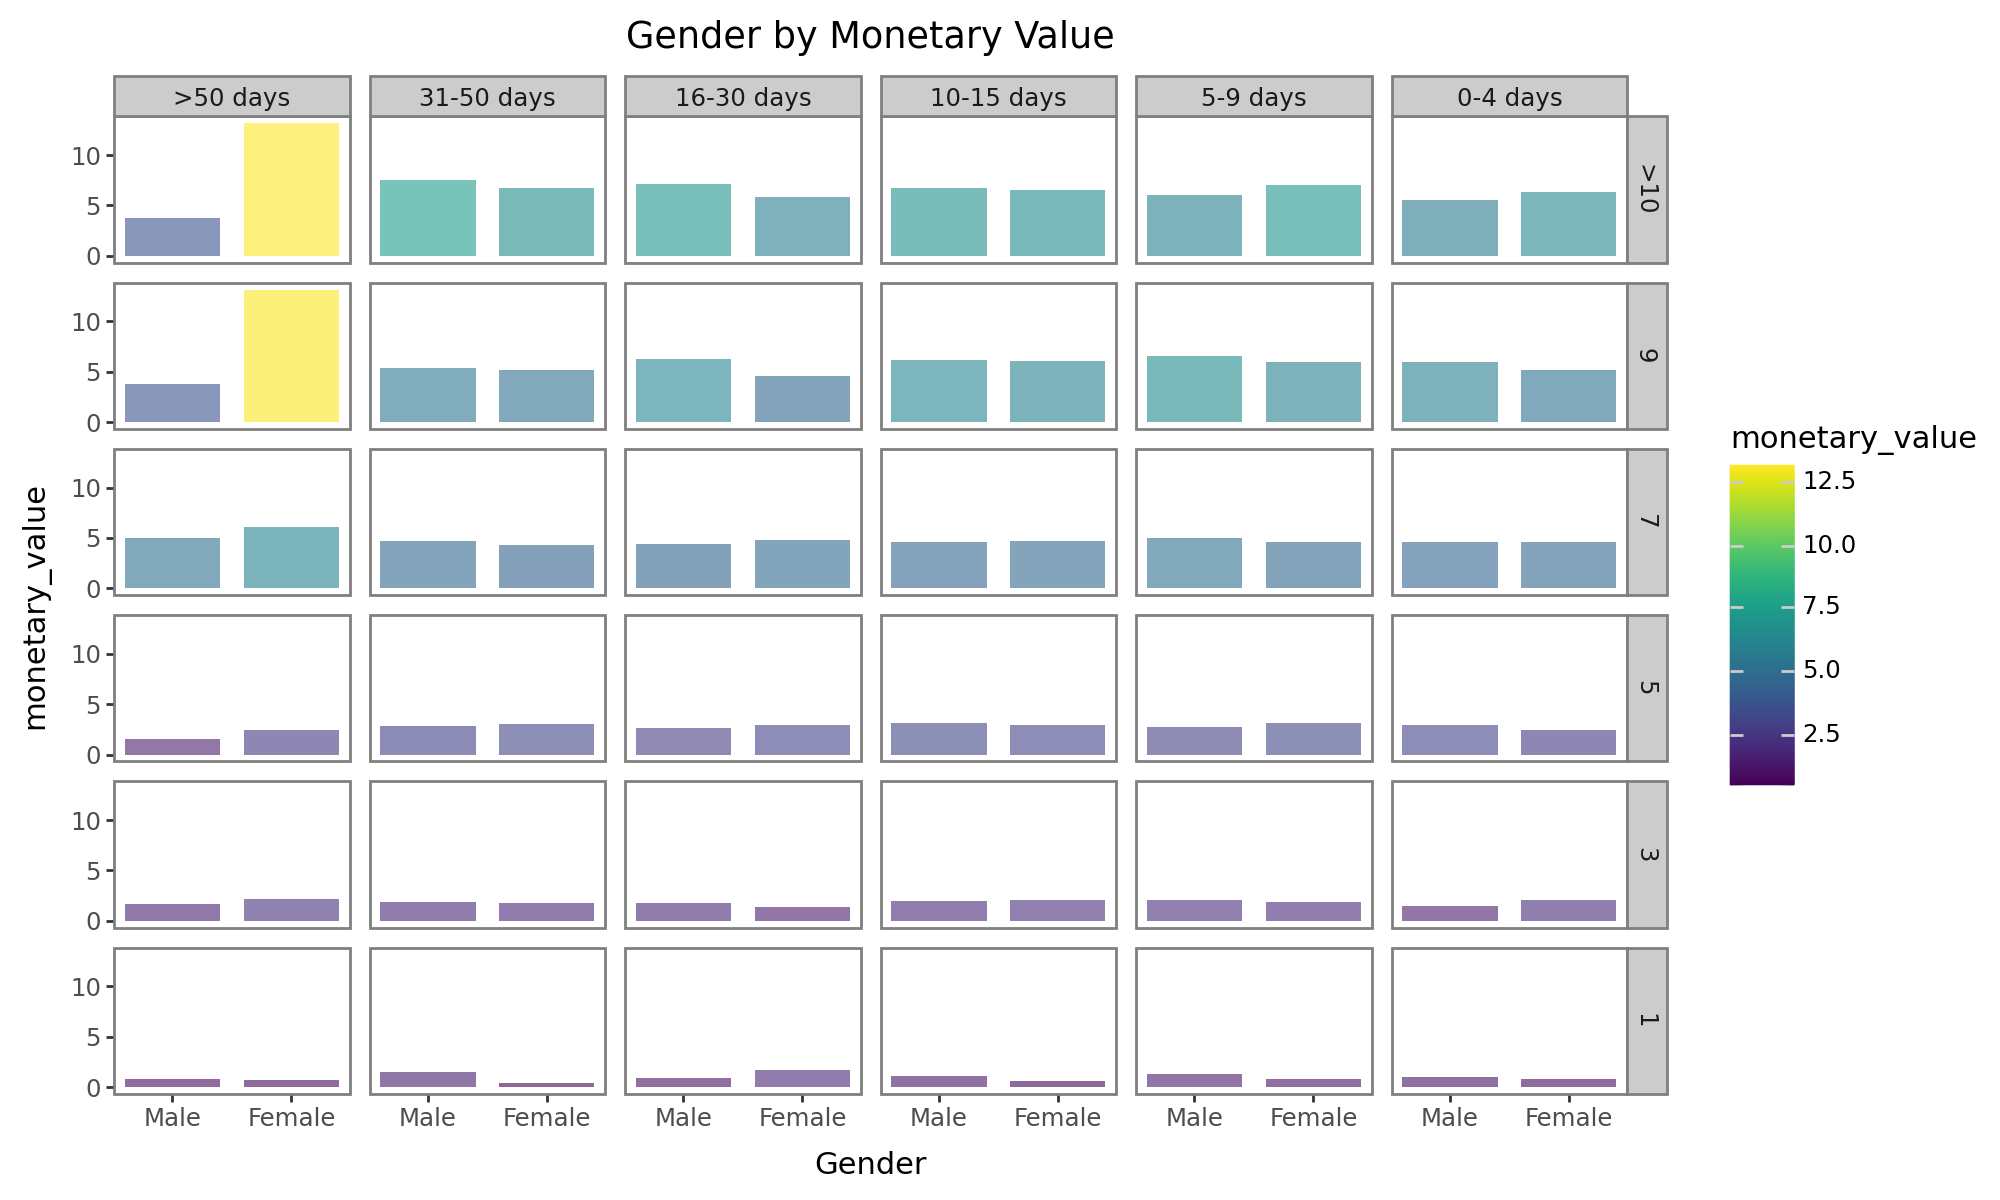

In [63]:
# Gender with Monetary Value (mean)

lcg2= basetable_summerC.groupby(['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(monetary_value=('MonetaryValue', 'mean'))
lcg2['player']='player'

plot1 = (ggplot(lcg2, aes(x='Gender', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by Monetary Value"))

plot1.show()

In [64]:
# Gender with CLV

# For this case we will calculate the CLV again but this time we will create a new column to the new summer basetable to store the values for convenience
# The retention rate of the CLV is calculated without taking into account if the player payed in summer. An updated version of the CLV with the true retention rate will be calculated in the churn part

CLV_summer = basetable_summerC[['CustomerID', 'MonetaryValue']]
AC = 1
Discount_rate = 0.085
periods = 3
retention_rate_fall= len(pd.unique(fallsesstrx['CustomerID']))/ len(pd.unique(summersesstrx['CustomerID']))

def calc_clv(margin, r, d, acquisition,t):
    clv= -acquisition
    for i in range(0,t+1):
         clv=clv+(pow(r,i)*margin)/(pow((1+d),i))
    return(clv)

clv_values = []

for index, row in CLV_summer.iterrows():
  row['CLV'] = calc_clv(margin=row['MonetaryValue'], r=retention_rate_fall, d=Discount_rate, acquisition=AC, t=periods)
  clv_values.append(row['CLV'])

basetable_summerC['CLV'] = clv_values

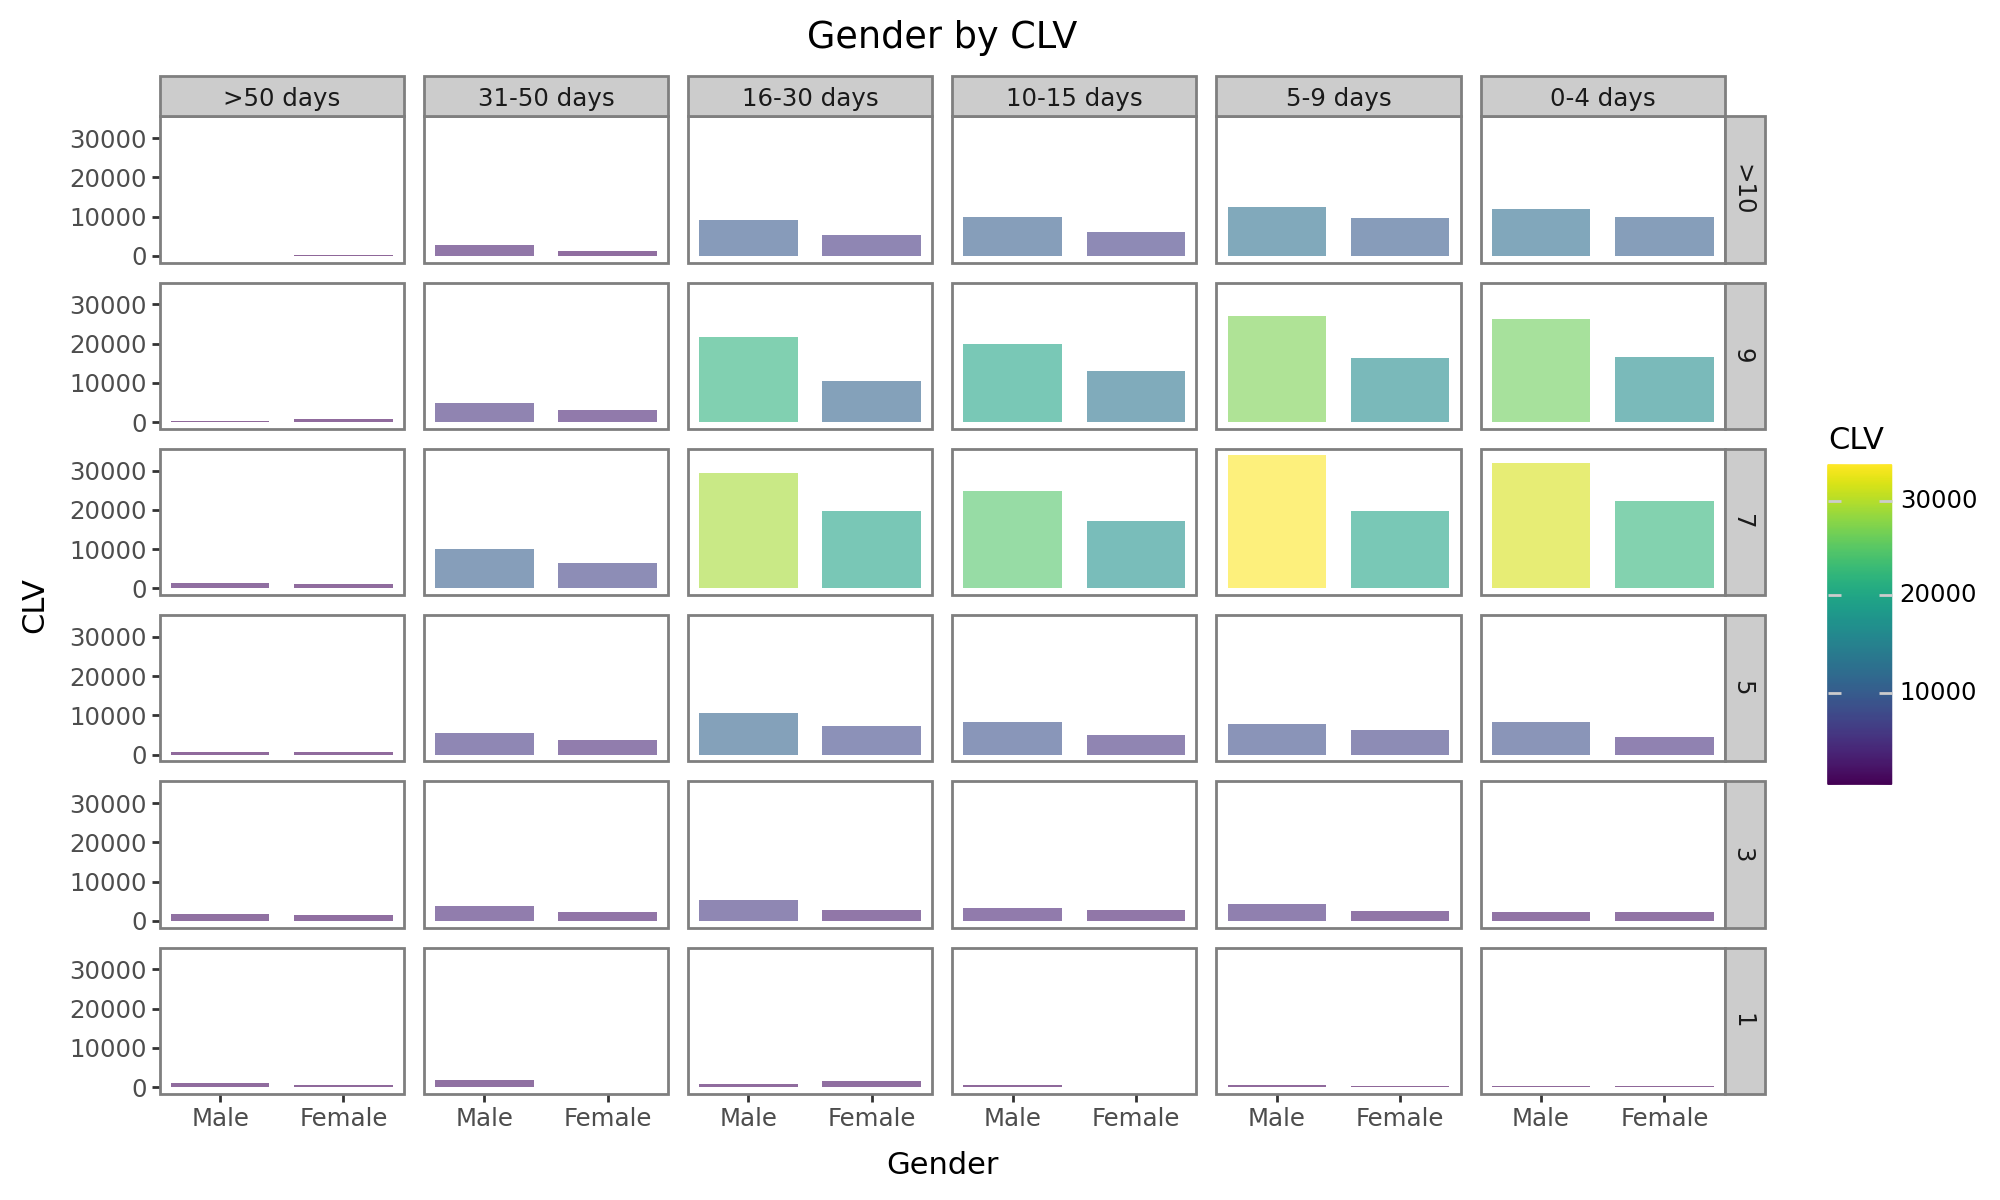

In [65]:
lcg3= basetable_summerC.groupby(['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(CLV=('CLV', 'sum'))
lcg3['player']='player'

plot1 = (ggplot(lcg3, aes(x='Gender', y='CLV', fill='CLV')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by CLV"))

plot1.show()

In [66]:
# Age group with Quanity
bins= [6, 18, 28, 38, 50, 81]
labels= ['6-17', '18-27', '28-37', '38-49', '50-80']
basetable_summerC['age_group'] = pd.cut(basetable_summerC['Age'], bins=bins, labels=labels)

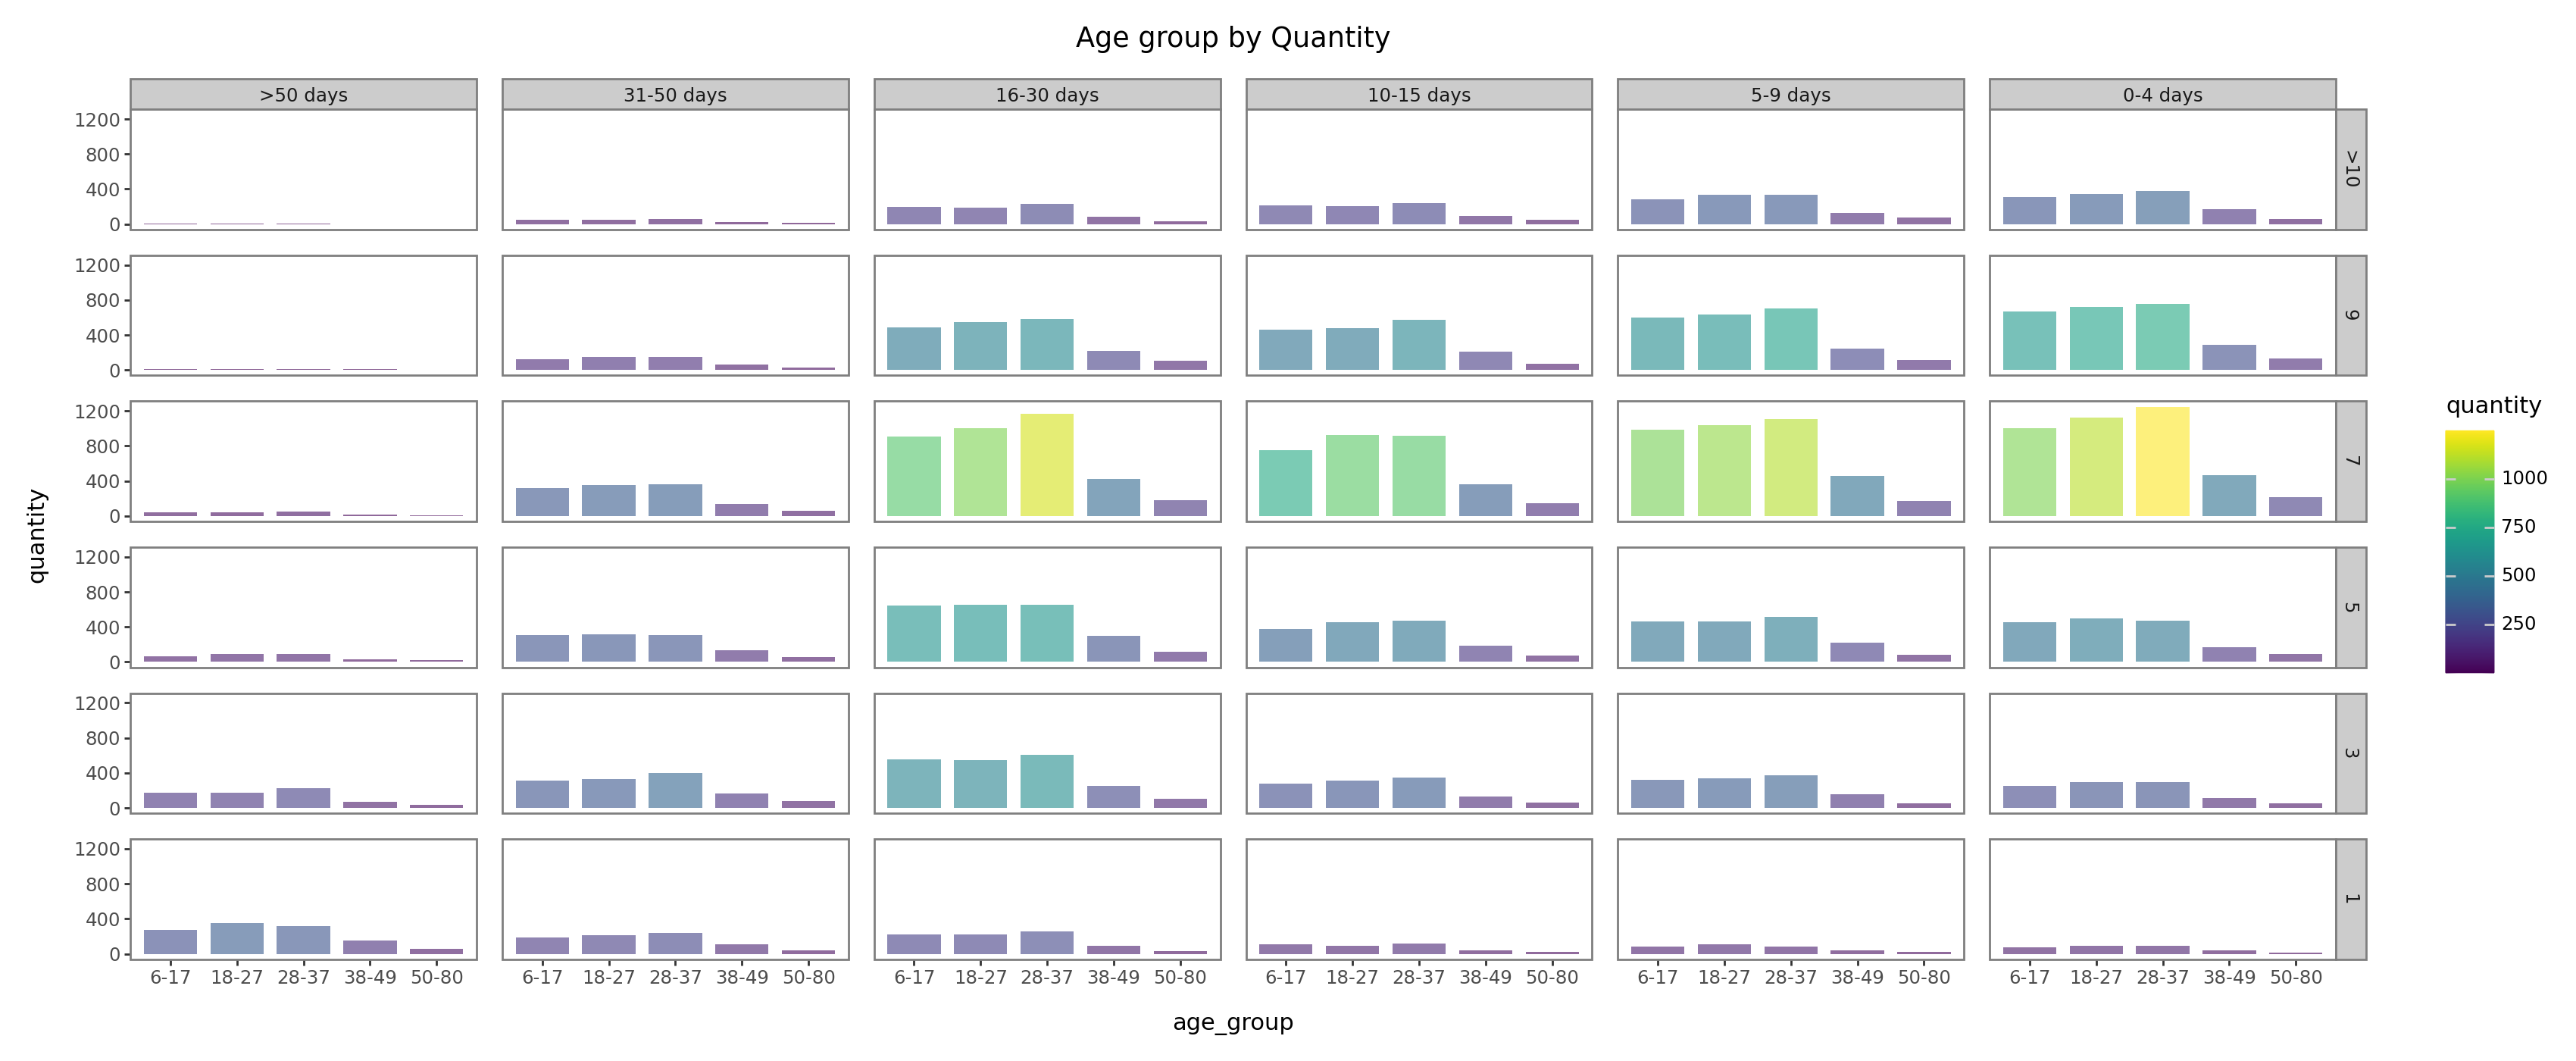

In [67]:
lcg4= basetable_summerC.groupby(['age_group','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID', 'count'))
lcg4['player']='player'

plot1 = (ggplot(lcg4, aes(x='age_group', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by Quantity"))

plot1.show()

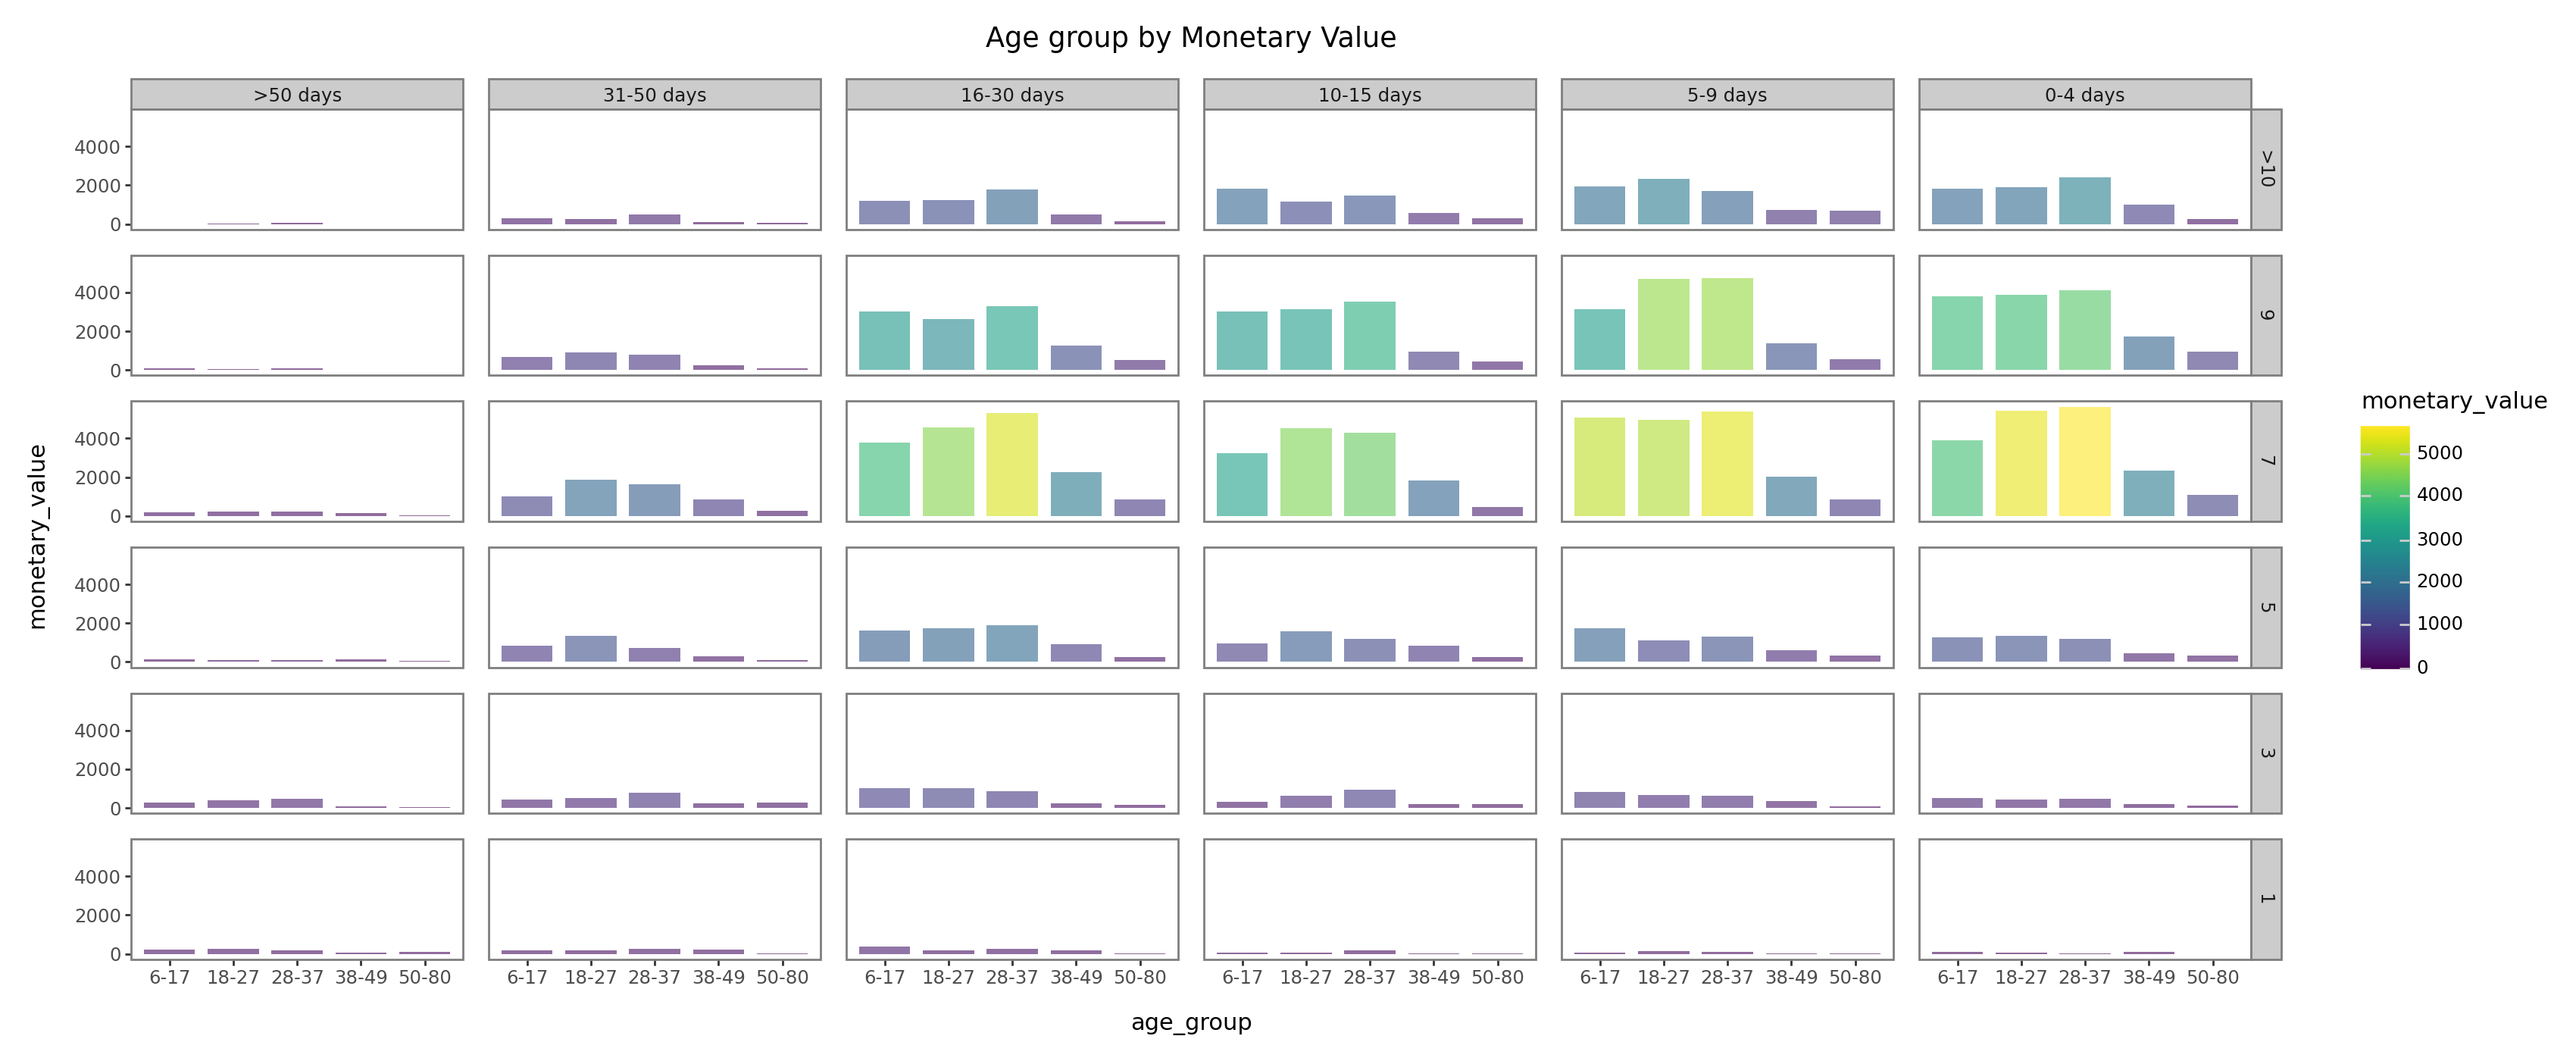

In [68]:
# Age group with Monetary Value
lcg5= basetable_summerC.groupby(['age_group','segmfreq','segmrec'],observed=True, as_index=False).agg(monetary_value=('MonetaryValue', 'sum'))
lcg5['player']='player'

plot1 = (ggplot(lcg5, aes(x='age_group', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by Monetary Value"))

plot1.show()

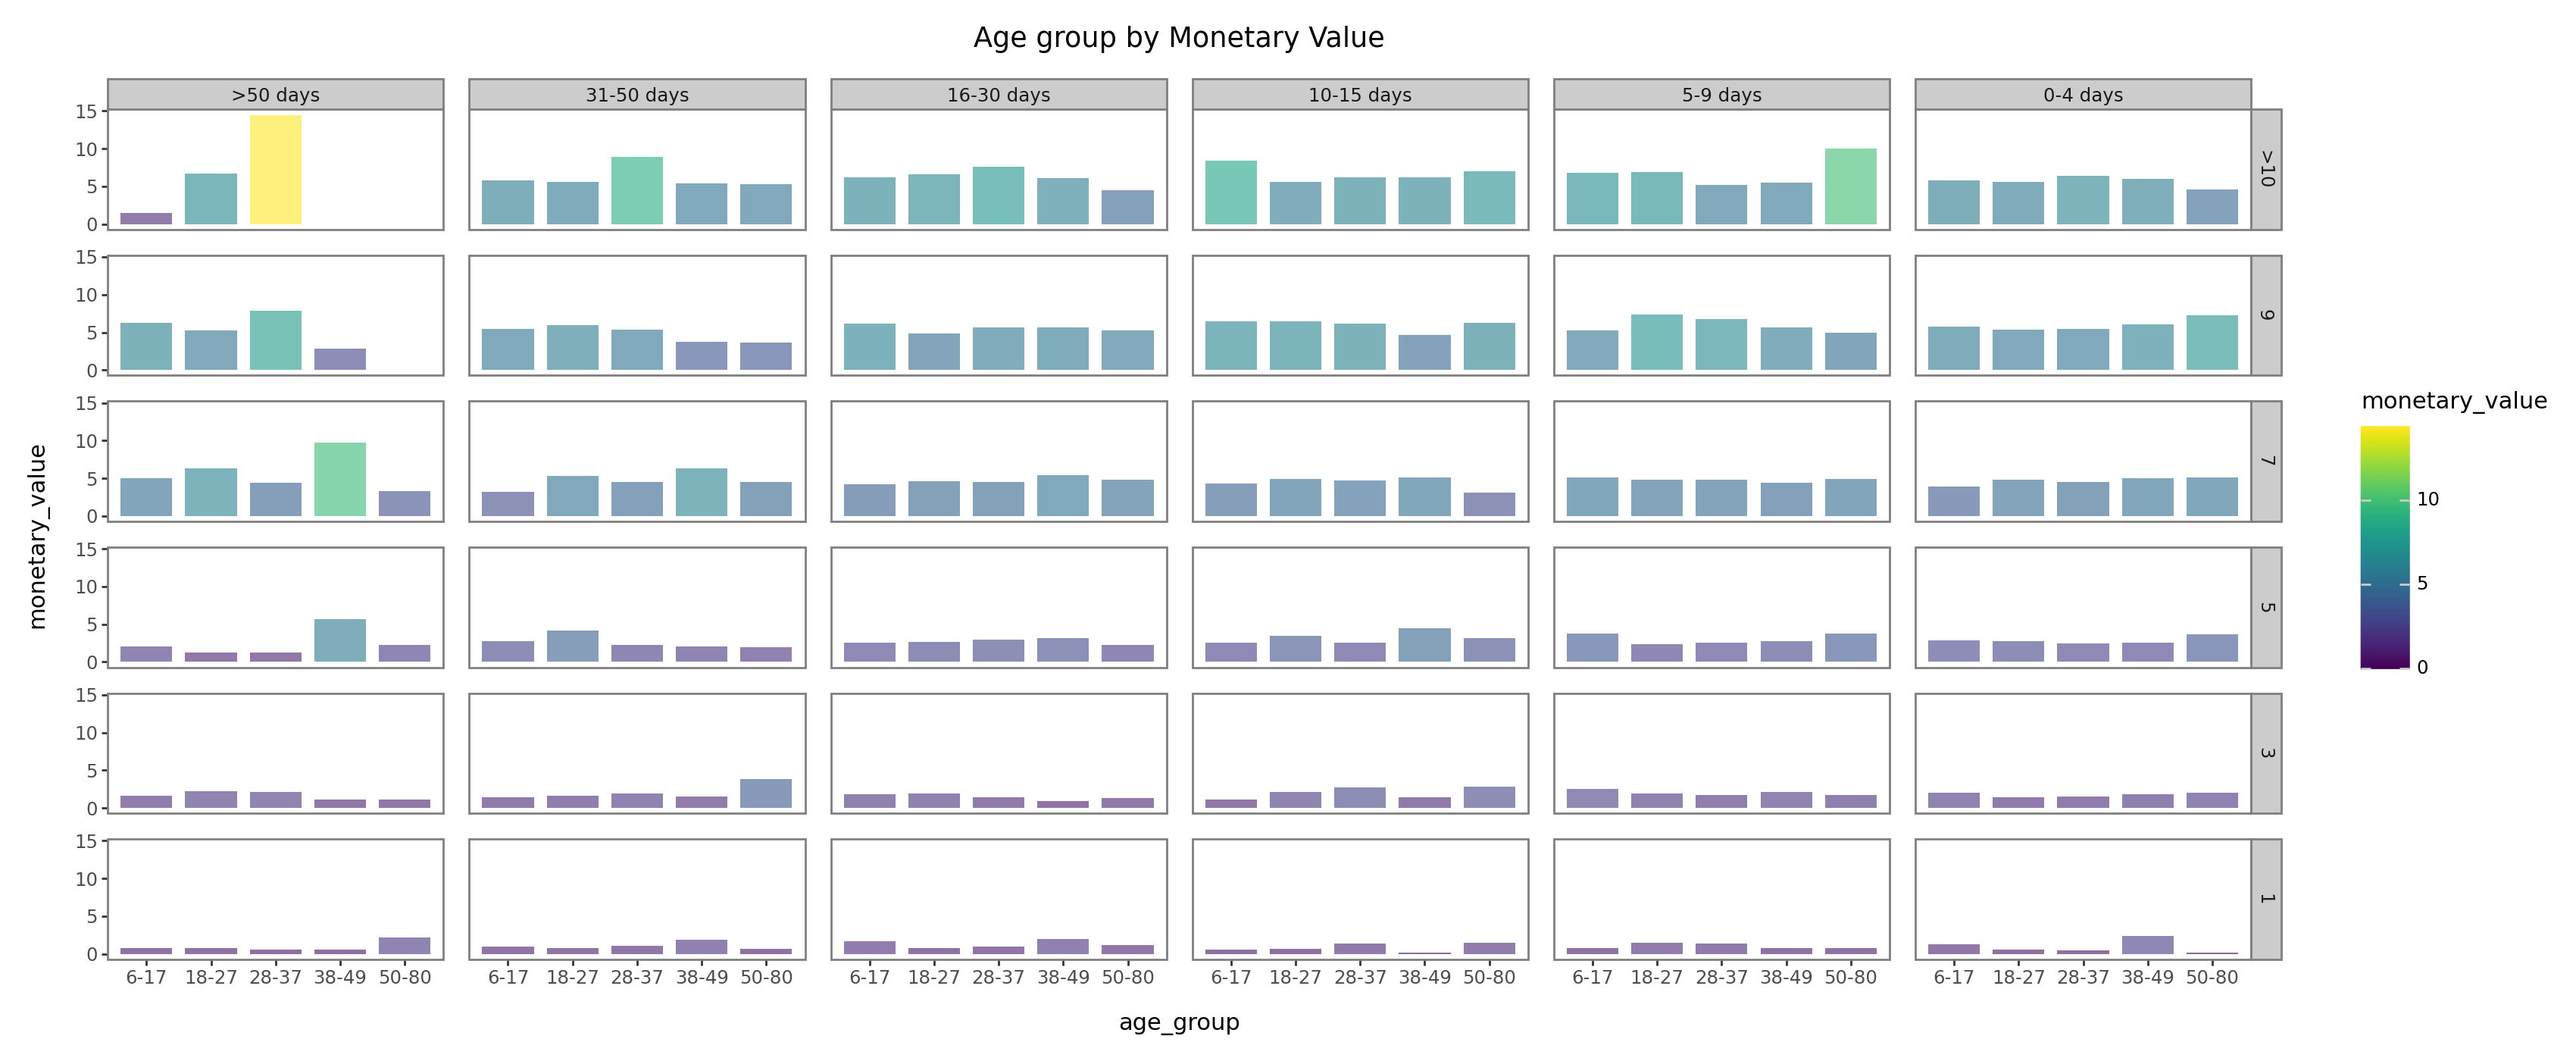

In [69]:
# Age group with Monetary Value (mean)
lcg5= basetable_summerC.groupby(['age_group','segmfreq','segmrec'],observed=True, as_index=False).agg(monetary_value=('MonetaryValue', 'mean'))
lcg5['player']='player'

plot1 = (ggplot(lcg5, aes(x='age_group', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by Monetary Value"))

plot1.show()

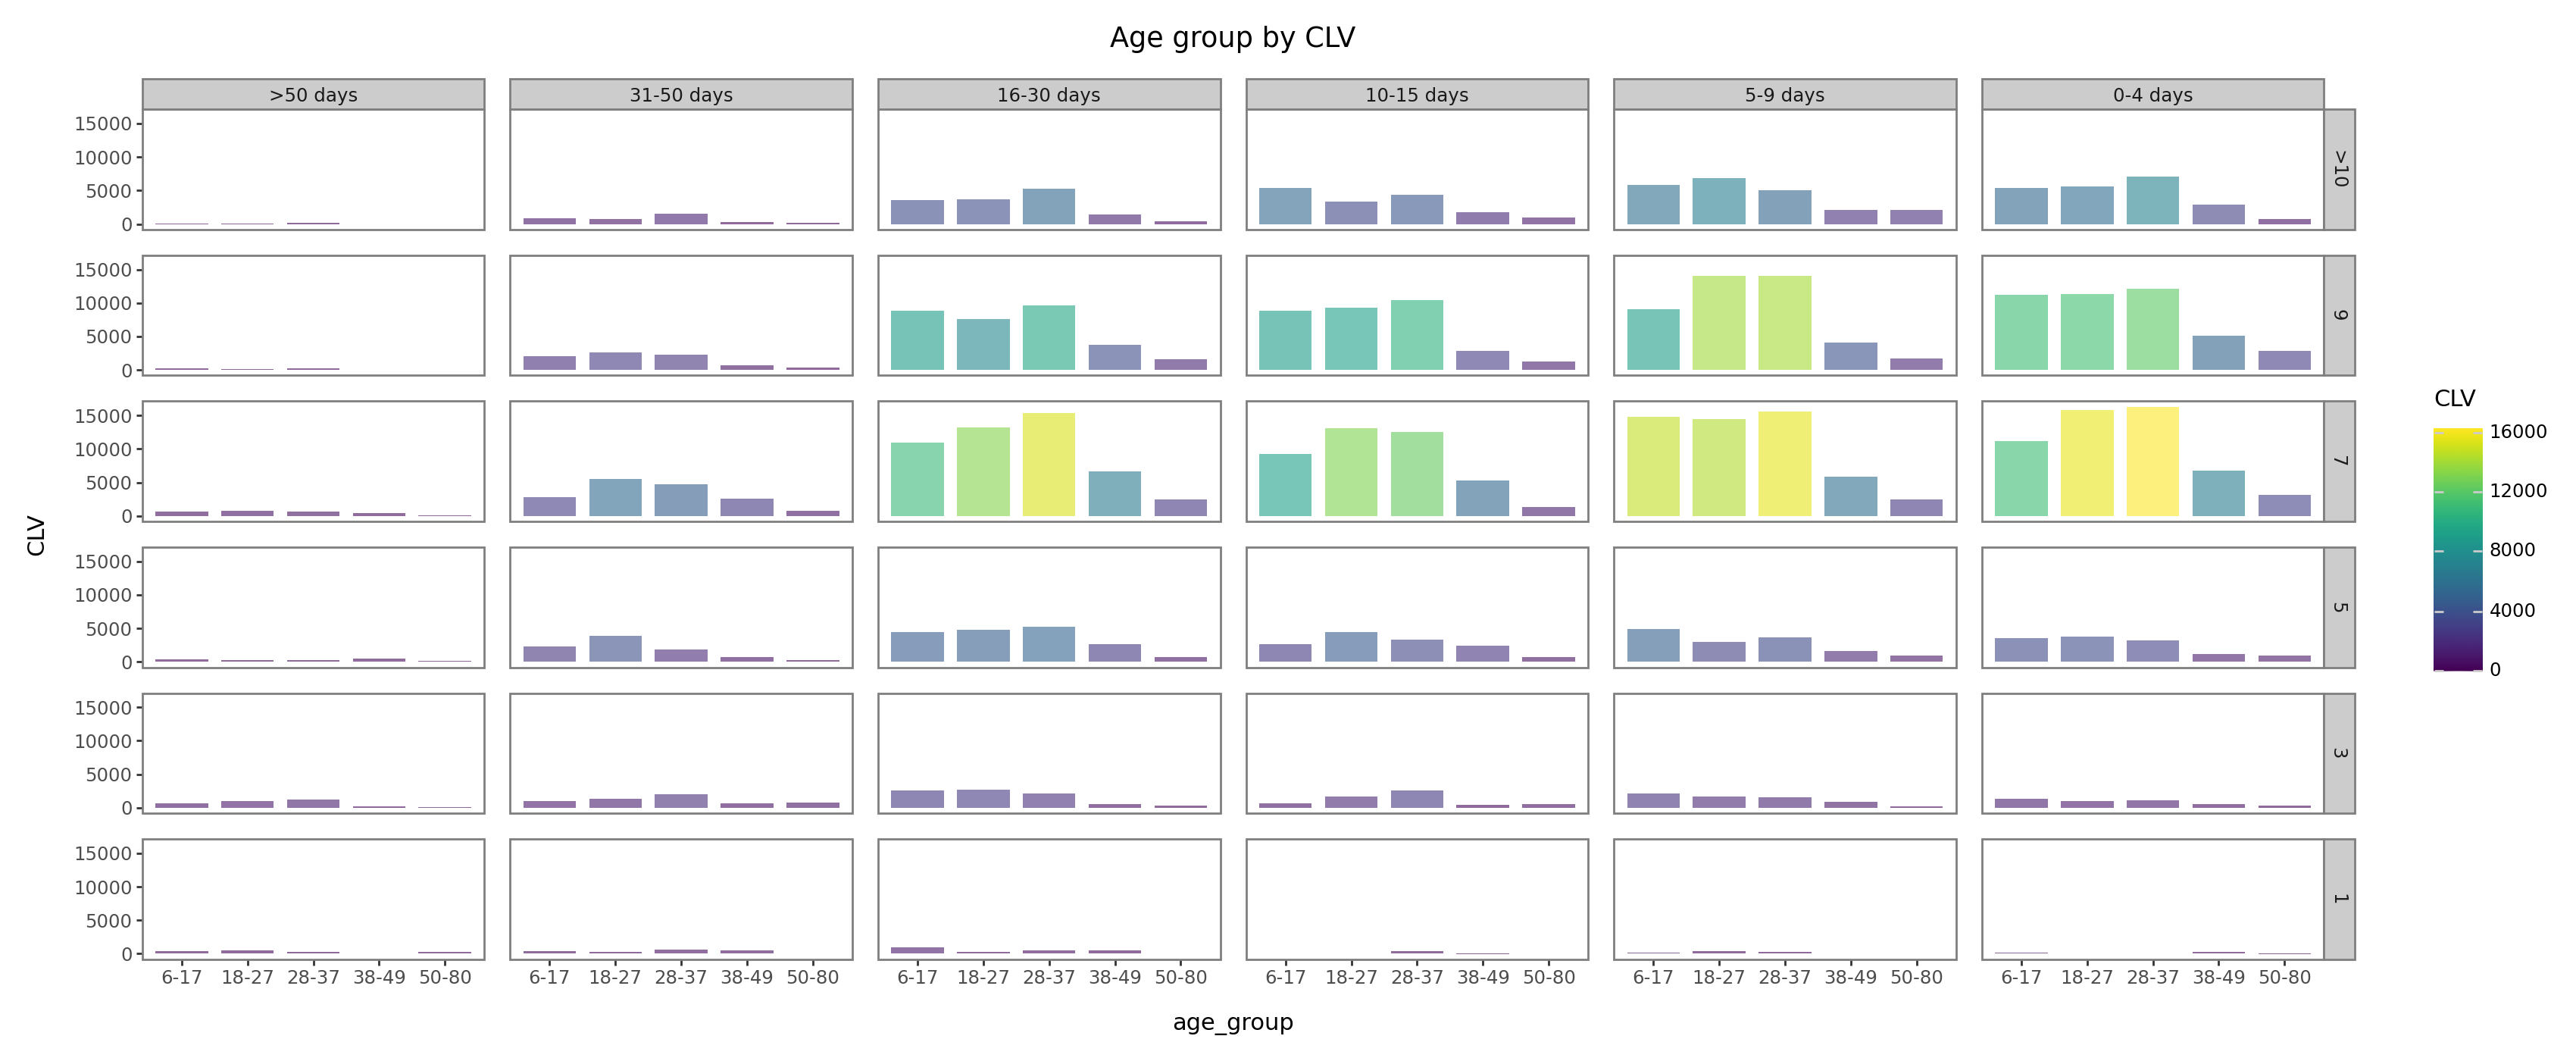

In [70]:
# Age group with CLV

lcg6= basetable_summerC.groupby(['age_group','segmfreq','segmrec'],observed=True, as_index=False).agg(CLV=('CLV', 'sum'))
lcg6['player']='player'

plot1 = (ggplot(lcg6, aes(x='age_group', y='CLV', fill='CLV')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by CLV"))

plot1.show()

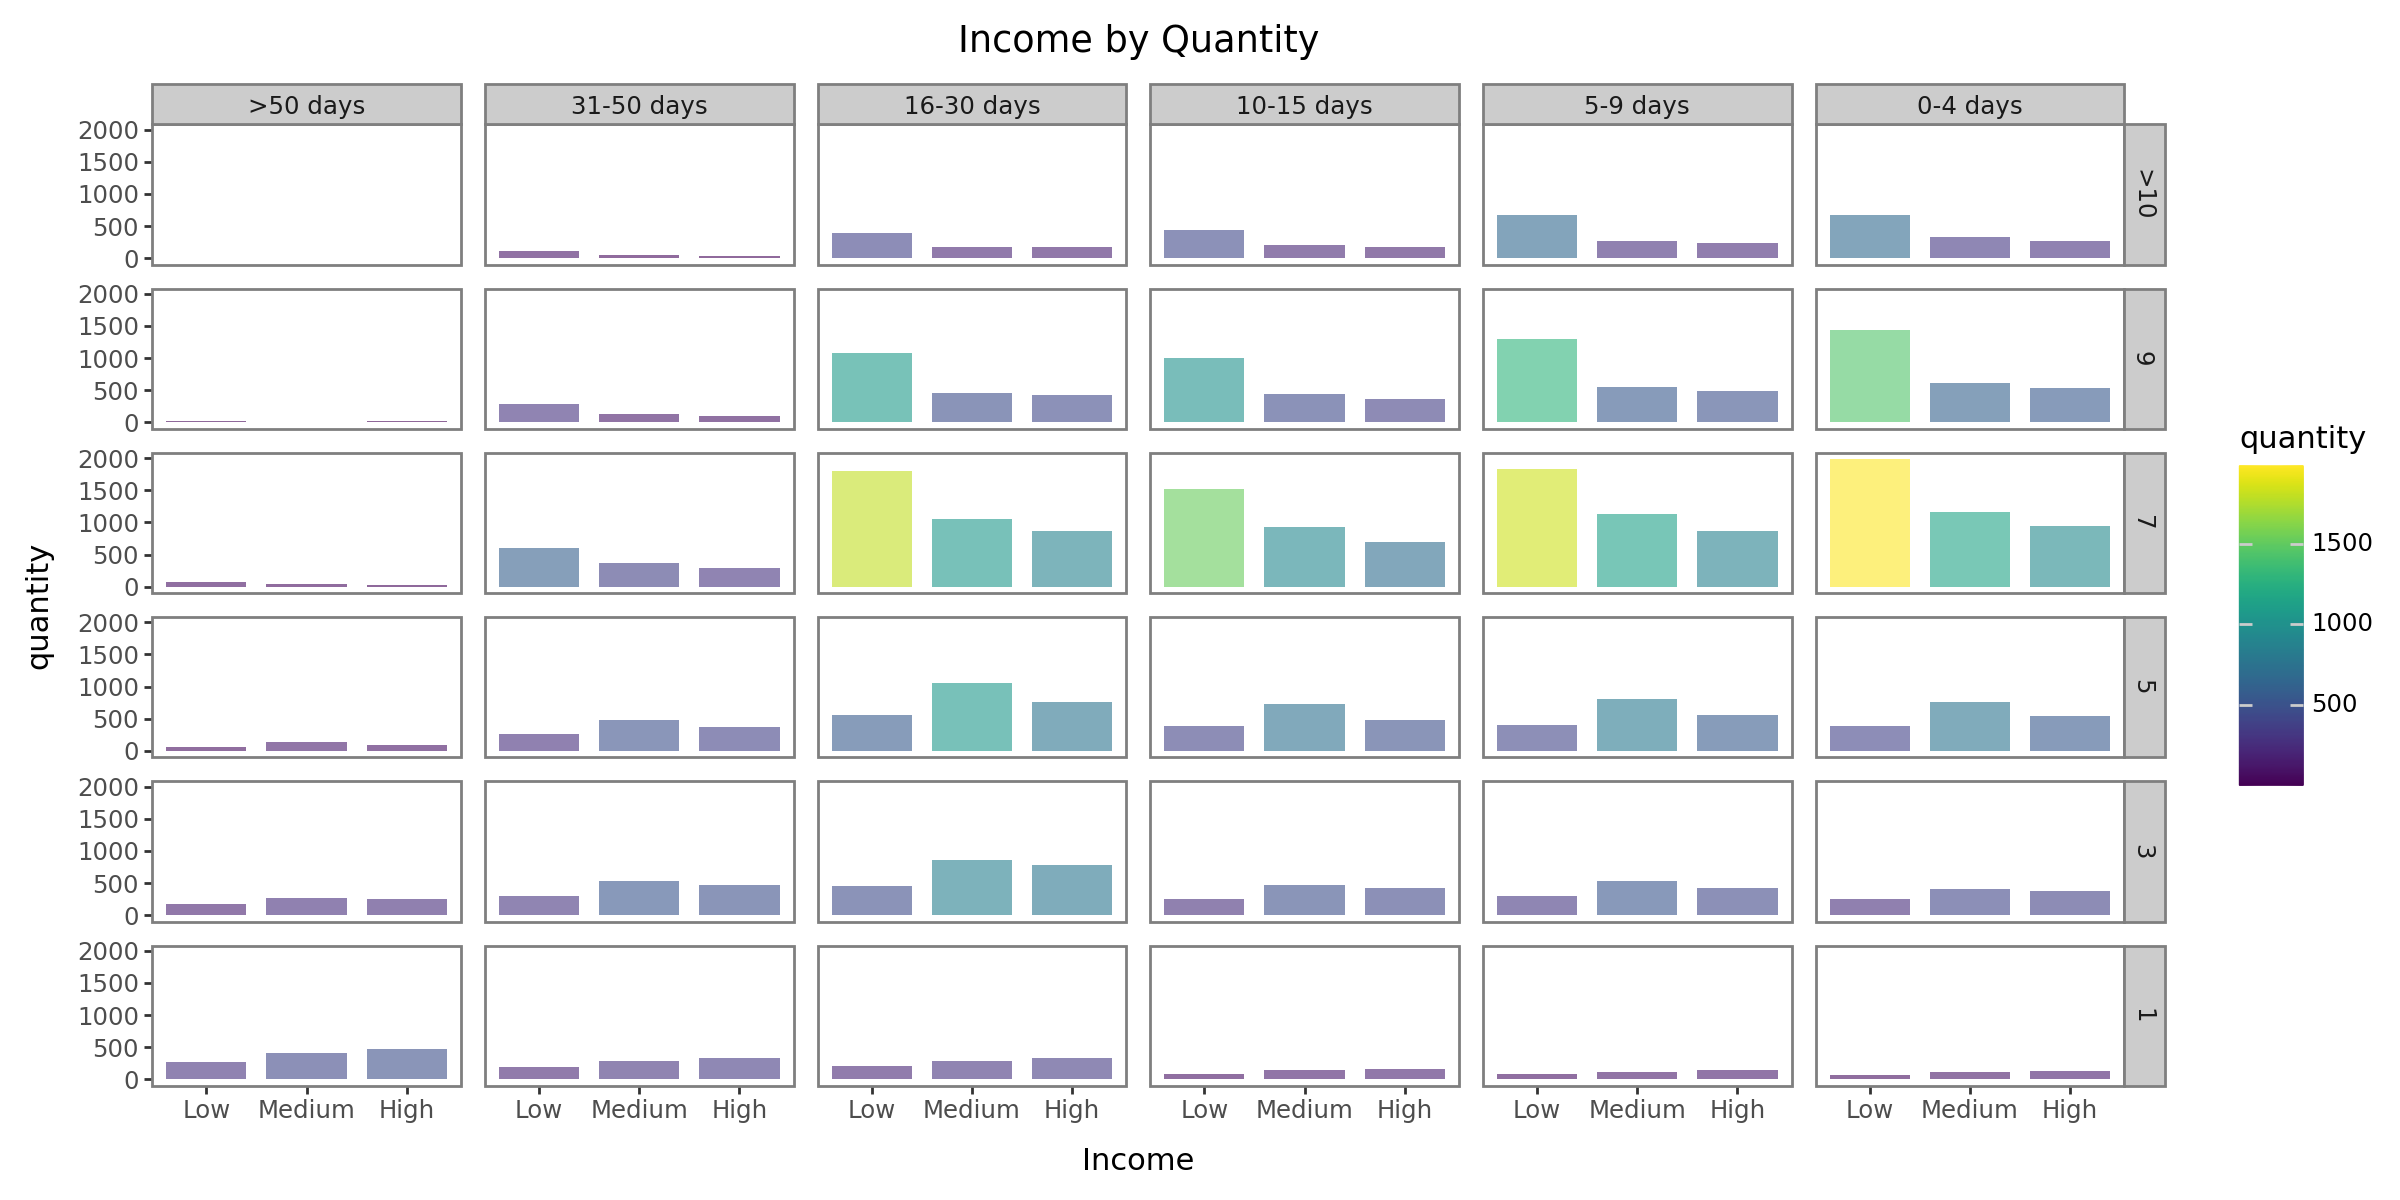

In [71]:
# Income with Quantity

lcg7= basetable_summerC.groupby(['Income','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID', 'count'))
lcg7['player']='player'

plot1 = (ggplot(lcg7, aes(x='Income', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1, 2], labels=["Low", "Medium", "High"]) +
         ggtitle("Income by Quantity"))

plot1.show()

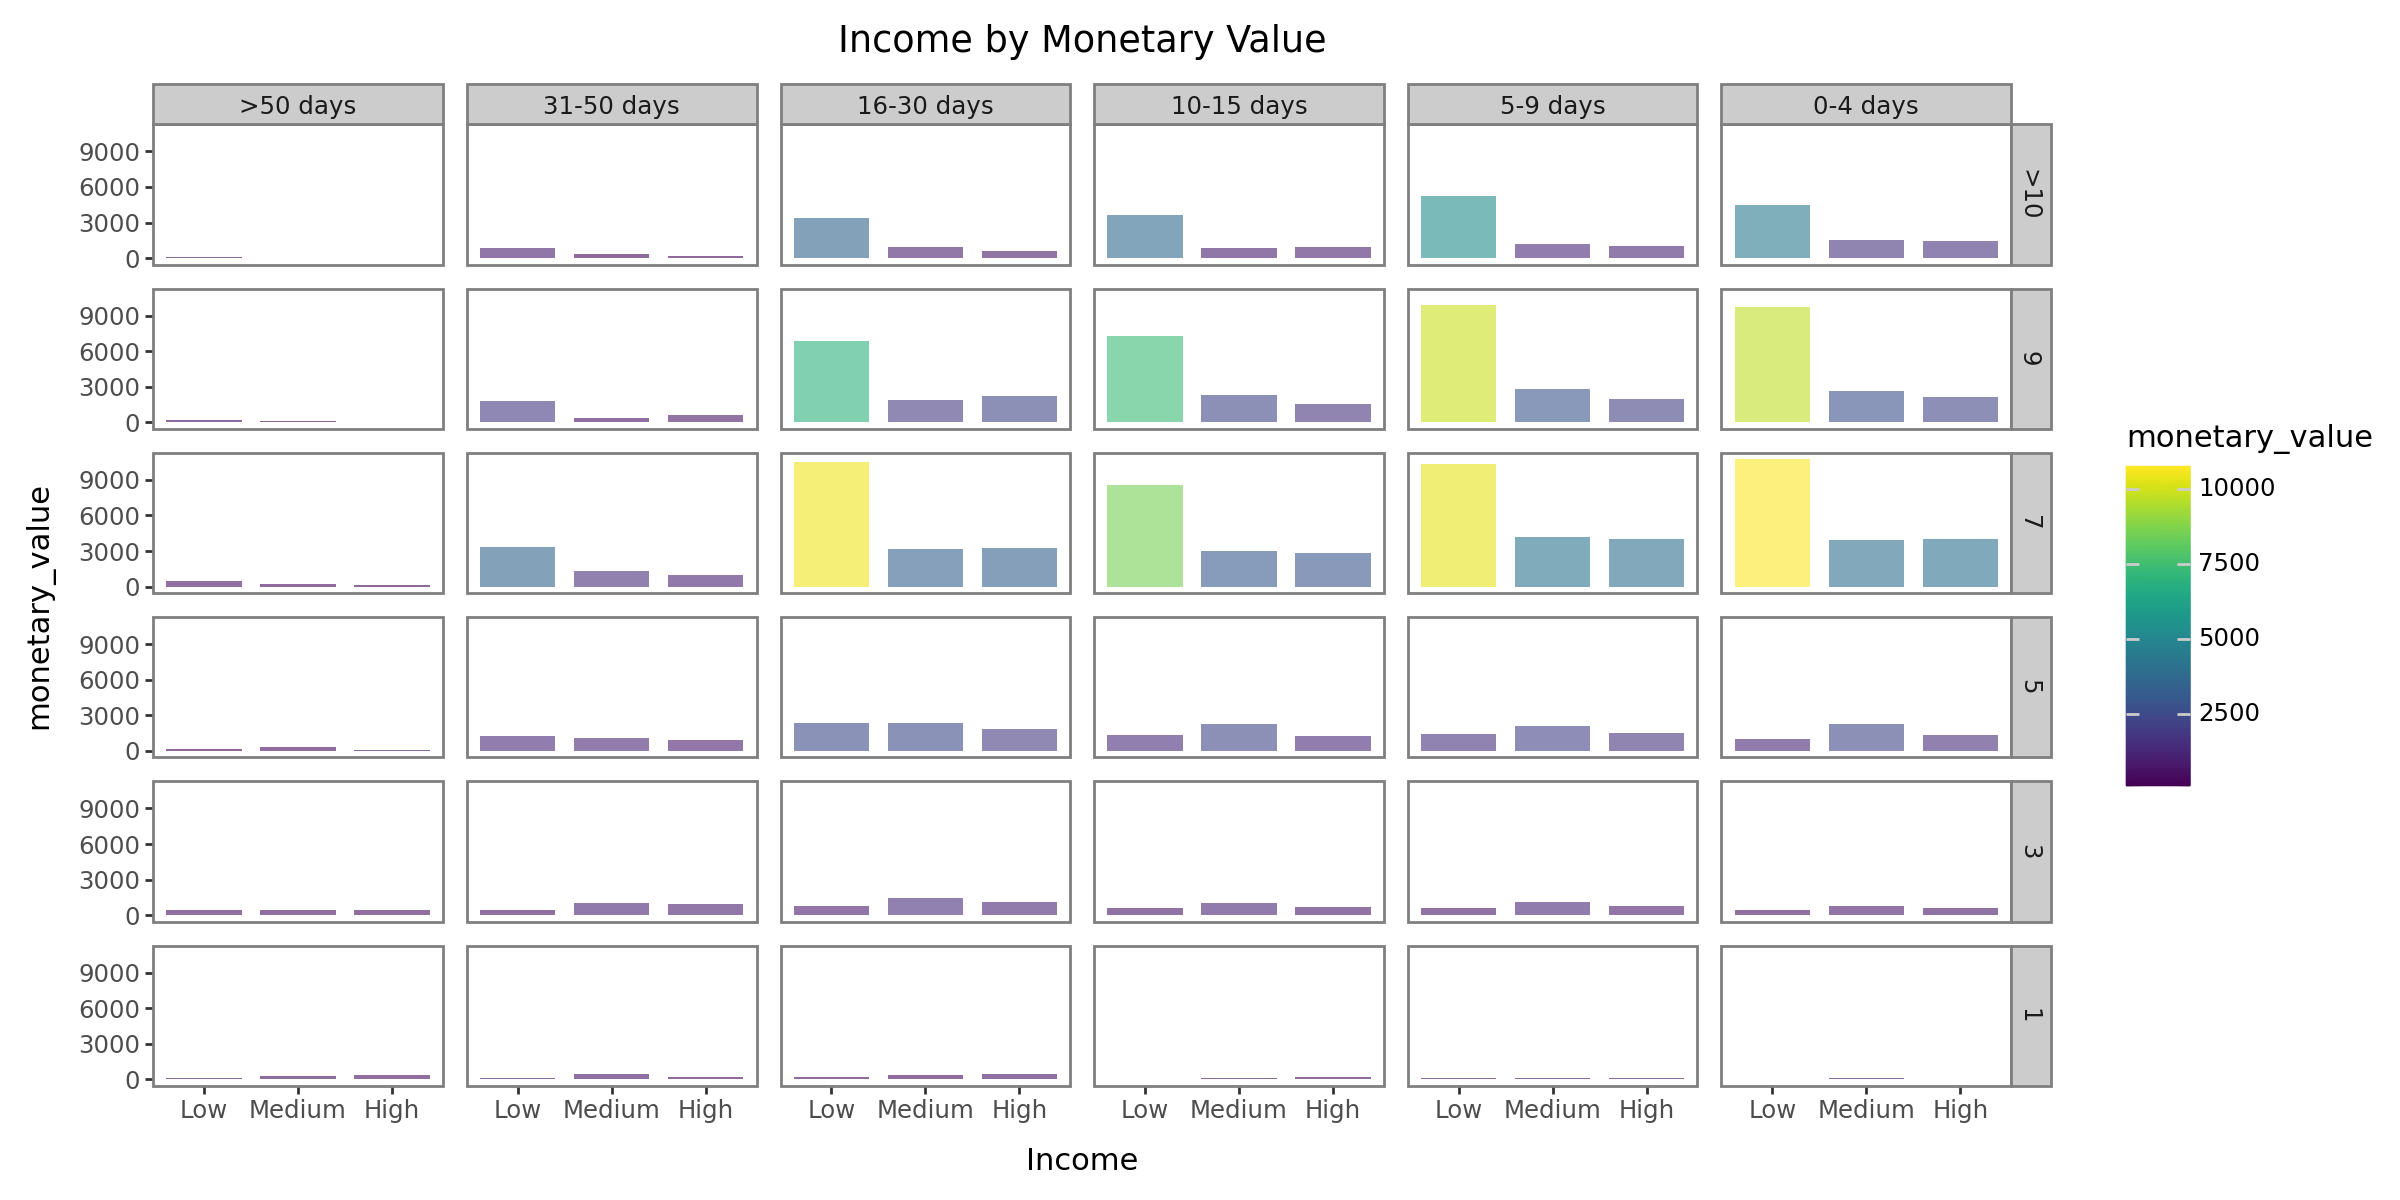

In [72]:
# Income with Monetary Value

lcg8= basetable_summerC.groupby(['Income','segmfreq','segmrec'],observed=True, as_index=False).agg(monetary_value=('MonetaryValue', 'sum'))
lcg8['player']='player'

plot1 = (ggplot(lcg8, aes(x='Income', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1, 2], labels=["Low", "Medium", "High"]) +
         ggtitle("Income by Monetary Value"))

plot1.show()

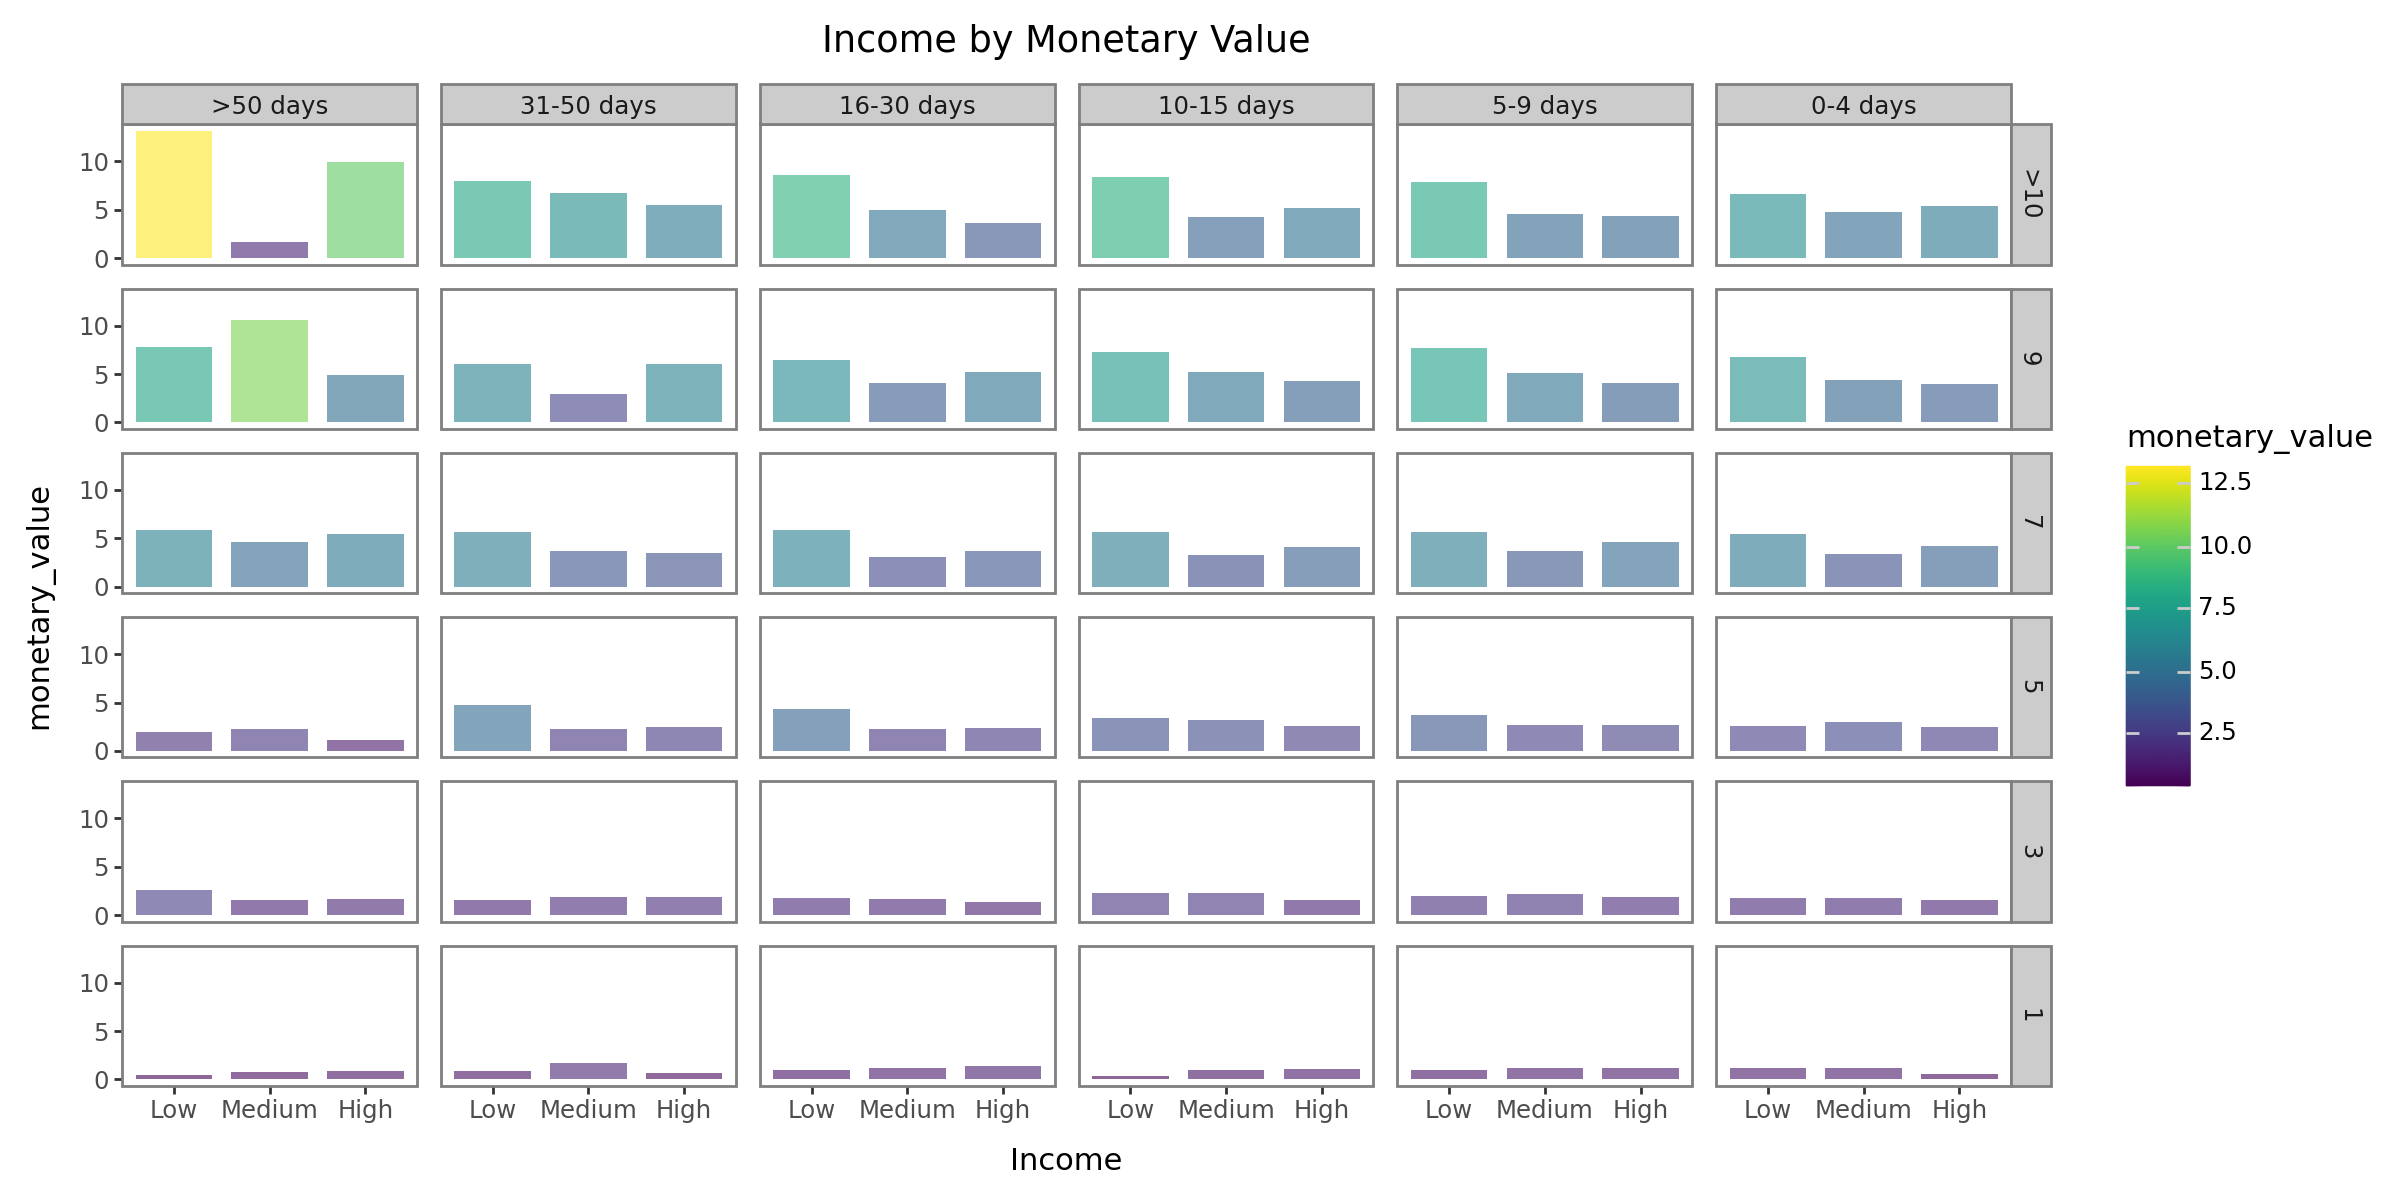

In [73]:
# Income with Monetary Value (mean)

lcg8= basetable_summerC.groupby(['Income','segmfreq','segmrec'],observed=True, as_index=False).agg(monetary_value=('MonetaryValue', 'mean'))
lcg8['player']='player'

plot1 = (ggplot(lcg8, aes(x='Income', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1, 2], labels=["Low", "Medium", "High"]) +
         ggtitle("Income by Monetary Value"))

plot1.show()

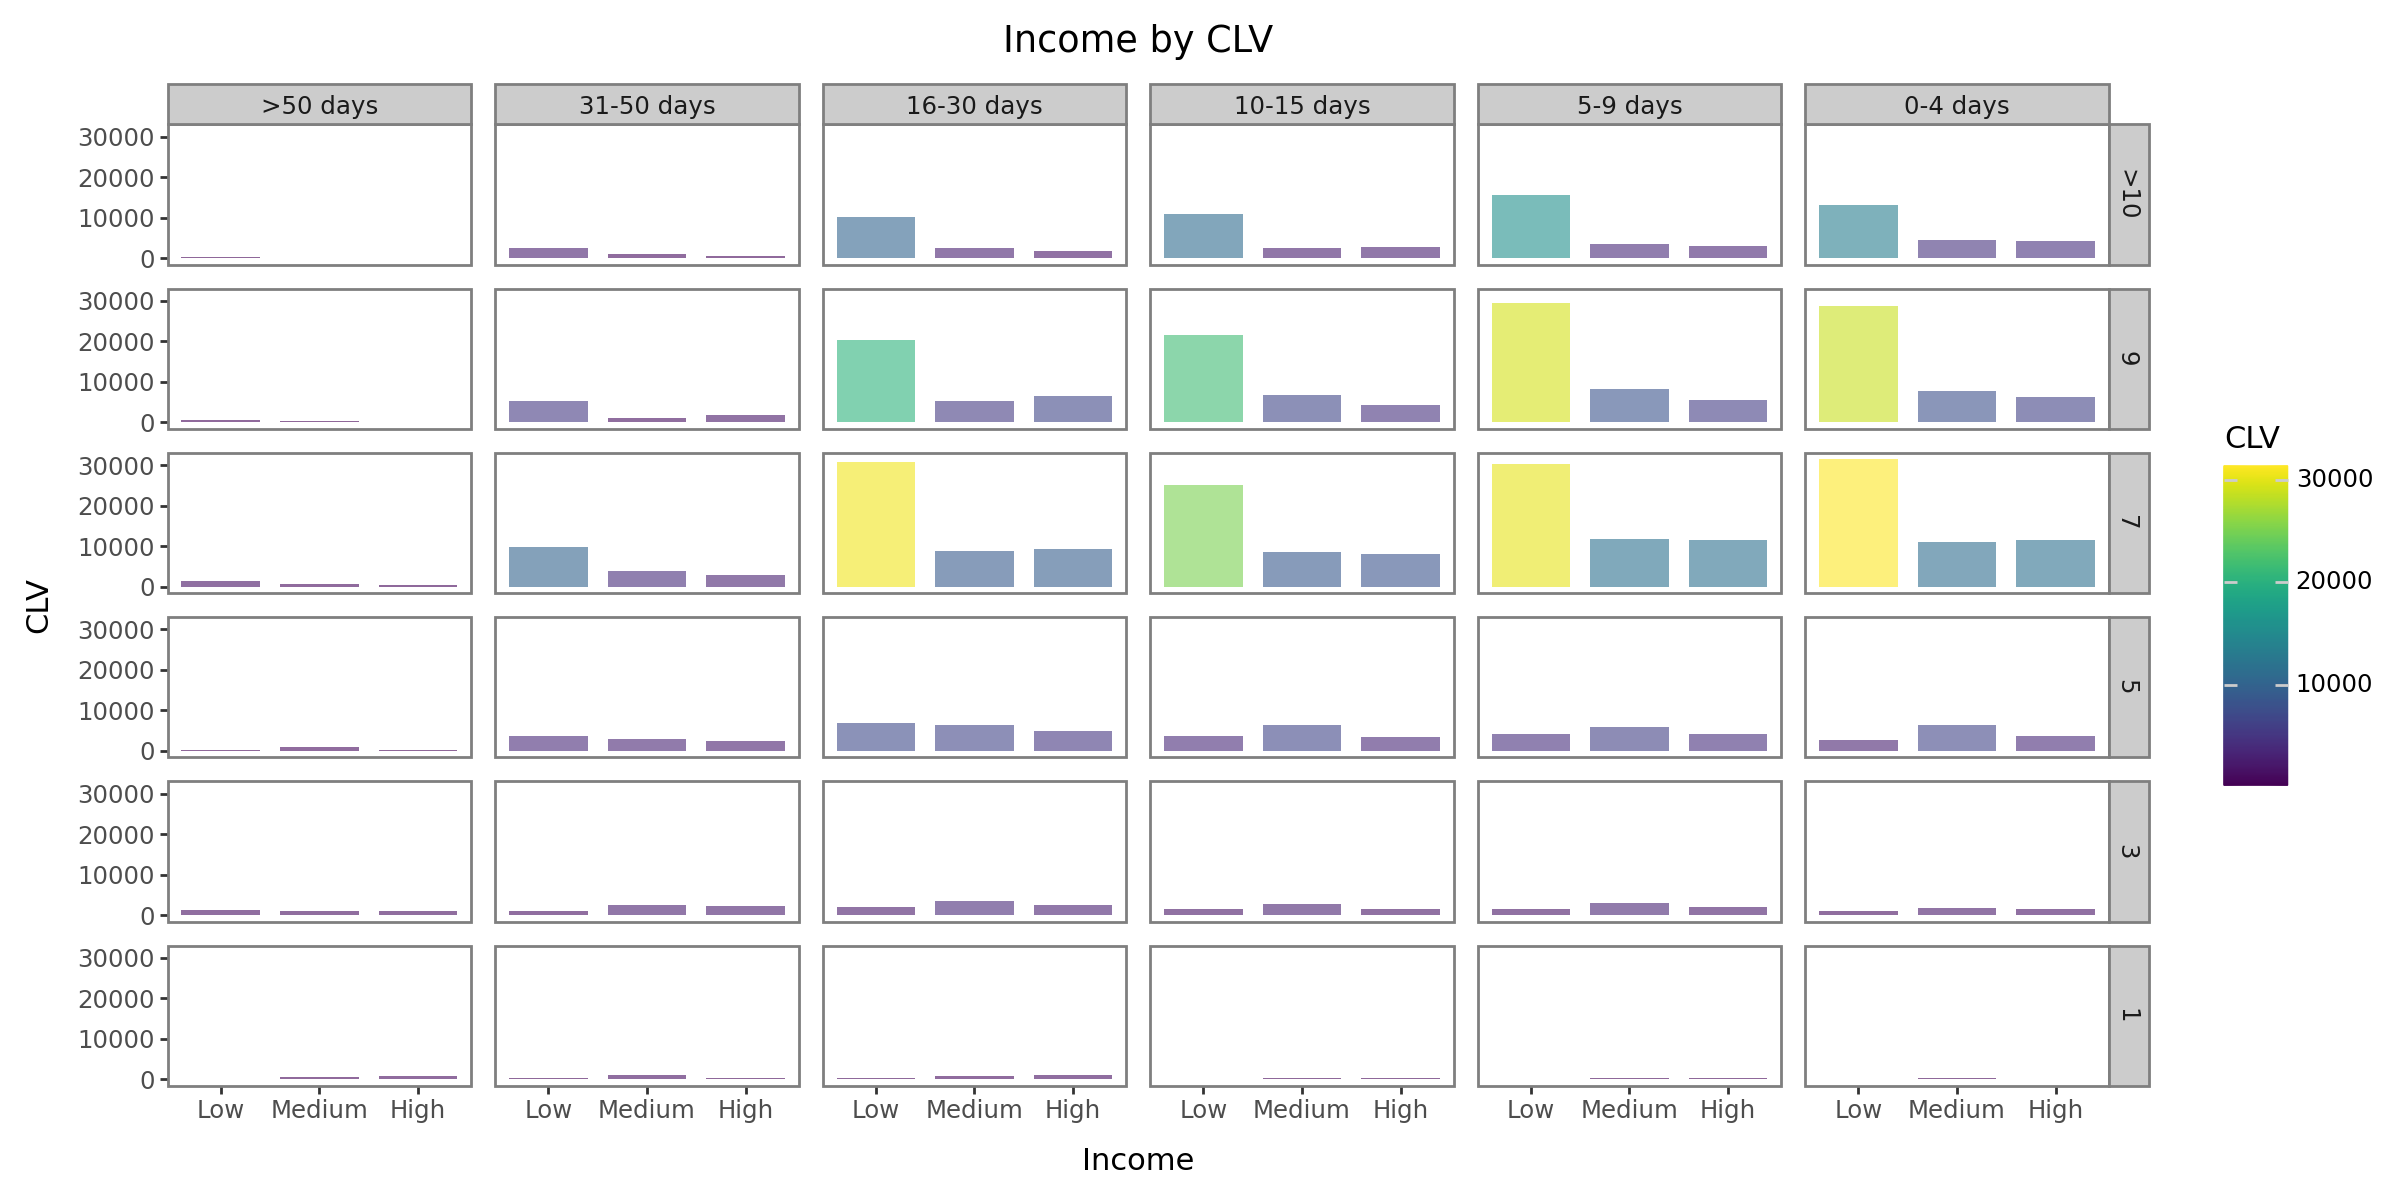

In [74]:
# Income with CLV

lcg9= basetable_summerC.groupby(['Income','segmfreq','segmrec'],observed=True, as_index=False).agg(CLV=('CLV', 'sum'))
lcg9['player']='player'

plot1 = (ggplot(lcg9, aes(x='Income', y='CLV', fill='CLV')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1, 2], labels=["Low", "Medium", "High"]) +
         ggtitle("Income by CLV"))

plot1.show()

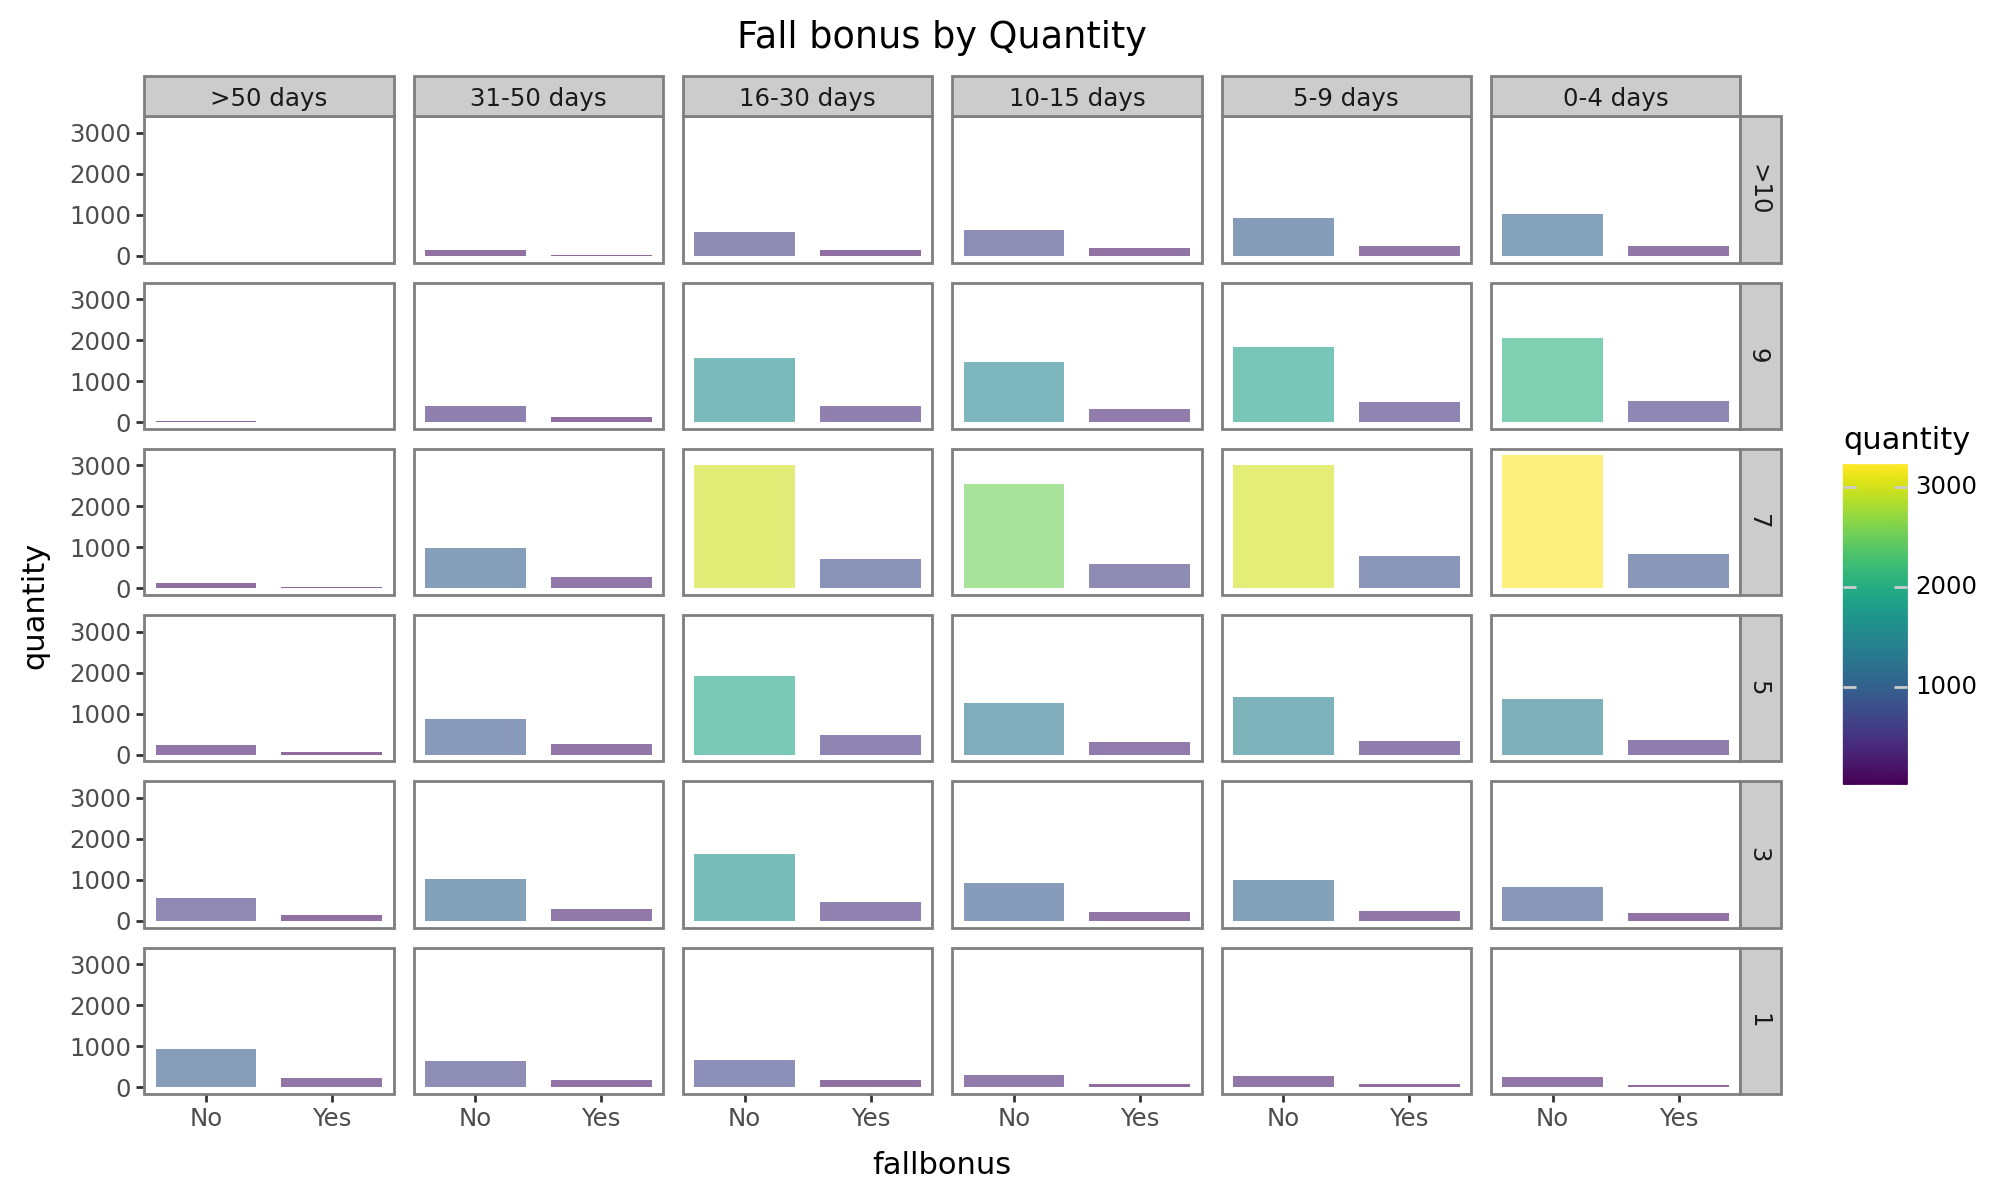

In [75]:
# Fall bonus with Quantity

lcg10= basetable_summerC.groupby(['fallbonus','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID', 'count'))
lcg10['player']='player'

plot1 = (ggplot(lcg10, aes(x='fallbonus', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["No", "Yes"]) +
         ggtitle("Fall bonus by Quantity"))

plot1.show()

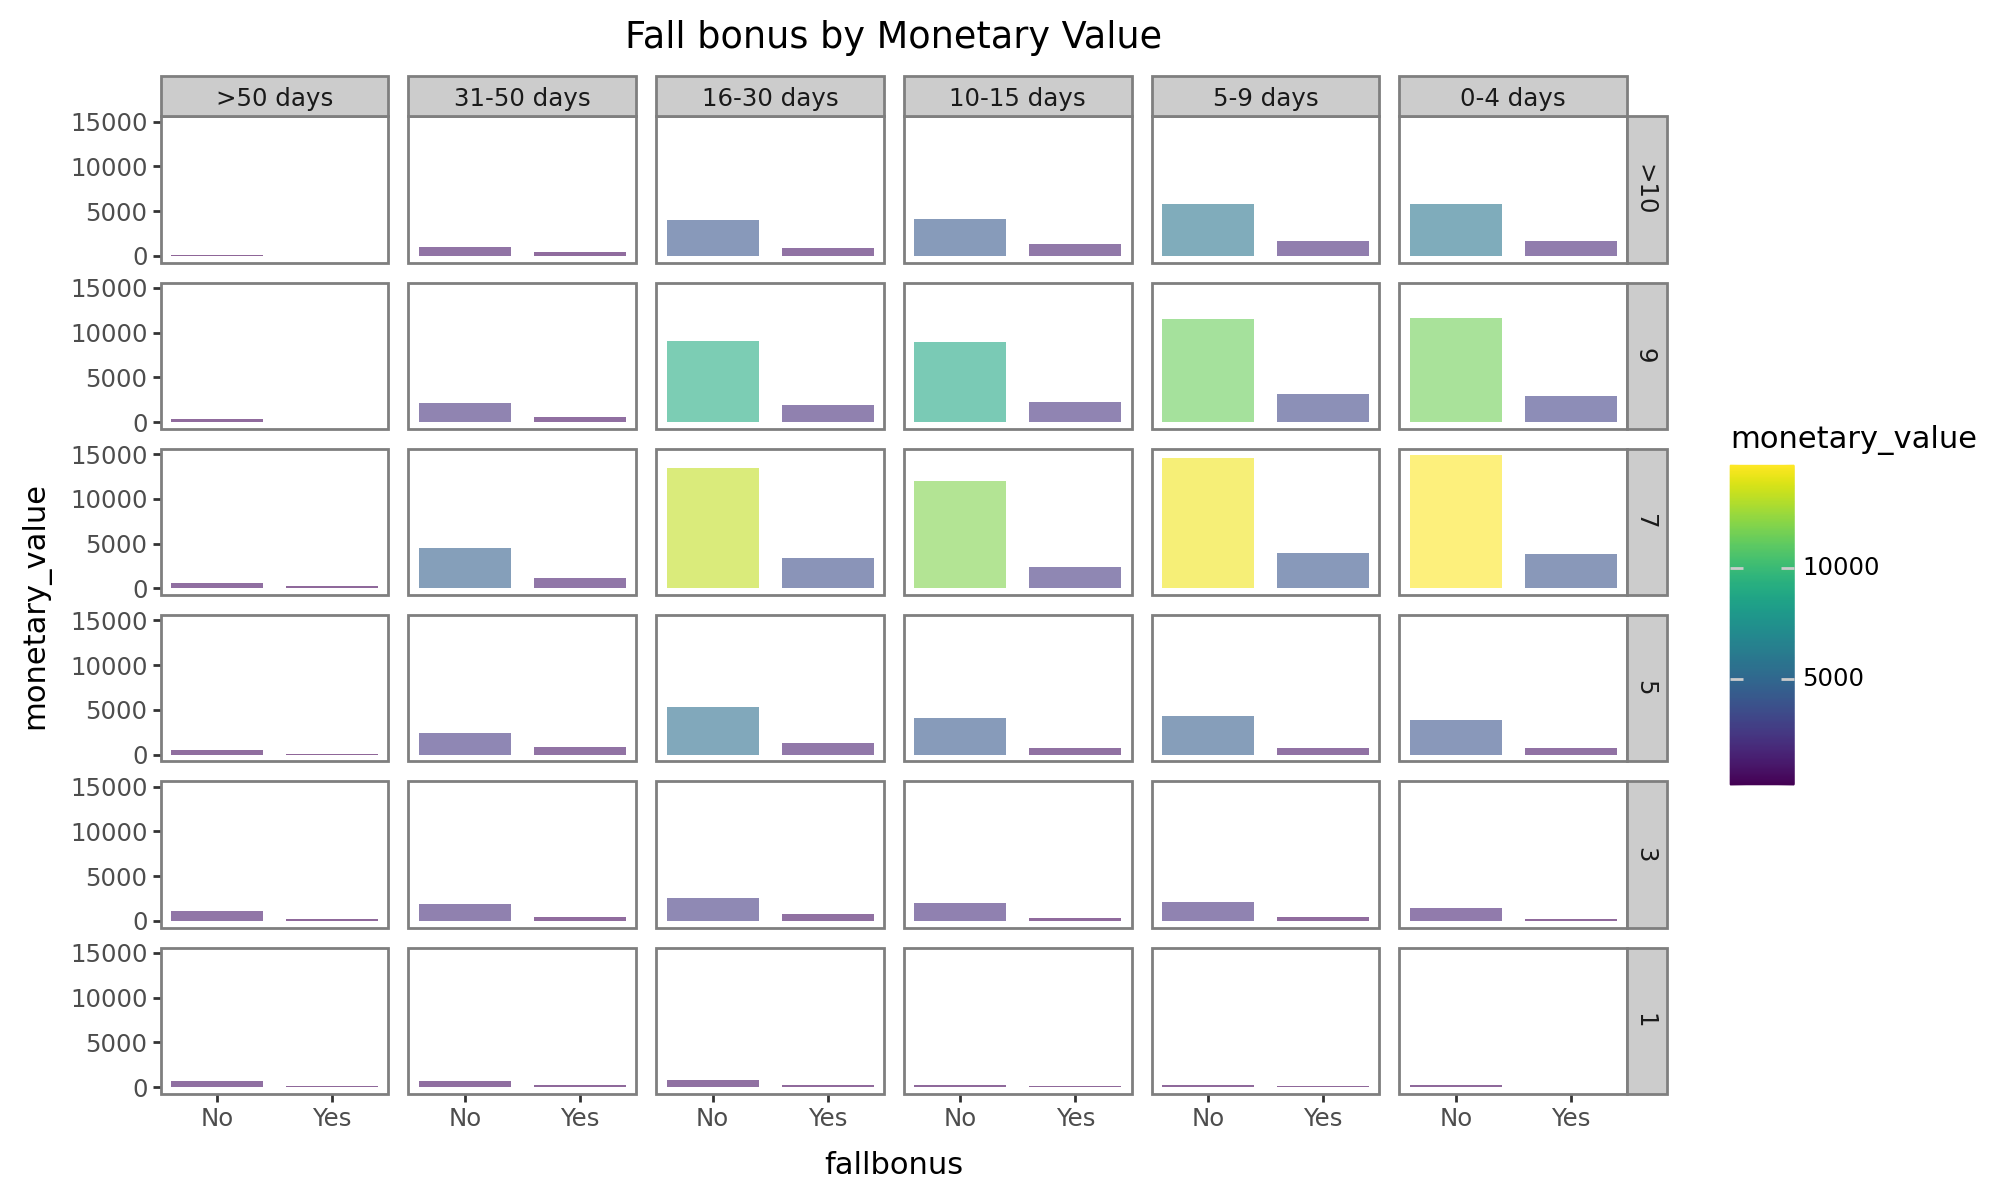

In [76]:
# Fall bonus with Monetary Value (mean)

lcg11= basetable_summerC.groupby(['fallbonus','segmfreq','segmrec'],observed=True, as_index=False).agg(monetary_value=('MonetaryValue', 'sum'))
lcg11['player']='player'

plot1 = (ggplot(lcg11, aes(x='fallbonus', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["No", "Yes"]) +
         ggtitle("Fall bonus by Monetary Value"))

plot1.show()

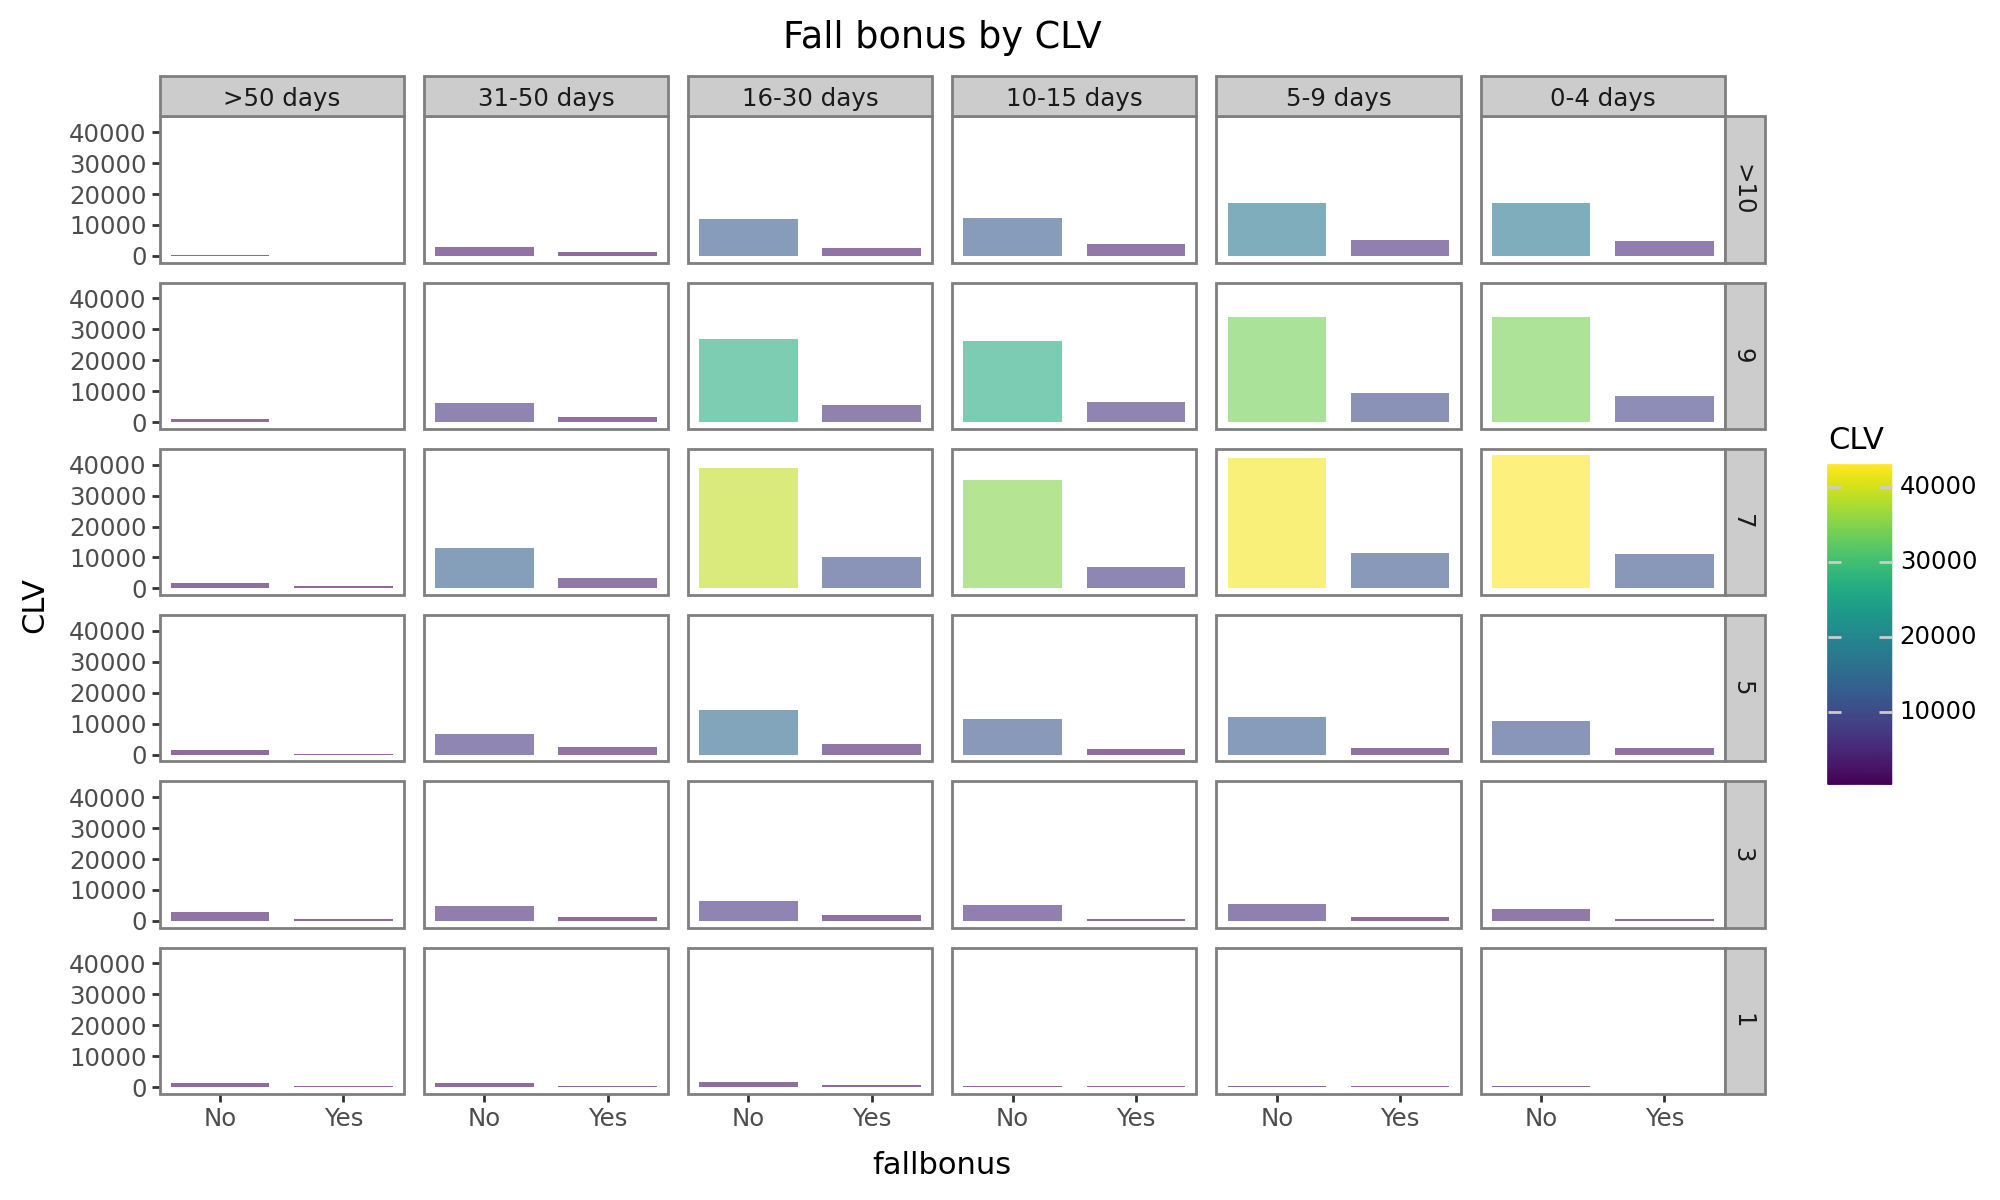

In [77]:
# Fall bonus by CLV
lcg12= basetable_summerC.groupby(['fallbonus','segmfreq','segmrec'],observed=True, as_index=False).agg(CLV=('CLV', 'sum'))
lcg12['player']='player'

plot1 = (ggplot(lcg12, aes(x='fallbonus', y='CLV', fill='CLV')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["No", "Yes"]) +
         ggtitle("Fall bonus by CLV"))

plot1.show()

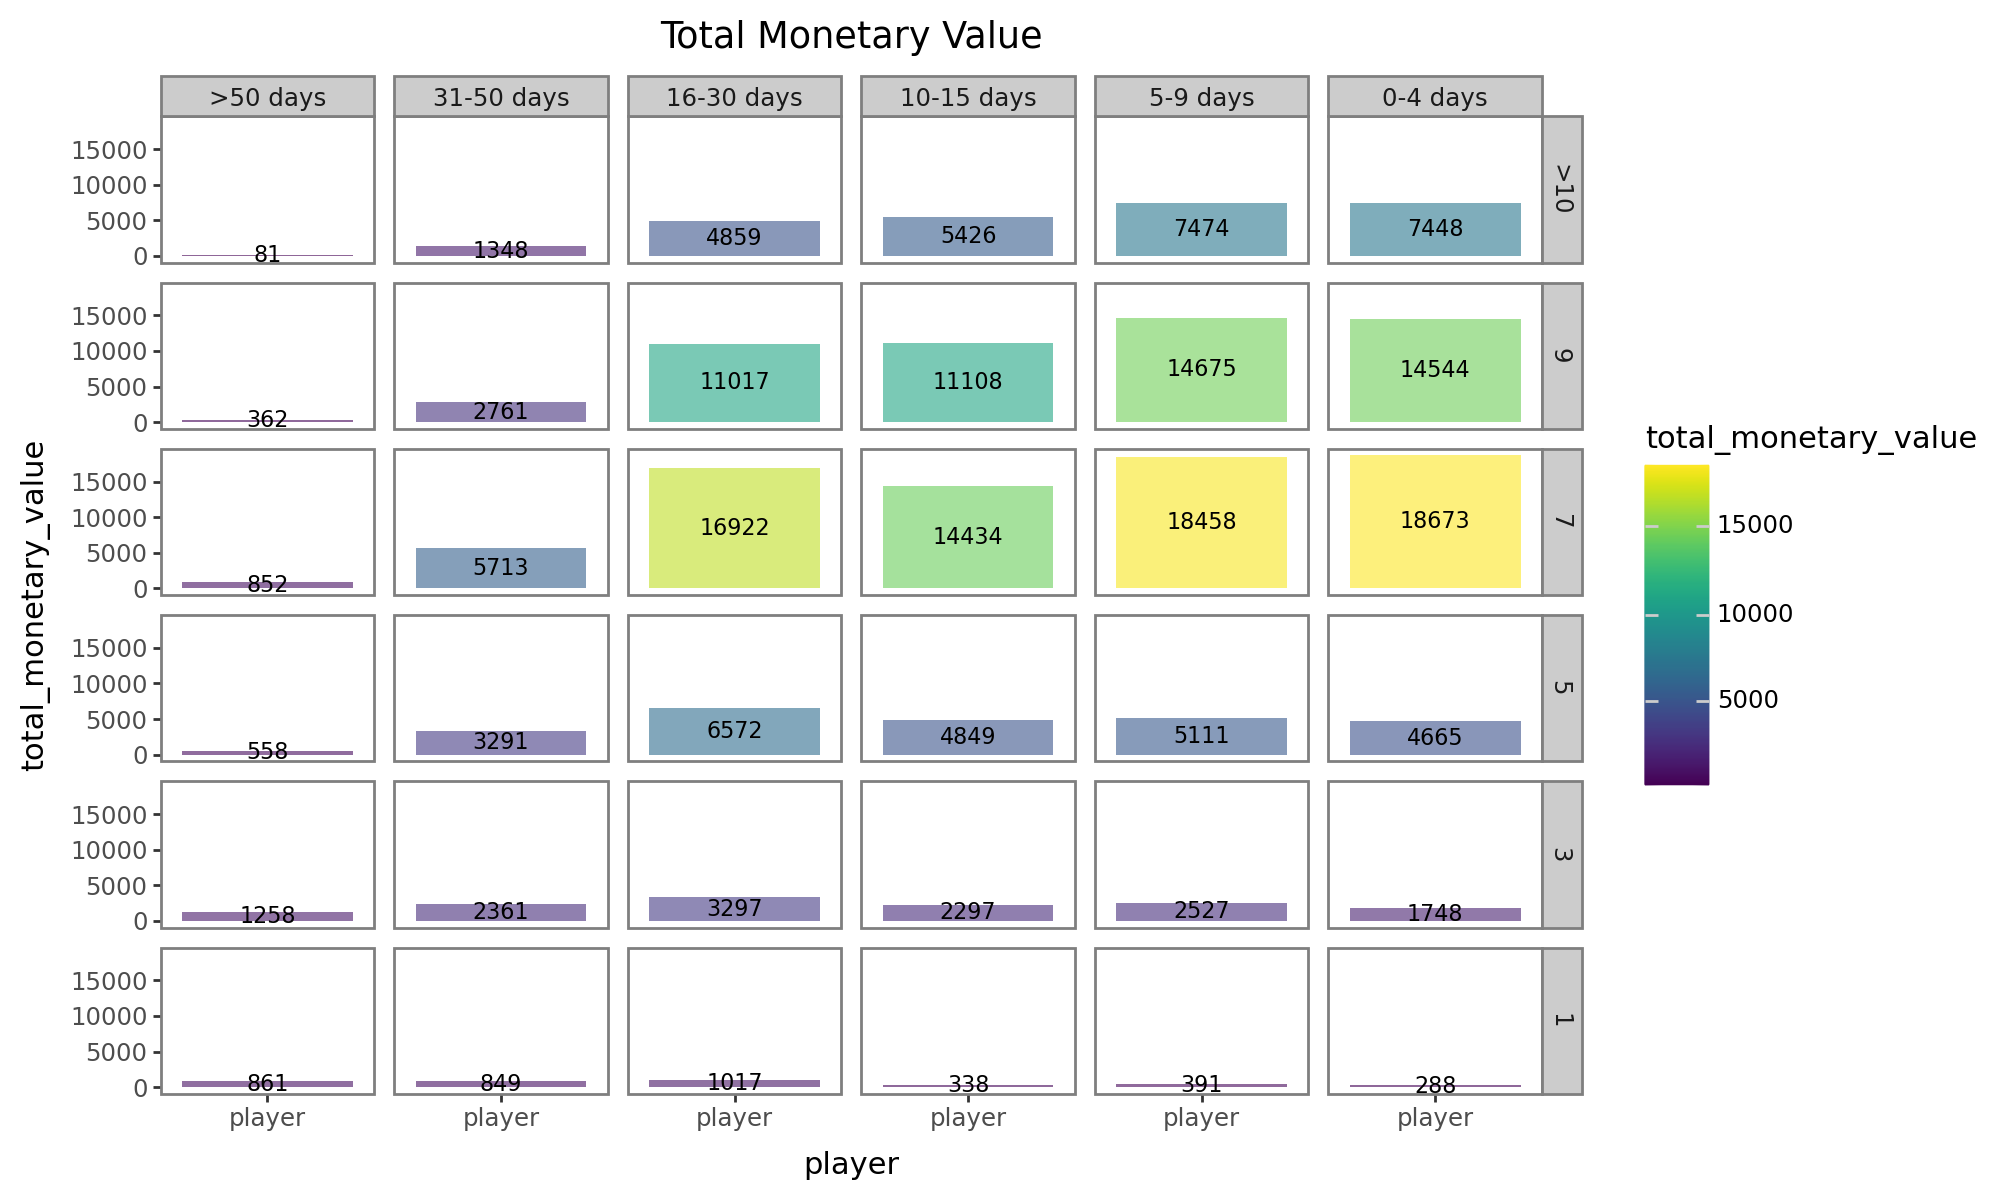

In [78]:
# Total Monetary Value

lcg13= basetable_summerC.groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(total_monetary_value=('MonetaryValue', 'sum'))
lcg13['player']='player'

plot1 = (ggplot(lcg13, aes(x='player', y='total_monetary_value', fill='total_monetary_value')) +
         theme_bw() +  # Apply a clean black-and-white theme
         theme(panel_grid=element_blank(),  # Remove the background grid for clarity
               figure_size=(10, 6),  # Set the figure size
               axis_text_x=element_text(rotation=0)) +  # Ensure x-axis labels are horizontal
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Create bars with some transparency and a specified width
         geom_text(aes(label='total_monetary_value'),  # Add text annotations based on the monetary value
                   position=position_stack(vjust=0.5),  # Center the text within each bar
                   format_string="{:.0f}",  # Optional: Format the numbers (remove decimals)
                   size=8,  # Set text size
                   color="black") +  # Choose a text color that stands out from the bar color
         facet_grid('segmfreq ~ segmrec') +  # Create facets based on frequency and recency
         ggtitle("Total Monetary Value"))  # Set the title of the plot

plot1.show()

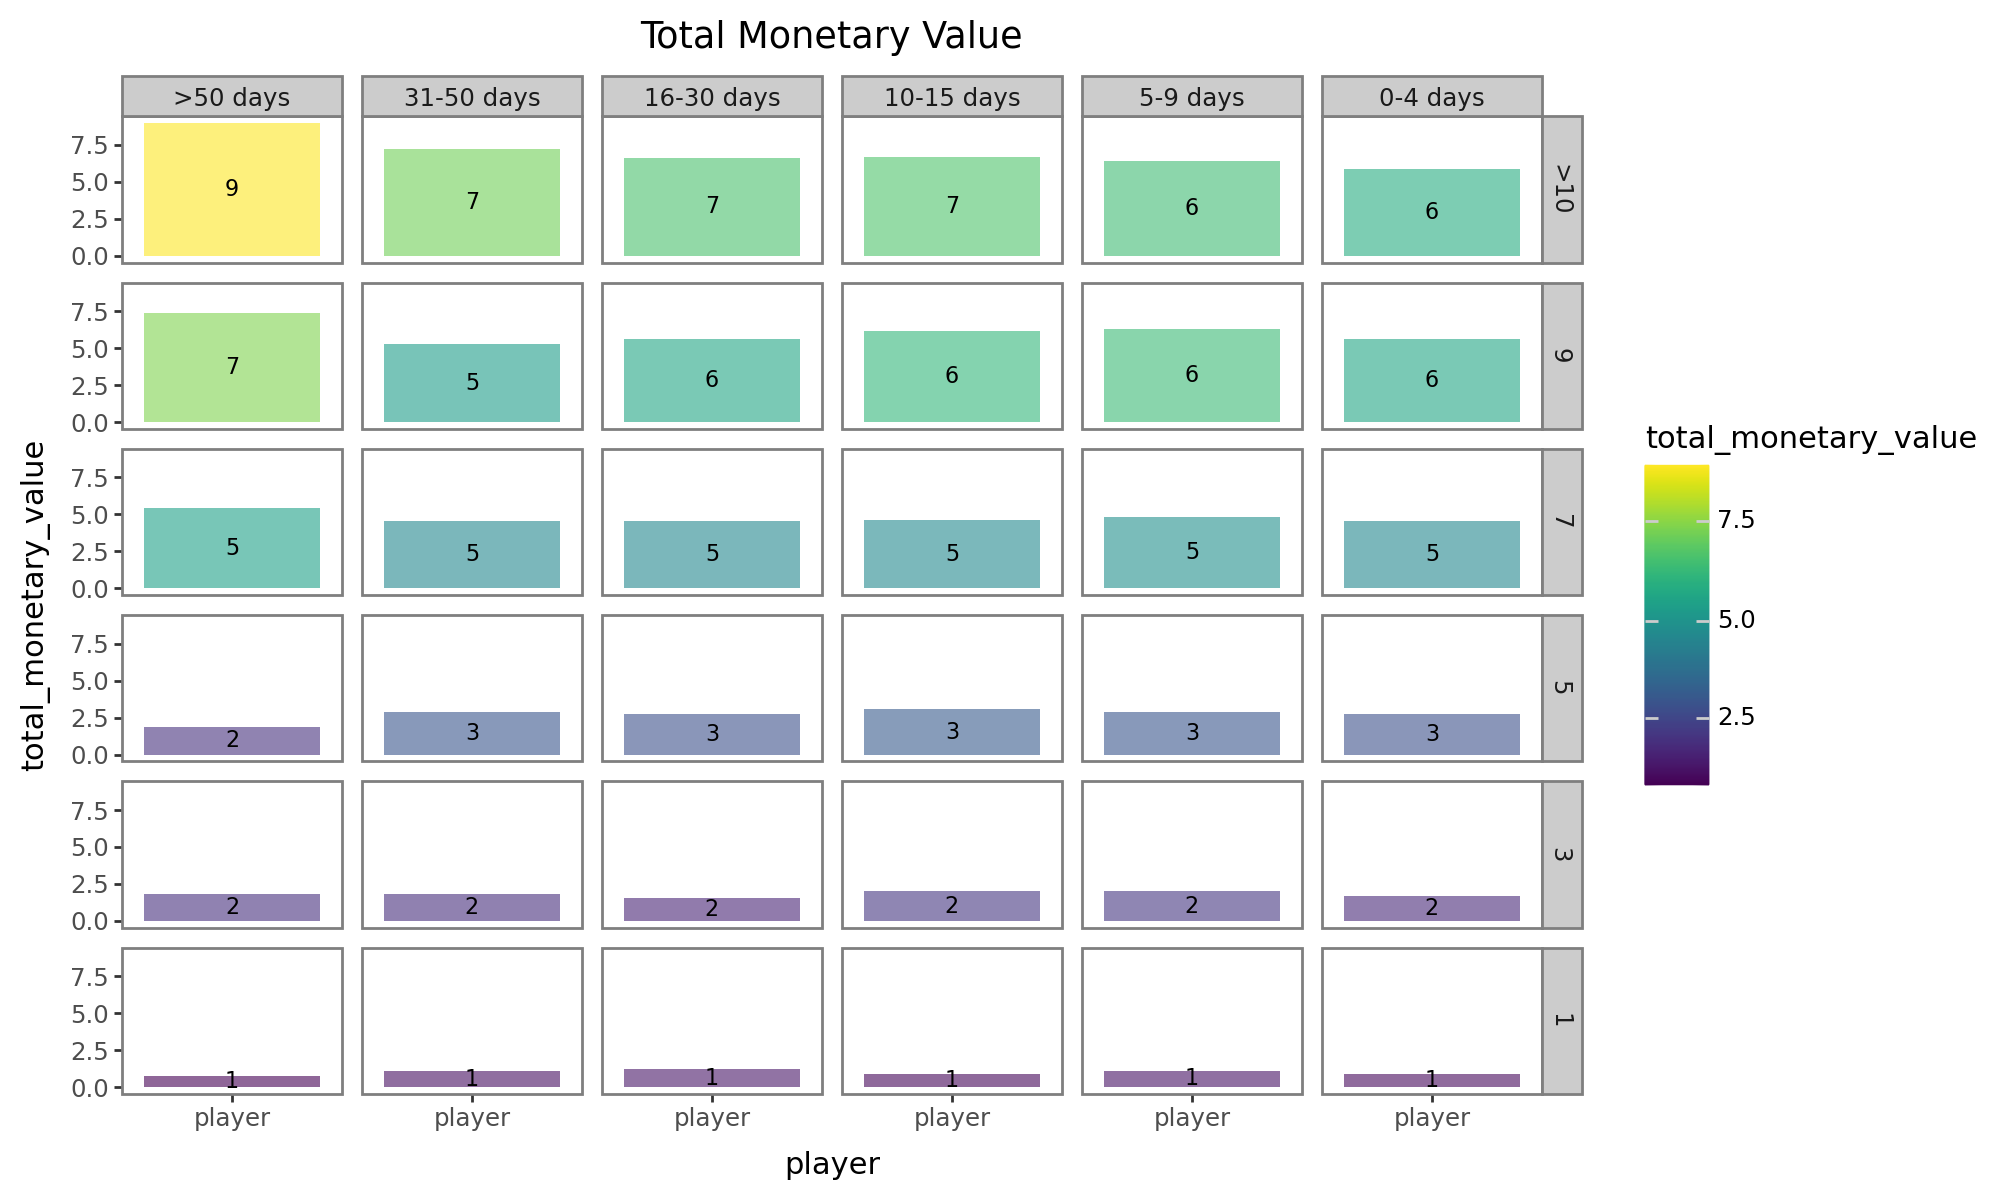

In [79]:
# Total Monetary Value (mean)

lcg13= basetable_summerC.groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(total_monetary_value=('MonetaryValue', 'mean'))
lcg13['player']='player'

plot1 = (ggplot(lcg13, aes(x='player', y='total_monetary_value', fill='total_monetary_value')) +
         theme_bw() +  # Apply a clean black-and-white theme
         theme(panel_grid=element_blank(),  # Remove the background grid for clarity
               figure_size=(10, 6),  # Set the figure size
               axis_text_x=element_text(rotation=0)) +  # Ensure x-axis labels are horizontal
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Create bars with some transparency and a specified width
         geom_text(aes(label='total_monetary_value'),  # Add text annotations based on the monetary value
                   position=position_stack(vjust=0.5),  # Center the text within each bar
                   format_string="{:.0f}",  # Optional: Format the numbers (remove decimals)
                   size=8,  # Set text size
                   color="black") +  # Choose a text color that stands out from the bar color
         facet_grid('segmfreq ~ segmrec') +  # Create facets based on frequency and recency
         ggtitle("Total Monetary Value"))  # Set the title of the plot

plot1.show()

# Churn Analysis

This question focuses on understanding churn in the fall period. Niantic defines churn as a person that played and paid for at least 1 microtransaction in the summer period but does not perform any microtransactions (not paying) during the fall of 2022 According to this definition, calculate which customers have churned in the fall using the fall databases.

## Complete Churner

We identify a player as a complete churner when he makes a purchase in summer but he doesn't repeat this action in fall

In [80]:
summerfintrx

TransactionID       Date  CustomerID  ProductID  SessionID  Value
0                  1 2022-08-06           4          1         21   4.99
1                  2 2022-06-23           8          0         45   2.99
2                  3 2022-06-12           9          1         54   4.99
3                  4 2022-07-23          24          3        170  25.00
4                  5 2022-06-22          24          2        177   9.99
...              ...        ...         ...        ...        ...    ...
21897          21898 2022-05-21       49993          0     379210   2.99
21898          21899 2022-07-20       49993          0     379212   2.99
21899          21900 2022-07-23       49995          0     379225   2.99
21900          21901 2022-06-11       49998          1     379247   4.99
21901          21902 2022-06-24       49998          1     379249   4.99

[21902 rows x 6 columns]

In [81]:
fallfintrx

TransactionID       Date  CustomerID  ProductID  SessionID  Value
0                  1 2022-11-12           4          3         15  25.00
1                  2 2022-09-29           4          1         18   4.99
2                  3 2022-10-09           8          2         35   9.99
3                  4 2022-11-09           9          1         42   4.99
4                  5 2022-12-08          24          2        142   9.99
...              ...        ...         ...        ...        ...    ...
16246          16247 2022-11-06       49980          0     299075   2.99
16247          16248 2022-09-24       49980          0     299079   2.99
16248          16249 2022-10-18       49992          1     299140   4.99
16249          16250 2022-09-29       49992          0     299141   2.99
16250          16251 2022-10-16       49998          3     299171  25.00

[16251 rows x 6 columns]

In [82]:
# summer transactions by CustomerID and flag transactions
summer_summary = summerfintrx.groupby('CustomerID').agg({'TransactionID': 'count'}).reset_index()
summer_summary['summer_trx_flag'] = summer_summary['TransactionID'].apply(lambda x: 1 if x > 0 else 0)

# fall transactions by CustomerID and flag transactions
fall_summary = fallfintrx.groupby('CustomerID').agg({'TransactionID': 'count'}).reset_index()
fall_summary['fall_trx_flag'] = fall_summary['TransactionID'].apply(lambda x: 1 if x > 0 else 0)

# merge
tot_churner = summer_summary[['CustomerID', 'summer_trx_flag']].merge(fall_summary[['CustomerID', 'fall_trx_flag']], how='left', on='CustomerID').fillna(0)

# complete churn = 1 if summer_trx_flag = 1 and fall_trx_flag = 0, otherwise 0
tot_churner['churn'] = tot_churner.apply(lambda x: 1 if x.summer_trx_flag == 1 and x.fall_trx_flag == 0 else 0, axis=1)

tot_churner

CustomerID  summer_trx_flag  fall_trx_flag  churn
0               4                1            1.0      0
1               8                1            1.0      0
2               9                1            1.0      0
3              24                1            1.0      0
4              30                1            0.0      1
...           ...              ...            ...    ...
17165       49983                1            0.0      1
17166       49992                1            1.0      0
17167       49993                1            0.0      1
17168       49995                1            0.0      1
17169       49998                1            1.0      0

[17170 rows x 4 columns]

How many total churner we have?

In [83]:
churn_count = tot_churner['churn'].sum()
churn_persentage = (churn_count / len(tot_churner)) * 100
print(f"The number of churned customers is: {churn_count}")
print(f"The percentage of churned customers is: {churn_persentage:.2f}%")


The number of churned customers is: 5172
The percentage of churned customers is: 30.12%


Now we want to understand how many people churn even though they received the fall bonus!

In [84]:
# Add fall_bonus
customer_churn_with_bonus = tot_churner.merge(customerdata[['CustomerID', 'fallbonus']], how='left', on='CustomerID').fillna(0)

# churn_with_bonus = 1 if both churn and fallbonus are 1, otherwise 0
customer_churn_with_bonus['churn_with_bonus'] = customer_churn_with_bonus.apply(lambda x: 1 if x.churn == 1 and x.fallbonus == 1 else 0, axis=1)

# people with bonus churning
churnbonus_count = customer_churn_with_bonus['churn_with_bonus'].sum()

print(f"The number of churned customers even though they received the bonus is: {churnbonus_count}")
customer_churn_with_bonus

The number of churned customers even though they received the bonus is: 834


CustomerID  summer_trx_flag  fall_trx_flag  churn  fallbonus  \
0               4                1            1.0      0          0   
1               8                1            1.0      0          1   
2               9                1            1.0      0          1   
3              24                1            1.0      0          0   
4              30                1            0.0      1          0   
...           ...              ...            ...    ...        ...   
17165       49983                1            0.0      1          0   
17166       49992                1            1.0      0          1   
17167       49993                1            0.0      1          0   
17168       49995                1            0.0      1          0   
17169       49998                1            1.0      0          1   

       churn_with_bonus  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
17165                 0  
17166                 0  
17167                 0  
17168                 0  
17169                 0  

[17170 rows x 6 columns]

## Partial Churner

Partial churners are customers who have not completely left our company but are gradually reducing their spending or showing signs of declining interest in our product over time. These customers should be a key focus, as fully churned customers are already lost. With the right churn prevention strategy, we have a valuable opportunity to re-engage and retain them.

In [85]:
customer_spending = summerfintrx.groupby('CustomerID').agg({'TransactionID': 'count'}).reset_index()

# total spending for each CustomerID in summer and fall
summer_spending = summerfintrx.groupby('CustomerID').agg({'Value': 'sum'}).reset_index()
summer_spending.columns = ['CustomerID', 'summer_total_spending']

fall_spending = fallfintrx.groupby('CustomerID').agg({'Value': 'sum'}).reset_index()
fall_spending.columns = ['CustomerID', 'fall_total_spending']

# merge
par_churner = customer_spending.merge(summer_spending, how='left', on='CustomerID').merge(fall_spending, how='left', on='CustomerID').fillna(0)

# partial churn = 1 if summer spending is greater than fall spending, 0 otherwise
par_churner['partial_churn'] = par_churner.apply(lambda x: 1 if x.summer_total_spending > x.fall_total_spending else 0, axis=1)

par_churner

CustomerID  TransactionID  summer_total_spending  fall_total_spending  \
0               4              1                   4.99                29.99   
1               8              1                   2.99                 9.99   
2               9              1                   4.99                 4.99   
3              24              2                  34.99                34.99   
4              30              1                   9.99                 0.00   
...           ...            ...                    ...                  ...   
17165       49983              1                   4.99                 0.00   
17166       49992              1                   9.99                 7.98   
17167       49993              3                   8.97                 0.00   
17168       49995              1                   2.99                 0.00   
17169       49998              2                   9.98                25.00   

       partial_churn  
0                  0  
1                  0  
2                  0  
3                  0  
4                  1  
...              ...  
17165              1  
17166              1  
17167              1  
17168              1  
17169              0  

[17170 rows x 5 columns]

How many partial churner we have?

In [86]:
partial_churn_count = (par_churner['partial_churn'].sum()) - (tot_churner['churn'].sum())
partial_churn_percentage = (partial_churn_count / len(par_churner)) * 100
print(f"The number of partial churned customers is: {partial_churn_count}")
print(f"The percentage of churned customers is: {partial_churn_percentage:.2f}%")

The number of partial churned customers is: 4991
The percentage of churned customers is: 29.07%


# Preparation Steps for Churn Prediction

In [87]:
# Ensure CustomerID is numeric in all datasets before merging
tot_churner['CustomerID'] = tot_churner['CustomerID'].astype(int)
customer_churn_with_bonus['CustomerID'] = customer_churn_with_bonus['CustomerID'].astype(int)
par_churner['CustomerID'] = par_churner['CustomerID'].astype(int)
basetable_summerC['CustomerID'] = basetable_summerC['CustomerID'].astype(int)

# Merge churn-related columns into basetable_summerC
basetable_summerC = basetable_summerC.merge(
    customer_churn_with_bonus[['CustomerID', 'churn', 'churn_with_bonus']],
    how='inner',
    on='CustomerID'
).merge(
    par_churner[['CustomerID', 'partial_churn']],
    how='inner',
    on='CustomerID'
).merge(
    summersesstrx[['CustomerID', 'Duration', 'Experience']],
    how='inner',
    on='CustomerID'
)
# Drop duplicate records based on CustomerID
basetable_summerC = basetable_summerC.drop_duplicates(subset='CustomerID')

# Display the final merged dataset
basetable_summerC

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0                4          9       11             3       2022-04-10       1   
9                8          7       37             3       2016-11-05       0   
16               9          4       44             3       2019-07-10       1   
20              24         10       25             2       2022-03-03       0   
30              30         10       61             0       2022-02-03       0   
...            ...        ...      ...           ...              ...     ...   
145705       49983          5       41             0       2019-11-03       0   
145710       49992          3       68             1       2021-10-06       0   
145713       49993          8       11             0       2017-06-14       1   
145721       49995          6        7             3       2020-09-29       0   
145727       49998          6       22             2       2018-07-26       0   

        Age  fallbonus  Income  MonetaryValue  ... spending_cat cohort  \
0        18          0       2           4.99  ...           VL   2022   
9        35          1       2           2.99  ...           VL   2016   
16       15          1       2           4.99  ...           VL   2019   
20       12          0       0          34.99  ...            L   2022   
30       31          0       0           9.99  ...           VL   2022   
...     ...        ...     ...            ...  ...          ...    ...   
145705   13          0       1           4.99  ...           VL   2019   
145710   33          1       2           9.99  ...           VL   2021   
145713   29          0       1           8.97  ...           VL   2017   
145721   46          0       0           2.99  ...           VL   2020   
145727   27          1       1           9.98  ...           VL   2018   

       spending         CLV  age_group  churn  churn_with_bonus partial_churn  \
0             1   14.536480       6-17      0                 0             0   
9             1    8.309434      28-37      0                 0             0   
16            1   14.536480       6-17      0                 0             0   
20            1  107.942173       6-17      0                 0             0   
30            1   30.104096      28-37      1                 0             1   
...         ...         ...        ...    ...               ...           ...   
145705        1   14.536480       6-17      1                 0             1   
145710        1   30.104096      28-37      0                 0             1   
145713        1   26.928302      28-37      1                 0             1   
145721        1    8.309434      38-49      1                 0             1   
145727        1   30.072960      18-27      0                 0             0   

          Duration  Experience  
0        34.045347        4926  
9        24.351015        3944  
16       18.415372        3550  
20       99.667706        2399  
30       65.535523        3673  
...            ...         ...  
145705   61.700267        4797  
145710   27.950804        5141  
145713   68.623053        3453  
145721   27.079341        3947  
145727  118.615943        9962  

[17170 rows x 23 columns]

In [88]:
partial_churn_proof = (basetable_summerC['partial_churn'].sum()) - (basetable_summerC['churn'].sum())
partial_churn_proof

4991

In [89]:
'''
basetable_summerC.to_csv('basetable_summerC.csv', index=False)
files.download('basetable_summerC.csv')
'''

"\nbasetable_summerC.to_csv('basetable_summerC.csv', index=False)\nfiles.download('basetable_summerC.csv')\n"

# Descriptive Statistics for Churner

In [90]:
churn_stats = basetable_summerC.groupby('CustomerType').agg(
    total_customers=('CustomerID', 'nunique'),
    churn_count=('churn', 'sum')
)

# Calculate the churn rate as a percentage for each CustomerType
churn_stats['churn_rate'] = (churn_stats['churn_count'] / churn_stats['total_customers']) * 100

# Display the churn rate by customer type
print(churn_stats)

              total_customers  churn_count  churn_rate
CustomerType                                          
0                        3106          717   23.084353
1                        2812          709   25.213371
2                        7090         2830   39.915374
3                        4162          916   22.008650


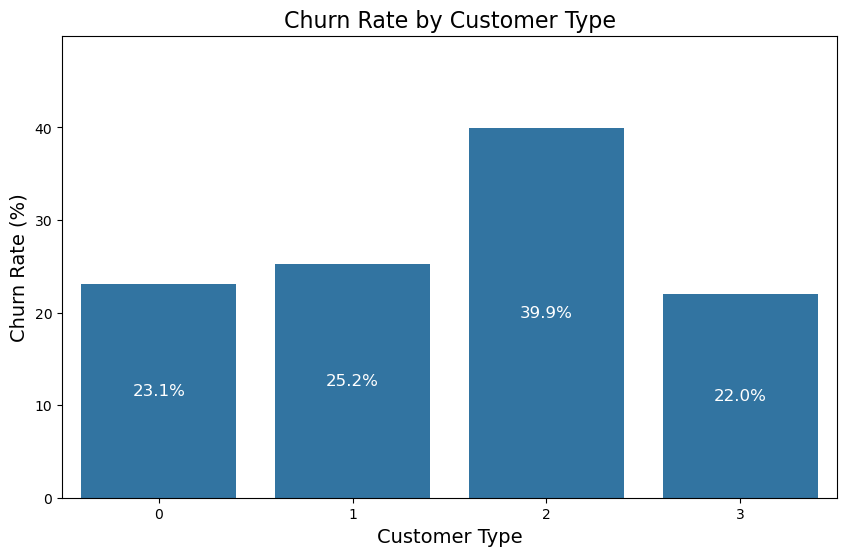

In [91]:
# bar plot for churn rate by customer type
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=churn_stats.index.astype(str), y=churn_stats['churn_rate'])

# Add labels inside each bar, centered both horizontally and vertically
for i, rate in enumerate(churn_stats['churn_rate']):
    ax.text(i, rate / 2, f"{rate:.1f}%", ha='center', va='center', color='white', fontsize=12)

plt.xlabel('Customer Type', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.title('Churn Rate by Customer Type', fontsize=16)
plt.ylim(0, churn_stats['churn_rate'].max() + 10)
plt.show()

In [92]:
# bit of changes for better visualization
churners = basetable_summerC[basetable_summerC['churn'] == 1]
churners['CustomerType'] = churners['CustomerType'].replace({0: 'Walker', 1: 'Miscellaneous', 2: 'Social Raider', 3: 'Catcher'})

# Display basic descriptive statistics for numerical variables (Age, Income)
print("Descriptive Statistics for Churners (Age & Income):")
print(churners[['Age', 'Income']].describe())

Descriptive Statistics for Churners (Age & Income):
               Age       Income
count  5172.000000  5172.000000
mean     27.839714     0.666087
std      13.883707     0.797687
min       6.000000     0.000000
25%      18.000000     0.000000
50%      28.000000     0.000000
75%      34.000000     1.000000
max      80.000000     2.000000


C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\1445629366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


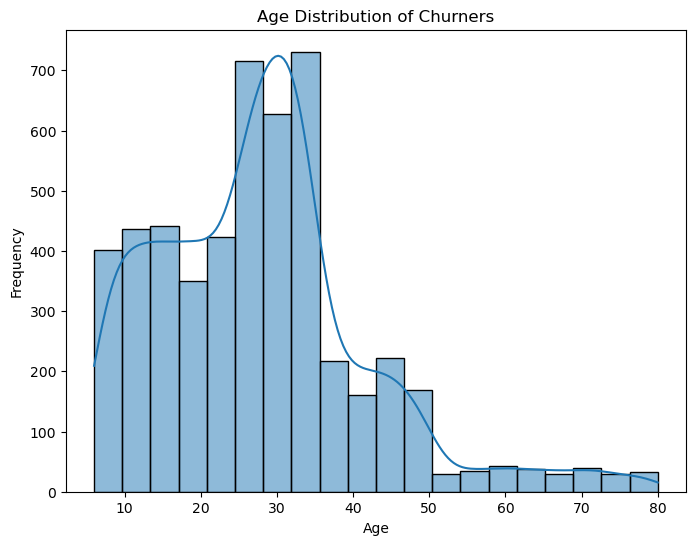

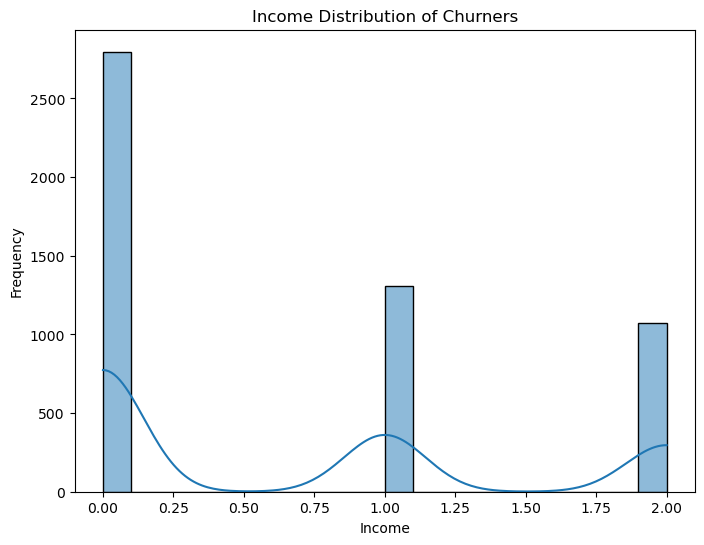

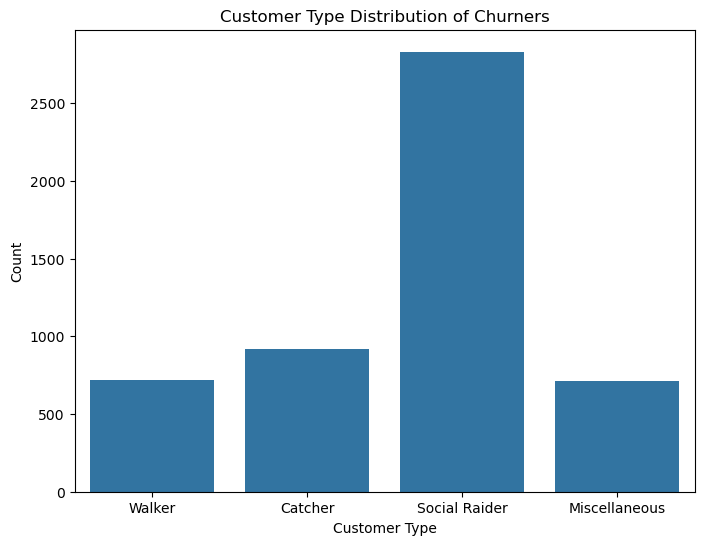

In [93]:
# Age distribution of churners
plt.figure(figsize=(8,6))
sns.histplot(churners['Age'], bins=20, kde=True)
plt.title("Age Distribution of Churners")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Income distribution of churners
plt.figure(figsize=(8,6))
sns.histplot(churners['Income'], bins=20, kde=True)
plt.title("Income Distribution of Churners")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

# CustomerType distribution of churners
plt.figure(figsize=(8,6))
sns.countplot(data=churners, x='CustomerType')
plt.title("Customer Type Distribution of Churners")
plt.xlabel("Customer Type")
plt.ylabel("Count")
plt.show()

# Churn Analysis and Predictions

In [94]:
# Preparing the basetable for logistic regression
basetable_summerC['CustomerType'] = basetable_summerC['CustomerType'].replace({0: 'Walker', 1: 'Miscellaneous', 2: 'Social Raider', 3: 'Catcher'})
basetable_summerC=pd.get_dummies(basetable_summerC, prefix=None, drop_first=True)
basetable_summerC = basetable_summerC.replace({True:1, False:0})
basetable_summerC['CustomerType_SocialRaider'] = basetable_summerC['CustomerType_Social Raider']

# Check the data types of all variables in the dataset
print(basetable_summerC.dtypes)

CustomerID                             int32
frequency                              int64
recency                                int32
Registrationdate              datetime64[ns]
Gender                                 int64
Age                                    int64
fallbonus                              int64
Income                                 int64
MonetaryValue                        float64
cohort                                 int32
spending                               int32
CLV                                  float64
churn                                  int64
churn_with_bonus                       int64
partial_churn                          int64
Duration                             float64
Experience                             int64
CustomerType_Miscellaneous             int64
CustomerType_Social Raider             int64
CustomerType_Walker                    int64
segmfreq_9                             int64
segmfreq_7                             int64
segmfreq_5

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\1999947396.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [95]:
# Convert specific columns from float to integers
basetable_summerC['MonetaryValue'] = basetable_summerC['MonetaryValue'].astype(int)
basetable_summerC['CLV'] = basetable_summerC['CLV'].astype(int)

In [96]:
# Logistic regression

# split into test and train
train, test = train_test_split(basetable_summerC, test_size=0.3,random_state=1)

# model building for churn prediction
#logit_mod = smf.logit(formula='churn ~ frequency+MonetaryValue+recency+Age+Income+Gender+CLV+Duration+Experience+CustomerType_Miscellaneous+CustomerType_SocialRaider+CustomerType_Walker', data=train)
#logit_res = logit_mod.fit()
#print(logit_res.summary())

# use the professor stepwise function to determine the final model

X=train[['frequency', 'MonetaryValue', 'Age', 'Income', 'Gender', 'CustomerType_Miscellaneous', 'CustomerType_SocialRaider', 'CustomerType_Walker', 'Experience', 'cohort']]
Y=train['churn']
forward=forwardSelection(X, Y,model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
forward[2].summary()
backward=backwardSelection(X, Y,model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
backward[2].summary()
bidirectional=BidirectionalStepwiseSelection(X,Y,model_type="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst",senter=0.05, sstay=0.05)
bidirectional[2].summary()

Xtrain=train[np.intersect1d(train.columns,forward[0])] # only select var retained from backbward selection
Xtrain=Xtrain.reindex(columns=forward[0]) # sort them according to the sequence used in the regression
Xtrain['intercept']=1 # add constant variable
train['predict']=forward[2].predict(Xtrain) # store prediction in corresponding dataset

Xtest=test[np.intersect1d(test.columns,forward[0])] # only select var retained from backbward selection
Xtest=Xtest.reindex(columns=forward[0]) # sort them according to the sequence used in the regression
Xtest['intercept']=1 # add constant variable
test['predict']=forward[2].predict(Xtest) # store prediction in corresponding dataset

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.608684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605885
         Iterations 5
Optimization te

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Optimization terminated successfully.
         Current function value: 0.591758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591758
         Iterations 6
Entered : cohort 	AIC : 14230.667800592653
Optimization terminated successfully.
         Current function value: 0.590847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591753
         Iterations 6
Optimization terminated successfully.
 

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Optimization terminated successfully.
         Current function value: 0.590842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7
Entered : CustomerType_Miscellaneous 	AIC : 14208.605428714352
Optimization terminated successfully.
         Current function value: 0.590625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590669
         Iterations 7
Optimization termin

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                12019
Model:                          Logit   Df Residuals:                    12014
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.02959
Time:                        23:43:22   Log-Likelihood:                -7099.3
converged:                       True   LL-Null:                       -7315.8
Covariance Type:            nonrobust   LLR p-value:                 2.104e-92
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                   -175.9290     30.003     -5.864      0.000    -234.734    -117.124
CustomerType_SocialRaider      0.7773      0.048     16.283      0.000       0.684 

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtype

Optimization terminated successfully.
         Current function value: 0.608390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592656
  

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtype

break : No need to Backward Elimination
Entered : cohort 	AIC : 14230.667800592653
Optimization terminated successfully.
         Current function value: 0.590847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590847
         Iterations 7

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


The logistic regression model reveals several factors;

- Customers with a longer Duration are more likely to leave, suggesting that sustained engagement strategies are essential to be implemented

- Receiving a fallbonus lowers churn risk, confirming the value of seasonal promotions.

- CustomerTypes are prone to exit, indicating that targeted retention efforts should focus on these higher-risk segments.

- Recency shows that customers who have not interacted for a while are at greater risk of churning, while Experience implies that seasoned users may lose interest unless given new incentives.

- Frequency indicates that even frequent interactions can precede churn, underscoring the need for deeper, more personalized engagement rather than relying solely on high usage.

C:\Users\CG121\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\CG121\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Cutoff used:  0.5
          Predicted 0  Predicted 1
Actual 0         8444            0
Actual 1         3575            0
Accuracy Score :  70.26
ROC AUC score :  61.36
Precision score :  0.0
sensitivity score :  0.0
specificity score :  100.0
<ggplot: (640 x 480)>
Cutoff used:  0.5
          Predicted 0  Predicted 1
Actual 0         3554            0
Actual 1         1597            0
Accuracy Score :  69.0
ROC AUC score :  62.05
Precision score :  0.0
sensitivity score :  0.0
specificity score :  100.0
<ggplot: (640 x 480)>
percentage churn in train dataset:  29.74
percentage churn in test dataset:  31.0


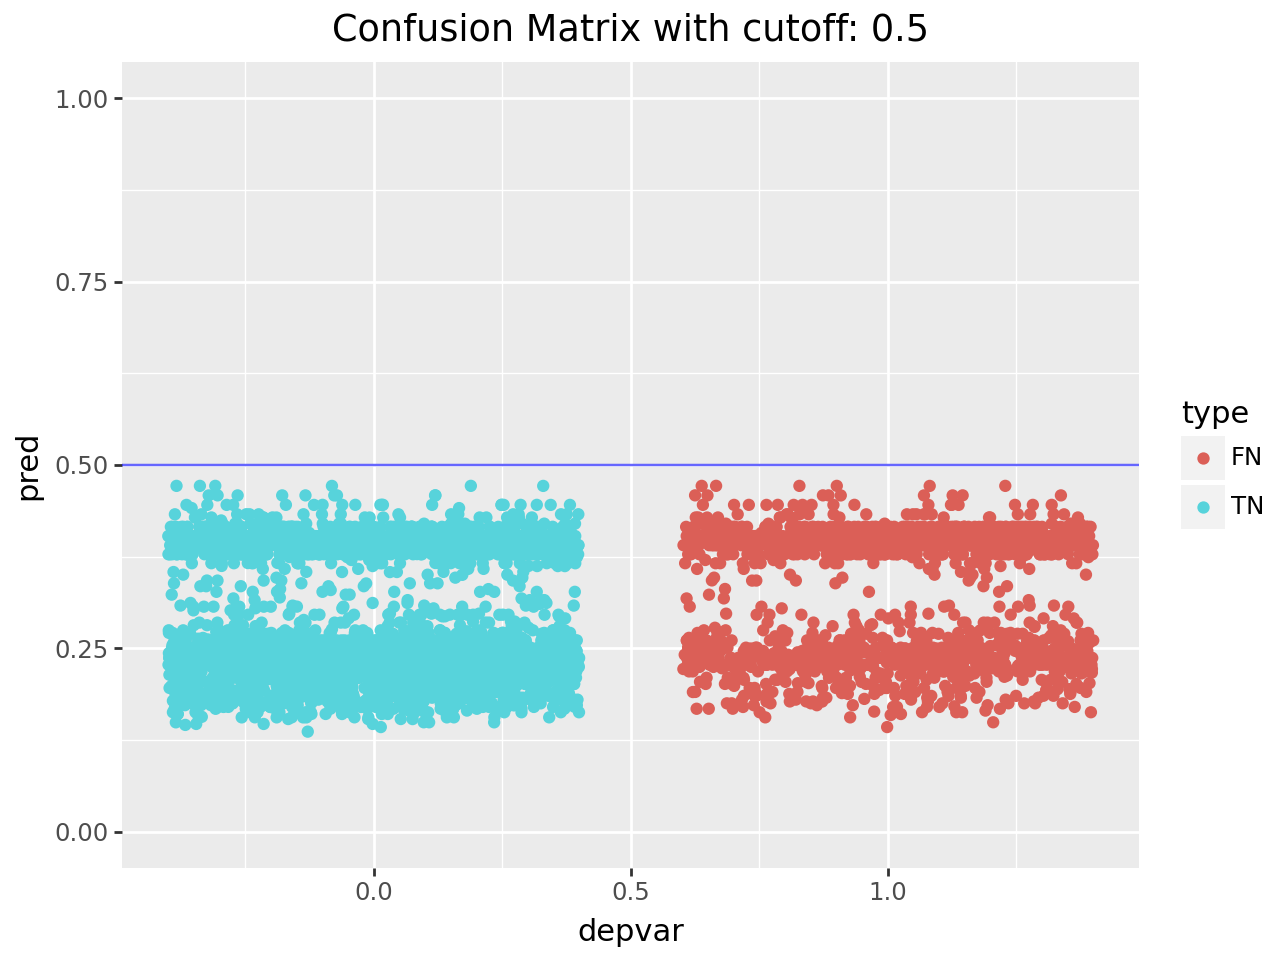

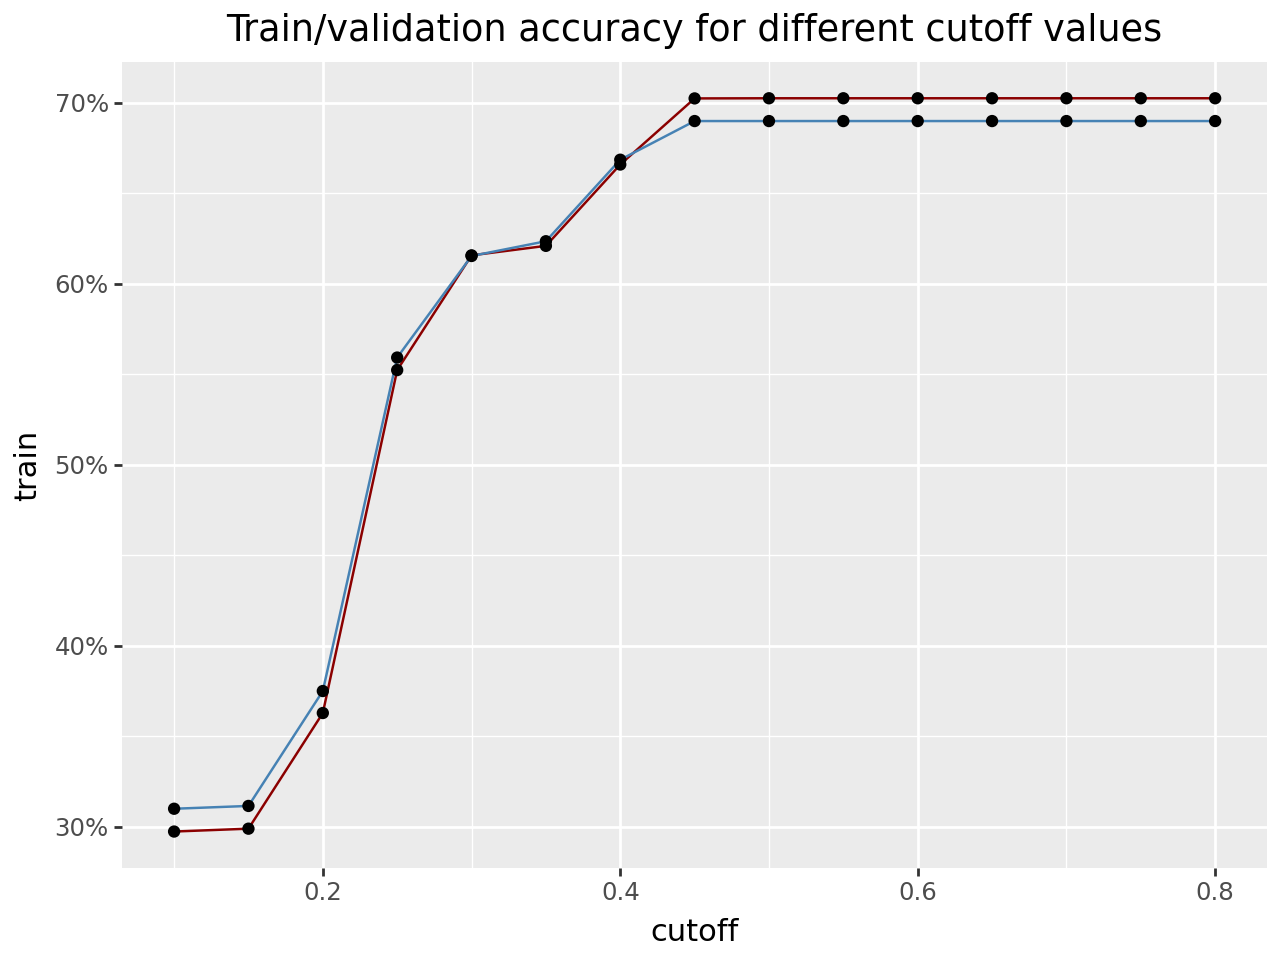

In [97]:
# performance with cutoff 0.5 just to initialize
performance=evaluate_model(train['churn'],train['predict'])
performance=evaluate_model(test['churn'],test['predict'])

print('percentage churn in train dataset: ',np.round(np.mean(train['churn'])*100,2))
print('percentage churn in test dataset: ',np.round(np.mean(test['churn'])*100,2))

#confusion matrix for opt cutoff
confusionmatrixplot(test['churn'],test['predict'],cutoff=0.5)

#how does the accuracy change for different cutoff values
AccuracyCutoffInfo(train,test,depvar='churn',pred='predict')

In [98]:
test['churn']

17548     0
56149     0
127180    0
73887     1
111838    0
         ..
41514     0
132405    0
34009     0
40328     0
132000    1
Name: churn, Length: 5151, dtype: int64

In [99]:
test['predict']

17548     0.225784
56149     0.209801
127180    0.162695
73887     0.402943
111838    0.402943
            ...   
41514     0.227454
132405    0.201278
34009     0.415562
40328     0.182508
132000    0.402943
Name: predict, Length: 5151, dtype: float64

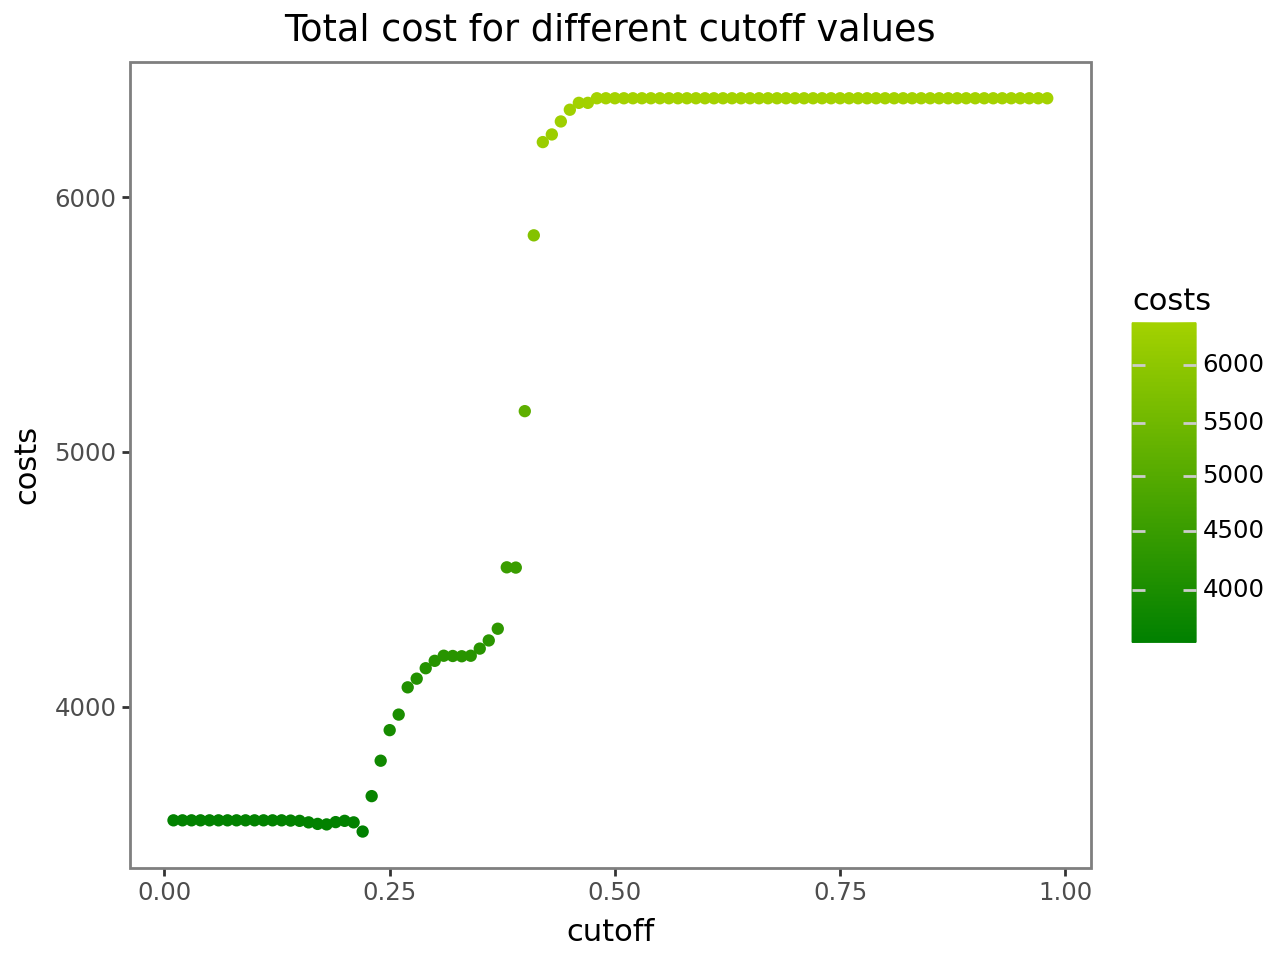

best cutoff:  0.22
Cutoff used:  0.3
          Predicted 0  Predicted 1
Actual 0         2306         1248
Actual 1          733          864
Accuracy Score :  61.54
ROC AUC score :  62.05
Precision score :  40.91
sensitivity score :  54.1
specificity score :  64.88
<ggplot: (640 x 480)>
percentage churn in train dataset:  29.74
percentage churn in test dataset:  31.0


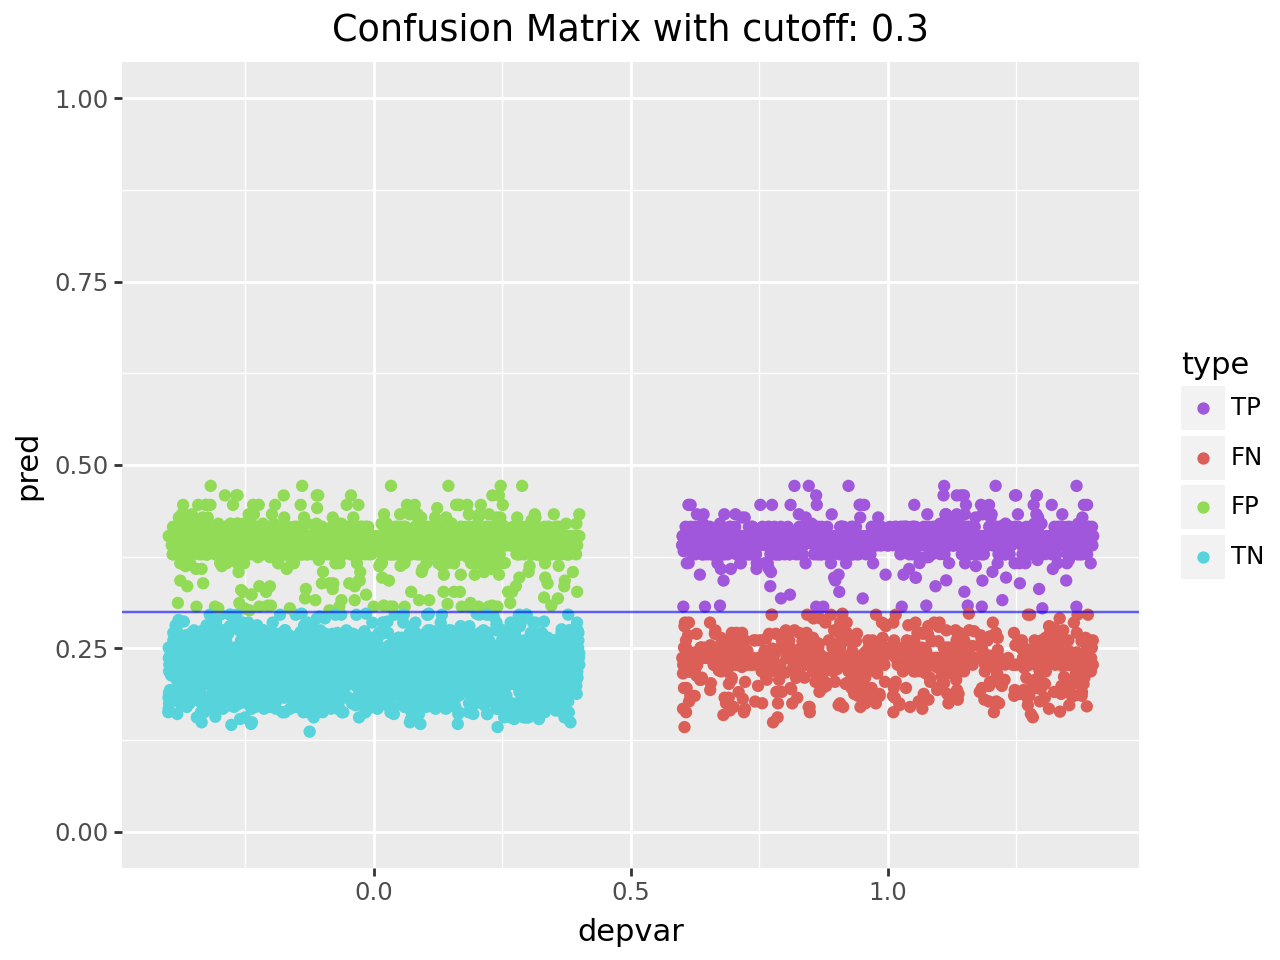

C:\Users\CG121\anaconda3\Lib\site-packages\plotnine\stats\smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


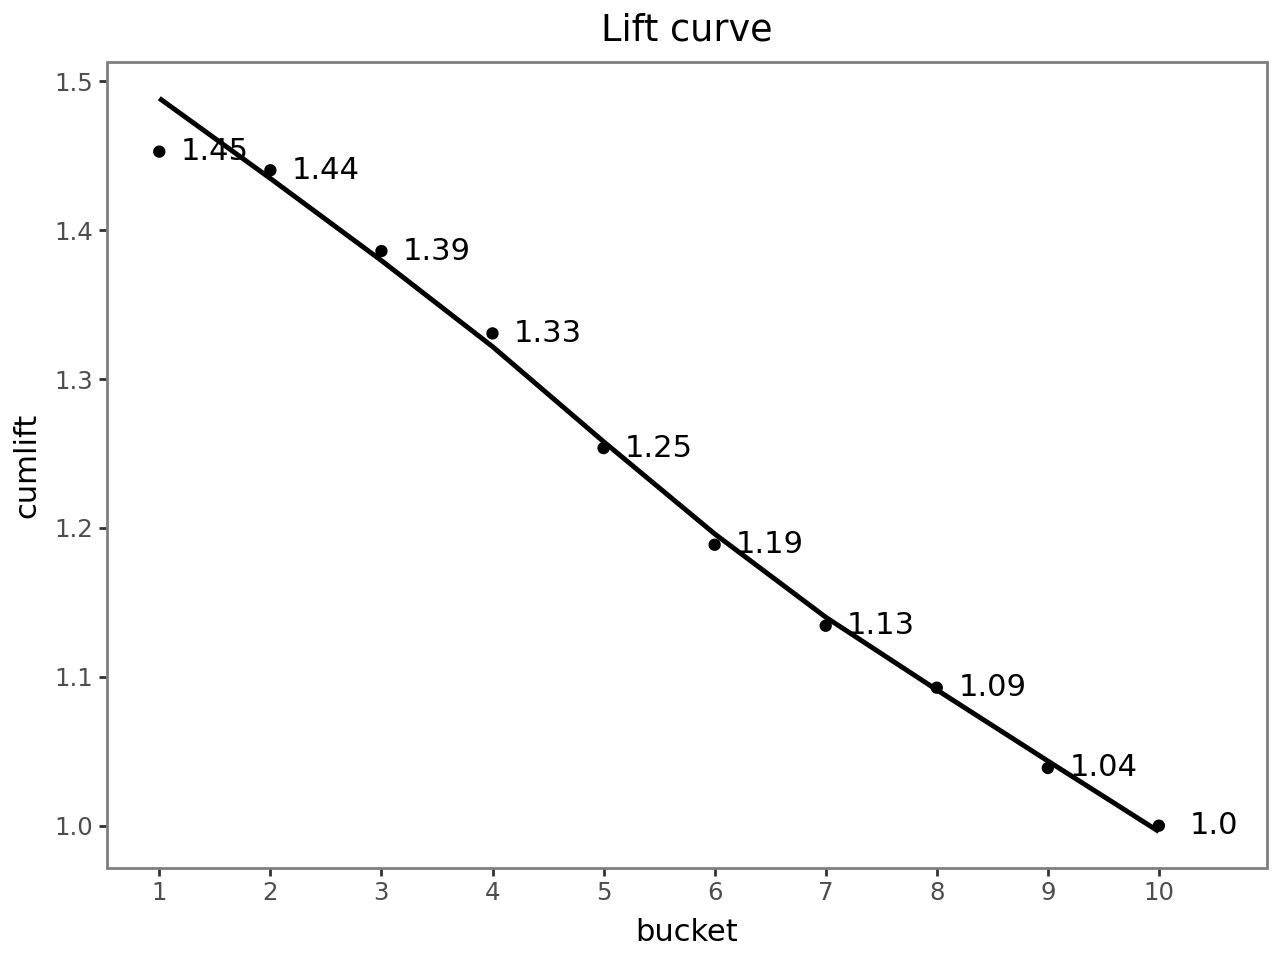

In [100]:
#find optimal cutoff to balance the accuracy
optcutoff=findoptcutoff(test['churn'],test['predict'])

# performance with optimal cutoff
performance=evaluate_model(test['churn'],test['predict'],cutoff=0.3) # we deleted the best cutoff because it gives us 0.01, meaning everyone is considered as a churner, selected 0.3 as cutoff based on the train/validation accuracy graph

print('percentage churn in train dataset: ',np.round(np.mean(train['churn'])*100,2))
print('percentage churn in test dataset: ',np.round(np.mean(test['churn'])*100,2))

#confusion matrix for opt cutoff
confusionmatrixplot(test['churn'],test['predict'],cutoff=0.3)

lifttabletest=plot_liftchart(test['churn'],test['predict'])

This is the prediction with the optimal cutoff. We are assuming that the cost of providing a discoount is equal to the acquisition cost that is equal to 1.

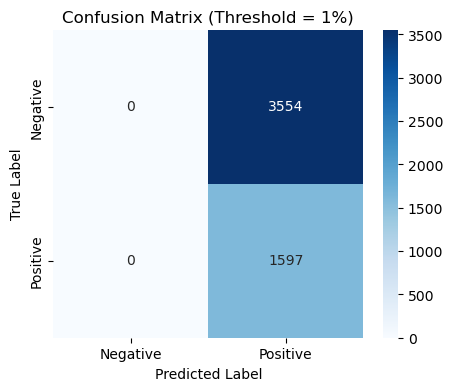

In [101]:
from sklearn.metrics import confusion_matrix

# Example: Assume df contains the true labels and predicted probabilities
# df = pd.DataFrame({"y_true": [...], "y_prob": [...]})

# Define threshold
threshold = 0.01

# Convert probabilities to binary predictions based on threshold
test["pred"] = (test["predict"] >= threshold).astype(int)

# Compute confusion matrix
conf_mat = confusion_matrix(test["churn"], test["pred"])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Threshold = {threshold*100:.0f}%)")
plt.show()

At a 0.01 as optimal cutoff, almost everyone is flagged as a churner. This means the model catches all churners (100% recall) but mislabels every non-churner (0% specificity). Because we are providing a virtual product and in practice, the fallbonus costs us essentially nothing. In other words, it is optimal for us to consider every paying customer a potential churner for the sake of our marketing.

In [102]:
# The same analysis but only for SocialRaiders
SocialRaiders = basetable_summerC[basetable_summerC['CustomerType_SocialRaider']==1]
SocialRaiders.columns

Index(['CustomerID', 'frequency', 'recency', 'Registrationdate', 'Gender',
       'Age', 'fallbonus', 'Income', 'MonetaryValue', 'cohort', 'spending',
       'CLV', 'churn', 'churn_with_bonus', 'partial_churn', 'Duration',
       'Experience', 'CustomerType_Miscellaneous',
       'CustomerType_Social Raider', 'CustomerType_Walker', 'segmfreq_9',
       'segmfreq_7', 'segmfreq_5', 'segmfreq_3', 'segmfreq_1',
       'segmrec_31-50 days', 'segmrec_16-30 days', 'segmrec_10-15 days',
       'segmrec_5-9 days', 'segmrec_0-4 days', 'segmage_18-27',
       'segmage_28-37', 'segmage_38-49', 'segmage_50-80', 'spending_cat_L',
       'spending_cat_M', 'spending_cat_H', 'spending_cat_VH',
       'age_group_18-27', 'age_group_28-37', 'age_group_38-49',
       'age_group_50-80', 'CustomerType_SocialRaider'],
      dtype='object')

In [103]:
# split into test and train
trainS, testS = train_test_split(SocialRaiders, test_size=0.3,random_state=1)

# model building for churn prediction
#logit_mod = smf.logit(formula='churn ~ frequency+MonetaryValue+recency+Age+Income+Gender+CLV+Duration+Experience+CustomerType_Miscellaneous+CustomerType_SocialRaider+CustomerType_Walker', data=train)
#logit_res = logit_mod.fit()
#print(logit_res.summary())

# use the professor stepwise function to determine the final model

XS=trainS[['frequency', 'MonetaryValue', 'Age', 'Income', 'Gender','cohort', 'fallbonus', 'Experience']]
YS=trainS['churn']
forwardS=forwardSelection(XS, YS,model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
forwardS[2].summary()
backwardS=backwardSelection(XS, YS,model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
backwardS[2].summary()
bidirectionalS=BidirectionalStepwiseSelection(XS,YS,model_type="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst",senter=0.05, sstay=0.05)
bidirectionalS[2].summary()

XtrainS=trainS[np.intersect1d(train.columns,forwardS[0])] # only select var retained from backbward selection
XtrainS=XtrainS.reindex(columns=forwardS[0]) # sort them according to the sequence used in the regression
XtrainS['intercept']=1 # add constant variable
trainS['predict']=forwardS[2].predict(XtrainS) # store prediction in corresponding dataset

XtestS=testS[np.intersect1d(test.columns,forwardS[0])] # only select var retained from backbward selection
XtestS=XtestS.reindex(columns=forwardS[0]) # sort them according to the sequence used in the regression
XtestS['intercept']=1 # add constant variable
testS['predict']=forwardS[2].predict(XtestS) # store prediction in corresponding dataset

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671577
         Iterations 4
Optimization te

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. 

Optimization terminated successfully.
         Current function value: 0.661626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661626
         Iterations 6
Entered : MonetaryValue 	AIC : 6577.2963517224625
Optimization terminated successfully.
         Current function value: 0.661490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661551
         Iterations 6
Optimization terminated successf

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. 

Eliminated : Gender
Optimization terminated successfully.
         Current function value: 0.661069
         Iterations 6
Eliminated : Age
Optimization terminated successfully.
         Current function value: 0.661216
         Iterations 6
Final Variables: ['intercept', 'frequency', 'MonetaryValue', 'cohort', 'fallbonus', 'Experience']
Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671918
    

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtype

break : No need to Backward Elimination
Entered : cohort 	AIC : 6589.340278294135
Optimization terminated successfully.
         Current function value: 0.662160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662160
         Iterations 6
break : No need to Backward Elimination
Entered : frequency 	AIC : 6580.60144029366
Optimization terminated successfully.
         Current function value: 0.661626
         Iterations 6
Optimization termi

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtype

# Bonus

In [104]:
basetable_summerC = segmented['summer_custsegm']
basetable_summerC

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue segmfreq     segmrec segmage  \
0        8          0       0           0.00        5    5-9 days    6-17   
1       45          0       2           0.00        9    5-9 days   38-49   
2       29          1       2           0.00        3  31-50 days   28-37   
3       18          0       2           4.99        7  10-15 days    6-17   
4       48          1       0           0.00        5    >50 days   38-49   
...    ...        ...     ...            ...      ...         ...     ...   
49758    9          1       0           0.00        9    0-4 days    6-17   
49759   37          0       0           0.00        9  16-30 days   28-37   
49760   27          1       1           9.98        5  16-30 days   18-27   
49761   28          0       2           0.00        7    0-4 days   18-27   
49762   26          0       0           0.00        9    5-9 days   18-27   

      spending_cat  cohort  spending       CLV age_group  
0               VL    2021         0  -1.00000      6-17  
1               VL    2022         0  -1.00000     38-49  
2               VL    2021         0  -1.00000     28-37  
3               VL    2022         1  14.53648      6-17  
4               VL    2021         0  -1.00000     38-49  
...            ...     ...       ...       ...       ...  
49758           VL    2022         0  -1.00000      6-17  
49759           VL    2022         0  -1.00000     28-37  
49760           VL    2018         1  30.07296     18-27  
49761           VL    2020         0  -1.00000     18-27  
49762           VL    2022         0  -1.00000     18-27  

[49763 rows x 18 columns]

## Statistical Analyis on Fallbonus

In [105]:
from scipy.stats import chi2_contingency, ttest_ind

# 2. Check overall distribution of fallbonus
print("Distribution of fallbonus:")
print(basetable_summerC['fallbonus'].value_counts(dropna=False))
print("\nPercentage distribution of fallbonus:")
print(basetable_summerC['fallbonus'].value_counts(normalize=True, dropna=False) * 100)

Distribution of fallbonus:
fallbonus
0    39700
1    10063
Name: count, dtype: int64

Percentage distribution of fallbonus:
fallbonus
0    79.778148
1    20.221852
Name: proportion, dtype: float64


In [106]:
# 3. Descriptive statistics by fallbonus
#    For numeric columns like Age, Income, etc.
numeric_cols = ['Age', 'Income', 'CLV']  # Add or remove columns as needed
print("\nDescriptive Statistics by fallbonus:")
stats_by_fallbonus = basetable_summerC.groupby('fallbonus')[numeric_cols].agg(['mean', 'std'])
stats_by_fallbonus


Descriptive Statistics by fallbonus:


Age               Income                  CLV           
                mean        std      mean       std       mean        std
fallbonus                                                                
0          27.824534  13.635174  0.874458  0.809748  11.446831  33.245434
1          27.769552  13.640086  0.869522  0.813306  11.290836  33.410822

In [107]:
# 4. Frequency analysis for a categorical variable (e.g., CustomerType)
#    Shows how many in each CustomerType got the bonus vs. not
print("\nFrequency of fallbonus by CustomerType:")
freq_ct = pd.crosstab(basetable_summerC['CustomerType'], basetable_summerC['fallbonus'])
print(freq_ct)

print("\nFrequency of fallbonus by Gender:")
freq_ct = pd.crosstab(basetable_summerC['Gender'], basetable_summerC['fallbonus'])
print(freq_ct)

print("\nFrequency of fallbonus by Incomce level:")
freq_ct = pd.crosstab(basetable_summerC['Income'], basetable_summerC['fallbonus'])
print(freq_ct)


Frequency of fallbonus by CustomerType:
fallbonus         0     1
CustomerType             
0              9155  2287
1              9444  2393
2             10709  2812
3             10392  2571

Frequency of fallbonus by Gender:
fallbonus      0     1
Gender                
0          23876  6015
1          15824  4048

Frequency of fallbonus by Incomce level:
fallbonus      0     1
Income                
0          15820  4070
1          13044  3236
2          10836  2757


In [108]:
# 5. T-tests for numeric variables (Age, Income) by fallbonus
#    Checks if the mean of Age/Income differs significantly between fallbonus=0 and fallbonus=1
for col in numeric_cols:
    group0 = basetable_summerC.loc[basetable_summerC['fallbonus'] == 0, col].dropna()
    group1 = basetable_summerC.loc[basetable_summerC['fallbonus'] == 1, col].dropna()
    if len(group0) > 1 and len(group1) > 1:  # Ensure there's enough data
        t_stat, p_val = ttest_ind(group0, group1)
        print(f"\nT-test for {col} by fallbonus:")
        print(f"p-value = {p_val:.4f}")
        if p_val < 0.05:
            print(f"=> The mean of {col} differs significantly between bonus receivers and non-receivers.")
        else:
            print(f"=> No significant difference in {col} for bonus receivers vs. non-receivers.")


T-test for Age by fallbonus:
p-value = 0.7179
=> No significant difference in Age for bonus receivers vs. non-receivers.

T-test for Income by fallbonus:
p-value = 0.5853
=> No significant difference in Income for bonus receivers vs. non-receivers.

T-test for CLV by fallbonus:
p-value = 0.6745
=> No significant difference in CLV for bonus receivers vs. non-receivers.


In [109]:
basetable_summerC.columns

Index(['CustomerID', 'frequency', 'recency', 'CustomerType',
       'Registrationdate', 'Gender', 'Age', 'fallbonus', 'Income',
       'MonetaryValue', 'segmfreq', 'segmrec', 'segmage', 'spending_cat',
       'cohort', 'spending', 'CLV', 'age_group'],
      dtype='object')

In [110]:
# 6. Optional: Correlation with other numeric variables
corr_matrix = basetable_summer[['frequency', 'recency', 'fallbonus']].corr()
if 'fallbonus' in corr_matrix.columns:
    print("\nCorrelation of fallbonus with other numeric variables:")
    print(corr_matrix['fallbonus'].sort_values(ascending=False))


Correlation of fallbonus with other numeric variables:
fallbonus    1.000000
recency      0.003869
frequency   -0.002744
Name: fallbonus, dtype: float64


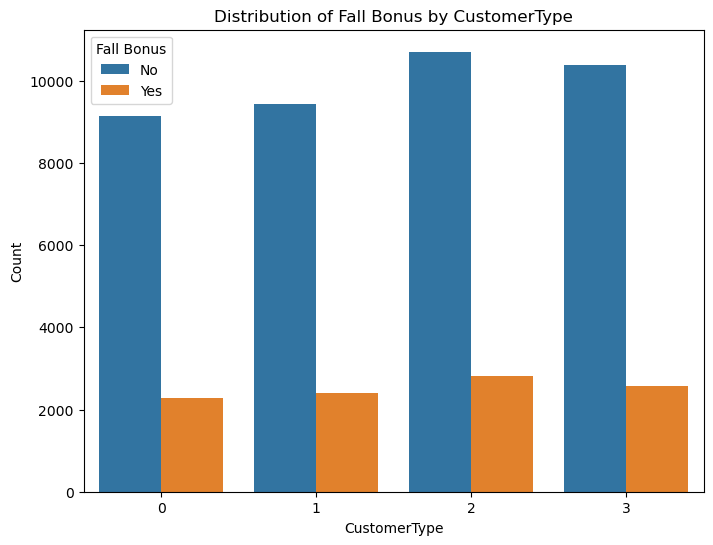

In [111]:
# 7. Visual Exploration
#    Example: Bar plot of CustomerType vs. fallbonus
if 'CustomerType' in basetable_summerC.columns:
    plt.figure(figsize=(8,6))
    sns.countplot(data=basetable_summerC, x='CustomerType', hue='fallbonus')
    plt.title("Distribution of Fall Bonus by CustomerType")
    plt.xlabel("CustomerType")
    plt.ylabel("Count")
    plt.legend(title='Fall Bonus', labels=['No', 'Yes'])
    plt.show()

## Customer Type Analysis

We create a new basetable in order to make a small analysis on Customer Type

In [112]:
summersesstrx_grouped = summersesstrx.groupby('CustomerID', as_index=False).agg({'Experience': 'sum', 'Duration': 'sum'})
basetable_summer = pd.merge(basetable_summer, summersesstrx_grouped, on='CustomerID', how='left')

In [113]:
basetable_summer['CustomerType'] = basetable_summer['CustomerType'].replace({0: 'Walker', 1: 'Miscellaneous', 2: 'Social Raider', 3: 'Catcher'})

In [114]:
basetable_summer

CustomerID  frequency  recency   CustomerType Registrationdate  Gender  \
0               1          6        9  Social Raider       2021-01-01       0   
1               2         10        8        Catcher       2022-01-21       0   
2               3          4       50  Miscellaneous       2021-05-27       0   
3               4          9       11        Catcher       2022-04-10       1   
4               5          6       52  Miscellaneous       2021-05-16       1   
...           ...        ...      ...            ...              ...     ...   
49758       49996         10        3         Walker       2022-03-27       1   
49759       49997         10       16        Catcher       2022-03-04       0   
49760       49998          6       22  Social Raider       2018-07-26       0   
49761       49999          9        1        Catcher       2020-12-30       0   
49762       50000         10        9        Catcher       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue age_group  Experience    Duration  
0        8          0     Low           0.00      6-17       25413  467.125732  
1       45          0    High           0.00     38-49       40870  326.701266  
2       29          1    High           0.00     28-37       16987  118.696935  
3       18          0    High           4.99      6-17       37459  290.401223  
4       48          1     Low           0.00     38-49       23175  156.226666  
...    ...        ...     ...            ...       ...         ...         ...  
49758    9          1     Low           0.00      6-17       33909  776.672629  
49759   37          0     Low           0.00     28-37       36071  275.354204  
49760   27          1  Medium           9.98     18-27       36106  556.603774  
49761   28          0    High           0.00     18-27       39043  195.757207  
49762   26          0     Low           0.00     18-27       40376  312.569905  

[49763 rows x 13 columns]

In [115]:
basetable_summer.groupby('CustomerType',as_index=True).agg(experience=('Experience', 'mean'))

experience
CustomerType               
Catcher        28281.808069
Miscellaneous  25421.671032
Social Raider  39640.240885
Walker         26976.040378

In [116]:
basetable_summer.groupby('CustomerType',as_index=True).agg(duration=('Duration', 'mean'))

duration
CustomerType             
Catcher        199.952927
Miscellaneous  288.025486
Social Raider  997.962873
Walker         511.696469

In [117]:
basetable_summer['Income'] = basetable_summer['Income'].replace({'Low': 0, 'Medium': 1, 'High': 2})
basetable_summer.groupby('CustomerType',as_index=True).agg(income=('Income', 'mean'))

C:\Users\CG121\AppData\Local\Temp\ipykernel_17820\1764209535.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


income
CustomerType           
Catcher        1.186917
Miscellaneous  0.981330
Social Raider  0.422750
Walker         0.939346

In [118]:
basetable_summer.groupby('CustomerType',as_index=True).agg(recency=('recency', 'mean'))

recency
CustomerType            
Catcher        16.949549
Miscellaneous  18.047732
Social Raider  14.802973
Walker         16.829488

In [119]:
basetable_summer.groupby('CustomerType',as_index=True).agg(frequency=('frequency', 'mean'))

frequency
CustomerType            
Catcher         7.376765
Miscellaneous   7.128157
Social Raider   8.433992
Walker          7.449222

In [120]:
basetable_summer.groupby('CustomerType',as_index=True).agg(monetaryvalue=('MonetaryValue', 'mean'))

monetaryvalue
CustomerType                
Catcher             3.100644
Miscellaneous       2.035633
Social Raider       7.936667
Walker              2.344926

In [121]:
#finding active customers
active = {
    'summer' : data['summersesstrx'].groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                         recency = ('Date', lambda date: (dates['summerend'] - date.max()).days))
    }
active['summer']['recency'] = active['summer']['recency'].astype(int)

active['fall']=data['fallsesstrx'].groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                     recency = ('Date', lambda date: (dates['fallend'] - date.max()).days))
active['fall']['recency'] = active['fall']['recency'].astype(int)

#creating basetables
basetable = {
    'summer' : analysis['active_summer'].merge(data['customerdata'], how='inner', left_on = 'CustomerID', right_on = 'CustomerID')
    }

analysis['summerfin'] = data['summerfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))

basetable['summer'] = basetable['summer'].merge(analysis['summerfin'], how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable['summer'].fillna(0, inplace=True)

basetable['fall'] = analysis['active_fall'].merge(data['customerdata'], how='inner', left_on = 'CustomerID', right_on = 'CustomerID')

analysis['fallfin'] = data['fallfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))
basetable['fall'] = basetable['fall'].merge(analysis['fallfin'], how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable['fall'].fillna(0, inplace=True)

# Finding number of customers who received the fall bonus
fallbonus = {
    'num' : basetable['summer']['fallbonus'].sum()}

# setting information for CLV calculations
CLV = {
       'summer' : basetable['summer'][['CustomerID', 'MonetaryValue']],
       'AC' : 1,
       'Discount_rate' : 0.085,
       'periods' : 3
       }

#calculating retention rate in fall
analysis['retention for fall']= len(pd.unique(data['fallsesstrx']['CustomerID']))/ len(pd.unique(data['summersesstrx']['CustomerID']))

# Calculating the total basetable
basetable['all'] = data['customerdata']
basetable['all']['MonetaryValueS'] = basetable['summer']['MonetaryValue']
basetable['all']['MonetaryValueF'] = basetable['fall']['MonetaryValue']
basetable['all'].fillna(0, inplace=True)
basetable['all']['MonetaryValue'] = basetable['all']['MonetaryValueS'] + basetable['all']['MonetaryValueF']